# Modelos de Machine Learning Clásicos: Regresión Logística, Random Forest, XGBoost y Gradient Boosting

In [1]:
# IMPORTAR LIBRERIAS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from scipy.stats import loguniform

from itertools import product

import xgboost as xgb

from tqdm import tqdm

from sklearn.metrics import roc_auc_score,average_precision_score,precision_score,f1_score,recall_score,classification_report,roc_curve,confusion_matrix,accuracy_score, precision_recall_curve


#### Entrenamiento inicial de los modelos
Realizo el entrenamiento de los modelos con el dataset definitivo, luego del ajuste en las variables sugerido durante el proceso de validación con los médicos anestesiólogos y la preparación de ventanas deslizantes con datos agregados

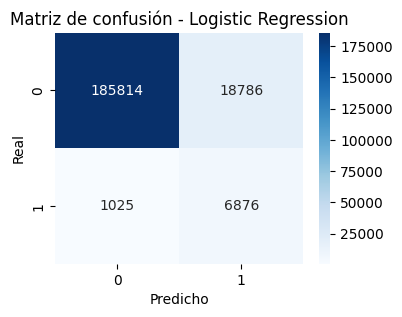

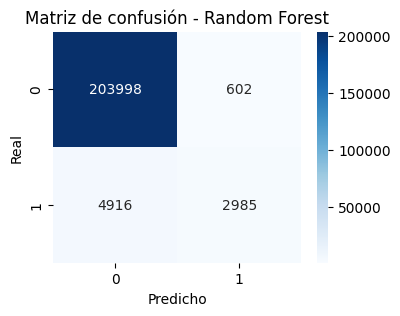

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:50:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


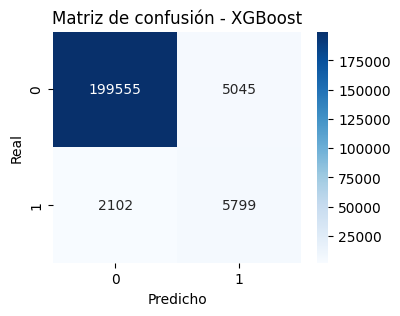

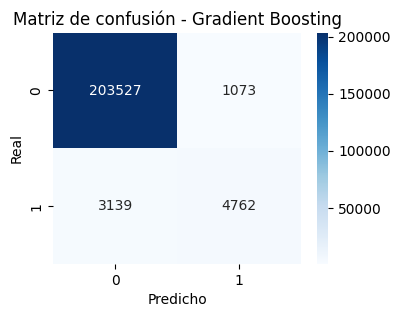


=== Resultados comparativos ===
                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
3    Gradient Boosting  0.980179   0.816110  0.602709  0.693361  0.967324   
1        Random Forest  0.974033   0.832172  0.377800  0.519673  0.961412   
2              XGBoost  0.966367   0.534766  0.733958  0.618725  0.956497   
0  Logistic Regression  0.906772   0.267945  0.870270  0.409737  0.938322   

     PR-AUC  
3  0.770747  
1  0.711040  
2  0.684827  
0  0.632201  


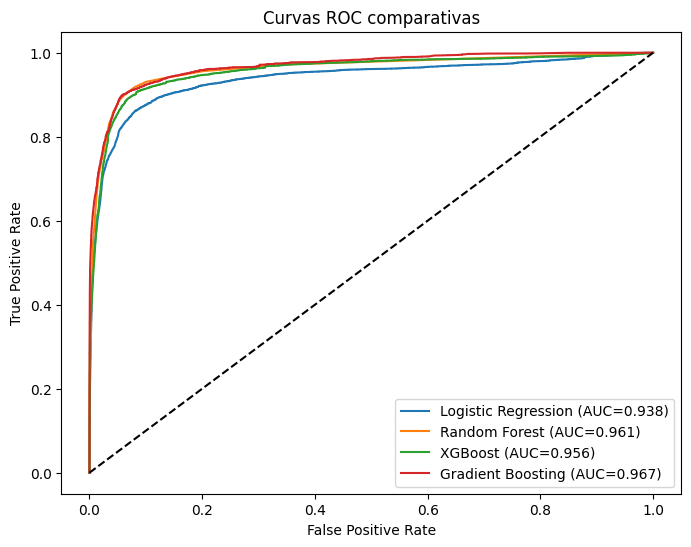

In [3]:
# CARGAR DATOS DE LOS DATOS PREPARADOS DESPUÉS DE SELECCIÓN DEFINITIVA DE COLUMNAS
df = pd.read_parquet("windows_output/windows_aggregated2.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# == FUNCIÓN GENÉRICA ==
results = []
roc_curves = {}

def entrenar_modelo(nombre, pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Métricas
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)

    results.append({
        "Modelo": nombre,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

    # Guardar curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves[nombre] = (fpr, tpr, roc_auc)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión - {nombre}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

# == ENTRENAMIENTO DE MODELOS ==

# REGRESIÓN LOGÍSTICA
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
entrenar_modelo("Logistic Regression", logreg_pipeline, X_train, y_train, X_test, y_test)

# RANDOM FOREST
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
entrenar_modelo("Random Forest", rf_pipeline, X_train, y_train, X_test, y_test)

# XGBOOST
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='logloss',
        random_state=42, scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1])
    ))
])
entrenar_modelo("XGBoost", xgb_pipeline, X_train, y_train, X_test, y_test)

# GRADIENT BOOSTING
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(random_state=42))
])
entrenar_modelo("Gradient Boosting", gb_pipeline, X_train, y_train, X_test, y_test)

# == Tabla omparativa de métricas ==
df_results = pd.DataFrame(results)
print("\n=== Resultados comparativos ===")
print(df_results.sort_values(by="ROC-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()


#### Interpretación de los resultados
**Accuracy:** me muestra qué tanto acierta en general los modelos entrenados

Todos menos la regresión logística están por encima del 96%, lo cual parece altísimo.
Pero debido a que mis datos de base están desbalanceados, el modelo puede “ganar” accuracy prediciendo casi siempre no hipoxemia (mi clase mayoritaria, no hipoxemia, corresponde al 97% del total de registros). Entonces esta no es la mejor métrica para determinar la calidad de los modelos.

**Precision:** me muestra qué tan confiables son las alarmas de hipoxemia

- Random Forest (0.83): el mejor en evitar falsas alarmas (falsos positivos),cuando dice “hipoxemia”, casi siempre es cierto.
- Gradient Boosting (0.82): también bastante bueno.
- Regresión Logística (0.27): casi todas sus alarmas son falsas.
- XGBoost (0.53): medio camino.

**Recall:** me muestra qué tantos casos de hipoxemia detecta. En un contexto clínico, minimizar falsos negativos es clave, por lo que el recall es una métrica crítica.

- Regresión Logística (0.87): detecta casi todos los casos positivos
- XGBoost (0.73) y Gradient Boosting (0.6): buena cobertura, aunque no tanto como la logística.
- Random Forest (0.38): deja escapar más de la mitad de los casos reales.

**F1-Score:** balance entre precisión y recall.

- Gradient Boosting (0.69): mejor equilibrio entre detectar casos y no dar demasiadas falsas alarmas.
- XGBoost (0.62): balance decente, aunque menor precisión.
- Random Forest (0.52): precisión alta pero recall bajísimo, balance pobre.
- Logistic Regression (0.41): recall altísimo pero la precisión lo hunde.

Según el F1-Score Gradient Boosting es, por ahora, el más balanceado.

**ROC-AUC:** capacidad global de discriminación

- Todos están muy altos (>0.94).
- Gradient Boosting (0.97) y Random Forest (0.96) lideran, esto significa que en general saben separar bien casos positivos de negativos.
- Logistic Regression (0.94) sigue siendo competitivo en discriminación, aunque flojo en precisión.

**Conclusiones:**

- Si quiero priorizar detectar la mayoría de hipoxemias (alto recall), los mejores modelos son Logistic Regression o XGBoost.
- Si quiero priorizar evitar falsas alarmas (alta precisión) el mejor es Random Forest.
- El mejor balance global (F1 + ROC-AUC) lo muestra Gradient Boosting.

En mi proyecto de predicción de hipoxemia, es más riesgoso dejar escapar un evento (Falsos Negativos) que generar una falsa alarma (Falsos Positivos). Por eso, por ahora, Gradient Boosting y XGBoost son las mejores opciones.

## Ajuste de Hiperparámetros
Después del entrenamiento inicial de los modelos clásicos, voy a realizar un ajuste de hiperparámetros con el objetivo de optimizar su rendimiento. El objetivo es encontrar la mejor combinación de parámetros que maximice la capacidad predictiva del modelo sin incurrir en sobreajuste.

#### 1. Regresión Logística.
**Pasos a seguir**
1. Estrategia de validación: GroupKFold
Debido a que los datos pertenecen a distintos pacientes identificados por caseid, es importante evitar que las observaciones del mismo individuo aparezcan simultáneamente en los conjuntos de entrenamiento y validación.
Para ello, utilizaré la técnica GroupKFold, que divide el conjunto de entrenamiento en k pliegues (en este caso, 5), asegurando que todos los registros de un mismo paciente permanezcan juntos en una sola partición. 

2. Búsqueda aleatoria: RandomizedSearchCV
Para explorar el espacio de hiperparámetros de forma eficiente, voy a utilizar RandomizedSearchCV, una técnica que selecciona aleatoriamente combinaciones de parámetros dentro de los rangos definidos.
A diferencia de GridSearchCV, que prueba todas las combinaciones posibles (lo que puede ser muy costoso computacionalmente), RandomizedSearchCV permite limitar el número de combinaciones a evaluar, ofreciendo un equilibrio entre tiempo de ejecución y calidad de búsqueda.

    En este caso, los hiperparámetros ajustados incluyeron:
    - C: el inverso de la regularización, que controla la penalización aplicada a los coeficientes (valores altos implican menos regularización).
    - penalty: tipo de regularización utilizada (l1, l2, elasticnet, etc.).
    - solver: algoritmo de optimización empleado para ajustar el modelo.
    - class_weight: balanceo de clases para manejar posibles desbalances en los datos.

    La métrica de evaluación que usaré es el Área bajo la curva de Precisión-Recall (PR-AUC), ya que el problema presenta desbalance entre clases y esta métrica refleja mejor la capacidad del modelo para identificar correctamente los casos positivos.

3. Entrenamiento
El modelo se va a entrenar utilizando solo los conjuntos de entrenamiento (X_train, y_train) junto con el argumento groups=caseids_train para aplicar correctamente la validación agrupada.
RandomizedSearchCV internamente realiza múltiples ciclos de entrenamiento y validación cruzada para estimar el desempeño medio de cada combinación de hiperparámetros.

In [ ]:
# AJUSTE DE HIPERPARAMETROS PARA REGRESIÓN LOGÍSTICA

from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from scipy.stats import loguniform

# Definir el pipeline de regresión logística
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, solver='saga',  random_state=42))
])

# --- Espacio de búsqueda de hiperparámetros ---
param_dist = {
    'clf__penalty': ['l1', 'l2'],                  # regularización L1/L2
    'clf__C': loguniform(1e-4, 1e3),               # fuerza de regularización
    'clf__class_weight': [None, 'balanced'],       # balanceo de clases
    'clf__solver': ['saga']                        # soporta L1 y L2
}

# CV estratificado por cirugía (Validación cruzada agrupada por cirugía)
cv = GroupKFold(n_splits=5)

# Búsqueda aleatoria
rs = RandomizedSearchCV(
    logreg_pipeline,
    param_distributions=param_dist,
    n_iter=20,  # número de combinaciones a probar
    scoring='average_precision',  # métrica basada en PR-AUC
    cv=cv,
    verbose=2,
    n_jobs=-1,        # usa todos los núcleos disponibles
    random_state=42
)

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# Entrenar (Ejecutar la búsqueda aleatoria)
rs.fit(X_train, y_train, groups=caseids_train)

# Resultados
print("Mejor conjunto de parámetros:", rs.best_params_)
print("Mejor puntuación (PR-AUC):", rs.best_score_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END clf__C=0.041858227295469716, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=13.6min
[CV] END clf__C=0.041858227295469716, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=16.5min
[CV] END clf__C=0.041858227295469716, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=23.9min
[CV] END clf__C=0.0012363188277052211, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 1.2min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf__C=0.041858227295469716, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=26.3min
[CV] END clf__C=0.0012363188277052211, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 1.5min
[CV] END clf__C=0.0012363188277052211, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 1.1min
[CV] END clf__C=0.0012363188277052211, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 1.7min
[CV] END clf__C=0.0012363188277052211, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 1.1min
[CV] END clf__C=0.00025502648504032837, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=  27.0s
[CV] END clf__C=0.041858227295469716, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=29.2min
[CV] END clf__C=0.00025502648504032837, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=  55.7s
[CV] END clf__C=0.00025502648504032837, clf__class_weigh

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=13.3032451015229, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=47.6min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=13.3032451015229, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=47.8min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=13.3032451015229, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=47.9min
[CV] END clf__C=0.000139345022513376, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=  34.5s
[CV] END clf__C=0.000139345022513376, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=  31.3s
[CV] END clf__C=0.000139345022513376, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=  44.1s
[CV] END clf__C=0.000139345022513376, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=  31.6s
[CV] END clf__C=0.000139345022513376, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=  31.9s


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=13.3032451015229, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=47.5min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=13.3032451015229, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=48.2min
[CV] END clf__C=1.6136341713591311, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=44.9min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.6136341713591311, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=47.5min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.6136341713591311, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=48.7min
[CV] END clf__C=0.0018740223688836334, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 1.5min
[CV] END clf__C=0.0018740223688836334, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 2.6min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=67.1581131106993, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=34.0min
[CV] END clf__C=0.0018740223688836334, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 3.1min
[CV] END clf__C=0.0018740223688836334, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 3.1min
[CV] END clf__C=0.0018740223688836334, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time= 2.9min
[CV] END clf__C=0.013480180290890806, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time= 6.2min
[CV] END clf__C=1.6136341713591311, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=47.4min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.6136341713591311, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=47.5min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=67.1581131106993, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=34.4min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=67.1581131106993, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=34.4min
[CV] END clf__C=0.013480180290890806, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time= 4.9min
[CV] END clf__C=0.013480180290890806, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time= 9.1min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=67.1581131106993, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=35.0min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=67.1581131106993, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=35.2min
[CV] END clf__C=0.10558813779064824, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=26.1min
[CV] END clf__C=0.10558813779064824, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=28.7min
[CV] END clf__C=0.10558813779064824, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=28.6min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.013480180290890806, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=45.8min
[CV] END clf__C=1.918537370384187, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=23.0min
[CV] END clf__C=0.10558813779064824, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=36.8min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.013480180290890806, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=45.7min
[CV] END clf__C=0.011092068418536168, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time= 5.8min
[CV] END clf__C=0.10558813779064824, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=36.0min
[CV] END clf__C=1.918537370384187, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=24.9min
[CV] END clf__C=0.011092068418536168, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time= 6.4min
[CV] END clf__C=0.011092068418536168, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time= 4.7min
[CV] END clf__C=1.918537370384187, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=26.6min
[CV] END clf__C=1.918537370384187, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=27.2min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.918537370384187, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=34.5min
[CV] END clf__C=0.002498713568466946, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time= 3.1min
[CV] END clf__C=0.002498713568466946, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time= 3.8min
[CV] END clf__C=0.002498713568466946, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time= 3.7min
[CV] END clf__C=0.002498713568466946, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time= 3.8min
[CV] END clf__C=0.011092068418536168, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=37.1min
[CV] END clf__C=0.15577217702693022, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=31.4min
[CV] END clf__C=0.002498713568466946, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time= 3.8min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.011092068418536168, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=46.1min
[CV] END clf__C=0.15577217702693022, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=34.2min
[CV] END clf__C=0.15577217702693022, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=33.6min
[CV] END clf__C=0.15577217702693022, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=30.1min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.15577217702693022, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=34.9min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.4024971326600353, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=46.2min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.4024971326600353, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=46.3min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.4024971326600353, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=46.4min
[CV] END clf__C=0.00028533901052402264, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=  56.2s


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.4024971326600353, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=46.9min
[CV] END clf__C=0.00028533901052402264, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=  36.1s
[CV] END clf__C=0.00028533901052402264, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=  31.5s
[CV] END clf__C=0.00028533901052402264, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time=  29.2s
[CV] END clf__C=0.00028533901052402264, clf__class_weight=balanced, clf__penalty=l1, clf__solver=saga; total time= 1.4min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.7898389848671583, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=46.3min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.4024971326600353, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=47.6min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.7898389848671583, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=46.4min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.7898389848671583, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=46.6min
[CV] END clf__C=0.013561145768453494, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time= 8.0min
[CV] END clf__C=0.013561145768453494, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time= 9.5min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=574.6775499181848, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=34.4min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=574.6775499181848, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=34.5min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=574.6775499181848, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=34.4min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=574.6775499181848, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=35.1min
[CV] END clf__C=0.013561145768453494, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time= 9.4min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.7898389848671583, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=47.8min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1.7898389848671583, clf__class_weight=None, clf__penalty=l1, clf__solver=saga; total time=48.5min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=574.6775499181848, clf__class_weight=balanced, clf__penalty=l2, clf__solver=saga; total time=35.4min
[CV] END clf__C=0.013561145768453494, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time= 9.4min
[CV] END clf__C=0.013561145768453494, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=10.2min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=6.160715952774541, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=28.7min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=6.160715952774541, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=28.2min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=6.160715952774541, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=27.4min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=6.160715952774541, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=26.2min


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=6.160715952774541, clf__class_weight=None, clf__penalty=l2, clf__solver=saga; total time=25.9min
Mejor conjunto de parámetros: {'clf__C': np.float64(0.0018740223688836334), 'clf__class_weight': None, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Mejor puntuación (PR-AUC): 0.6662911880451874


Al finalizar la búsqueda, se registraron:

- Los mejores hiperparámetros encontrados (rs.best_params_)
- La mejor puntuación promedio de validación (rs.best_score_)

Voy a comparar el rendimiento del modelo entrenado en la fase inicial, con el modelo entrenado usando estos nuevos parámetros

In [ ]:
# Entrenamiento del mejor modelo de Regresión Logística encontrado por RandomizedSearchCV
best_logreg = rs.best_estimator_
best_logreg.fit(X_train, y_train)
nombre = ('Logistic Regression (RSearchCV)')

# Predicciones
y_pred = best_logreg.predict(X_test)
y_proba = best_logreg.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
logreg_tuned_results = pd.DataFrame([{
    'Modelo': nombre,
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc
}])

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_curves[nombre] = (fpr, tpr, roc_auc)

# Mostrar resultados
print(logreg_tuned_results)


                            Modelo  Accuracy  Precision    Recall  F1-score  \
0  Logistic Regression (RSearchCV)  0.975821   0.813336  0.453867  0.582616   

   ROC-AUC    PR-AUC  
0  0.92499  0.648566  


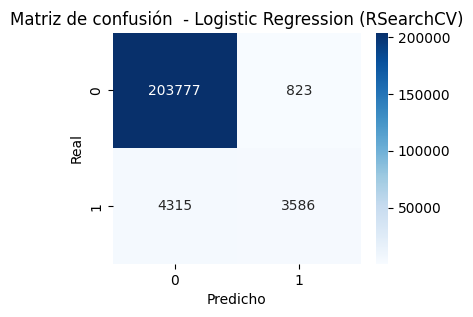

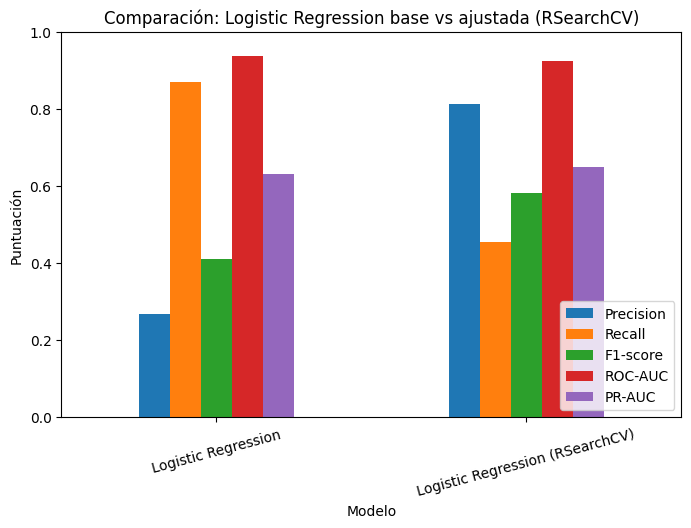

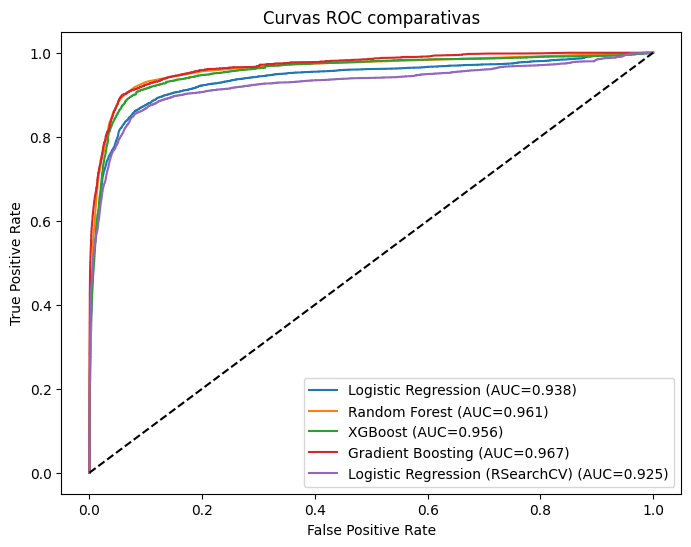

Modelo  Accuracy  Precision    Recall  F1-score  \
0              Logistic Regression  0.906772   0.267945  0.870270  0.409737   
4  Logistic Regression (RSearchCV)  0.975821   0.813336  0.453867  0.582616   

    ROC-AUC    PR-AUC  
0  0.938322  0.632201  
4  0.924990  0.648566

In [ ]:
#COMPARAR RESULTADOS INICIALES CON RESULTADOS AJUSTADOS - REGRESIÓN LOGÍSTICA
df_results_completo = pd.concat([df_results, logreg_tuned_results], ignore_index=True)

# Filtrar solo las dos versiones del modelo para la comparación
df_comp = df_results_completo[df_results_completo['Modelo'].str.contains("Logistic Regression")]

# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión  - {nombre}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Graficar métricas clave
df_comp.set_index('Modelo')[['Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC']].plot(kind='bar', figsize=(8,5))
plt.title("Comparación: Logistic Regression base vs ajustada (RSearchCV)")
plt.ylabel("Puntuación")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()

df_comp


#### Conclusiones de la comparación:
1. Exactitud (Accuracy)
El modelo ajustado muestra una mejora importante en accuracy (de 0.91 a 0.98). Sin embargo, esta métrica puede ser engañosa cuando hay desequilibrio entre clases, por lo que no será esta la métrica principal.
2. Precisión (Precision)
La precisión aumentó notablemente (de 0.27 a 0.81), lo que significa que el modelo ajustado comete muchos menos falsos positivos: cuando predice la clase positiva, tiene mucha más probabilidad de acertar.Entonces el ajuste favoreció la confiabilidad de las predicciones positivas.
3. Sensibilidad o Recall
El recall cayó de 0.87 a 0.45, lo que indica que el modelo ajustado detecta menos de la mitad de los casos positivos reales. Este cambio sugiere un desplazamiento en el balance precision–recall: el modelo se volvió más conservador al predecir positivos, priorizando la precisión sobre la cobertura.
4. F1-score
El F1-score aumentó de 0.41 a 0.58, lo que muestra una mejor armonía entre precisión y recall en el modelo ajustado. Aunque perdió capacidad de detección de positivos, el equilibrio general entre ambos indicadores mejoró, reflejando un desempeño más estable.
5. ROC-AUC
El valor de ROC-AUC disminuyó ligeramente (de 0.938 a 0.925), pero la diferencia es mínima.
Esto sugiere que, en términos de discriminación global (capacidad del modelo para distinguir entre clases), el ajuste no afectó significativamente el rendimiento.

Una conclusión general de este método para ajustar hiperparámetros, es que en RandomizedSearchCV es muy poco eficiente, toma demasiado tiempo, a veces repite y no aprende de las pruebas que va realizando. Por eso, para los siguientes consideraré otras formas de hacerlo.

#### 2. Random Forest

**Ajuste de hiperparámetros — Búsqueda manual con rejilla** 

Este método busca identificar la combinación de hiperparámetros que maximiza el desempeño del modelo Random Forest en la predicción de hipoxemia, explorando de forma controlada los valores más influyentes.

Pasos a seguir:

1. Selección de hiperparámetros relevantes: Se escogen los parámetros con mayor impacto en el desempeño del modelo:
    - n_estimators: número de árboles del bosque.
    - max_depth: profundidad máxima de cada árbol.
    - min_samples_split: número mínimo de muestras requeridas para dividir un nodo.
    - min_samples_leaf: número mínimo de muestras por hoja.
    - max_features: número de variables consideradas en cada división.
    - bootstrap: uso o no de muestreo con reemplazo.

2. Definición de los rangos de búsqueda: Para cada hiperparámetro se define un conjunto discreto de valores razonables.

3. Creación del esquema de validación cruzada: Se utilizará GroupKFold, para asegurar que todas las muestras provenientes de una misma cirugía (caseid) permanezcan en el mismo conjunto (entrenamiento o validación), evitando fugas de información.

4. Entrenamiento del modelo con cada combinación: El modelo será entrenado y evaluado para cada conjunto de hiperparámetros definido en la rejilla.

5. Evaluación de desempeño: Se utilizará como métrica principal el área bajo la curva Precision-Recall (PR-AUC), adecuada para datasets desbalanceados, complementada con métricas de accuracy, recall, precision y F1-score.

6. Selección de la mejor combinación: Se elige el conjunto de hiperparámetros que obtenga el mejor puntaje promedio de PR-AUC en la validación cruzada.

In [100]:
# AJUSTE DE HIPERPARAMETROS PARA RANDOM FOREST - BÚSQUEDA MANUAL CON REJILLA

# Definir Pipeline

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Definir la rejilla de hiperparámetros manual
param_grid = {
    'clf__n_estimators': [100],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2']
}

# Generar todas las combinaciones posibles
param_combinations = list(product(
    param_grid['clf__n_estimators'],
    param_grid['clf__max_depth'],
    param_grid['clf__min_samples_split'],
    param_grid['clf__min_samples_leaf'],
    param_grid['clf__max_features']
))

print(f"Total de combinaciones: {len(param_combinations)}")


Total de combinaciones: 72


In [101]:
# ENTRENAMIENTO Y EVALUACIÓN DE CADA COMBINACIÓN

best_score = 0
best_paramsrf = None
results = []

for i, (n_est, max_d, min_split, min_leaf, max_feat) in enumerate(param_combinations):
    print(f"\nProbando combinación {i+1}/{len(param_combinations)}...")

    rf_pipeline.set_params(
        clf__n_estimators=n_est,
        clf__max_depth=max_d,
        clf__min_samples_split=min_split,
        clf__min_samples_leaf=min_leaf,
        clf__max_features=max_feat
    )

    # Entrenar modelo
    rf_pipeline.fit(X_train, y_train)

    # Predecir en validación (aquí usamos el set de test)
    y_pred = rf_pipeline.predict(X_test)
    y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

    # Evaluar desempeño
    pr_auc = average_precision_score(y_test, y_prob)
    print(f"PR-AUC: {pr_auc:.4f}")

    results.append((n_est, max_d, min_split, min_leaf, max_feat, pr_auc))

    if pr_auc > best_score:
        best_score = pr_auc
        best_paramsrf = (n_est, max_d, min_split, min_leaf, max_feat)

print("\nMejor configuración encontrada:")
print(f"n_estimators={best_paramsrf[0]}, max_depth={best_paramsrf[1]}, min_samples_split={best_paramsrf[2]}, "
      f"min_samples_leaf={best_paramsrf[3]}, max_features={best_paramsrf[4]}")
print(f"Mejor PR-AUC: {best_score:.4f}")



Probando combinación 1/72...
PR-AUC: 0.7110

Probando combinación 2/72...
PR-AUC: 0.7268

Probando combinación 3/72...
PR-AUC: 0.7213

Probando combinación 4/72...
PR-AUC: 0.7422

Probando combinación 5/72...
PR-AUC: 0.7430

Probando combinación 6/72...
PR-AUC: 0.7504

Probando combinación 7/72...
PR-AUC: 0.7180

Probando combinación 8/72...
PR-AUC: 0.7327

Probando combinación 9/72...
PR-AUC: 0.7213

Probando combinación 10/72...
PR-AUC: 0.7337

Probando combinación 11/72...
PR-AUC: 0.7430

Probando combinación 12/72...
PR-AUC: 0.7504

Probando combinación 13/72...
PR-AUC: 0.7210

Probando combinación 14/72...
PR-AUC: 0.7279

Probando combinación 15/72...
PR-AUC: 0.7159

Probando combinación 16/72...
PR-AUC: 0.7269

Probando combinación 17/72...
PR-AUC: 0.7405

Probando combinación 18/72...
PR-AUC: 0.7316

Probando combinación 19/72...
PR-AUC: 0.6462

Probando combinación 20/72...
PR-AUC: 0.6463

Probando combinación 21/72...
PR-AUC: 0.6370

Probando combinación 22/72...
PR-AUC: 0.63

In [ ]:
# Mostrar mejores parámetros
print(best_paramsrf)

(100, None, 2, 4, 'log2')


In [ ]:
# ENTRENAR MODELO RANDOM FOREST CON MEJORES PARÁMETROS Y ALMACENAR RESULTADOS

# Pipeline con los mejores parámetros
rf_pipeline.set_params(
    clf__n_estimators=best_paramsrf[0],
    clf__max_depth=best_paramsrf[1],
    clf__min_samples_split=best_paramsrf[2],
    clf__min_samples_leaf=best_paramsrf[3],
    clf__max_features=best_paramsrf[4] 
    )

rf_pipeline.fit(X_train, y_train)

# Predicciones
y_pred = rf_pipeline.predict(X_test)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

nombre = ('Random Forest (tuned)')

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
metrics = {
    "Modelo": nombre,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc,
    "PR-AUC": pr_auc
}
# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves[nombre] = (fpr, tpr, roc_auc)

# Añadir resultados al DataFrame existente
df_results2 = pd.concat([df_results_completo, pd.DataFrame([metrics])], ignore_index=True)


In [ ]:
# Mostrar resultados
print(pd.DataFrame([metrics]))

                  Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
0  Random Forest (tuned)   0.97825   0.762614  0.602582  0.673218  0.965781   

     PR-AUC  
0  0.750397  


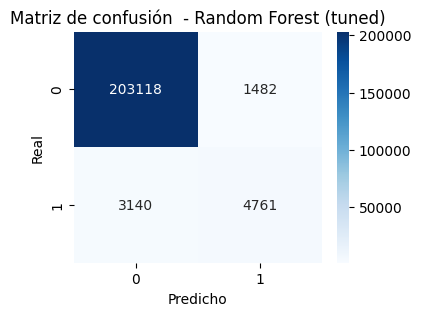

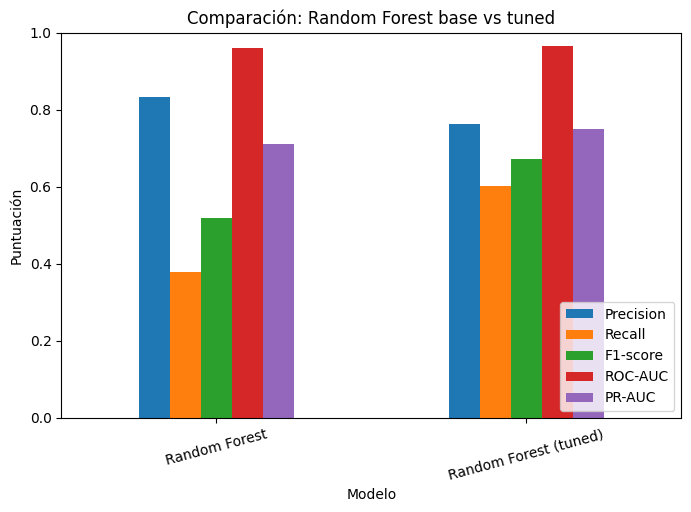

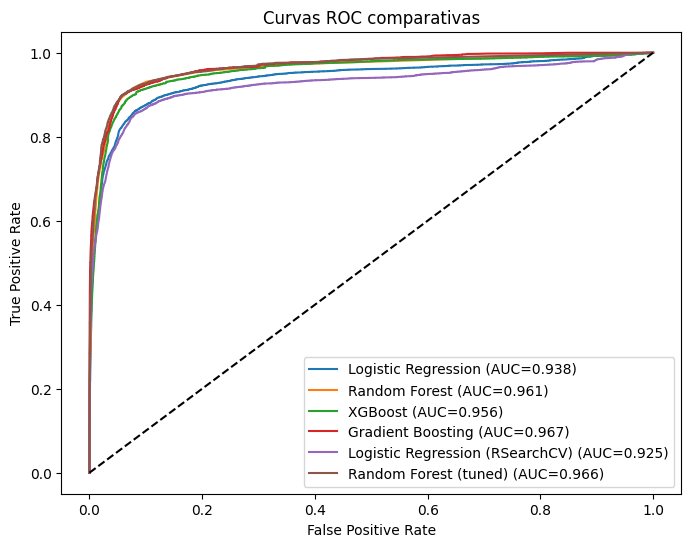

Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
1          Random Forest  0.974033   0.832172  0.377800  0.519673  0.961412   
5  Random Forest (tuned)  0.978250   0.762614  0.602582  0.673218  0.965781   

     PR-AUC  
1  0.711040  
5  0.750397

In [114]:
#COMPARAR RESULTADOS INICIALES CON RESULTADOS AJUSTADOS

# Filtrar solo las dos versiones del modelo
df_comp = df_results2[df_results2['Modelo'].str.contains("Random Forest")]

# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión  - {nombre}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Graficar métricas clave
df_comp.set_index('Modelo')[['Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC']].plot(kind='bar', figsize=(8,5))
plt.title("Comparación: Random Forest base vs tuned")
plt.ylabel("Puntuación")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()

df_comp

#### Conclusiones de la comparación:

1. El cambio más importante se ve en el Recall y el F1-score.

- El recall pasó de 0.38 a 0.60, lo cual es una mejora muy significativa. Esto quiere decir que el modelo está detectando muchas más de las instancias positivas.
- El F1-score, que equilibra precision y recall, también mejora fuertemente.

2. La precision bajó un poco, lo que indica que el modelo comete más falsos positivos.
Pero en un contexto médico, es preferible aumentar el recall aunque baje un poco la precision, porque es más aceptable tener algunas alertas falsas, que dejar de detectar casos verdaderos.

3. El ROC-AUC mejoró ligeramente, lo cual muestra que el modelo ajustado tiene una mejor capacidad de separación entre clases.

Todo esto me muestra una buena mejora en el desempeño del modelo.

El modelo ajustado está cumpliendo mejor el objetivo principal: detectar más casos positivos de manera correcta.

#### Random Forest

**Ajuste de hiperparámetros — Optimización Bayesiana (Optuna)** 
Esta técnica busca refinar los hiperparámetros del modelo de forma más eficiente, explorando el espacio de búsqueda de manera adaptativa para maximizar el PR-AUC.

Pasos a seguir:

1. Definición del espacio de búsqueda: Establecer los rangos continuos o discretos de los hiperparámetros más influyentes:
    - n_estimators: entre 100 y 300
    - max_depth: entre 5 y 20
    - min_samples_split: entre 2 y 10
    - min_samples_leaf: entre 1 y 5
    - max_features: sqrt o log2
    - criterion: gini o entropy
    - bootstrap: True o False

2. Definición de la función objetivo: diseño ee una función objective(trial) que:
    - Toma una muestra aleatoria de hiperparámetros.
    - Entrena un modelo con esos parámetros.
    - Evalúa su desempeño usando validación cruzada (GroupKFold).
    - Devuelve el PR-AUC promedio como valor objetivo a maximizar.

3. Ejecución del estudio de optimización: Se crea un estudio con optuna.create_study(direction='maximize') y se ejecuta la búsqueda durante n iteraciones (n_trials=30).

4. Optimización adaptativa: En cada iteración, el optimizador actualiza un modelo probabilístico interno (un Tree Parzen Estimator) que estima cuáles regiones del espacio de búsqueda son más prometedoras, enfocando las siguientes pruebas en esos rangos.

5. Identificación de los mejores parámetros: Al finalizar, Optuna devuelve los hiperparámetros con mayor PR-AUC promedio, junto con la métrica alcanzada.

6. Entrenamiento final del modelo: Se reentrena el modelo Random Forest utilizando los hiperparámetros óptimos obtenidos y se evalúa en el conjunto de prueba.

In [48]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-optimize]


In [49]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [ ]:
# Definir el pipeline completo
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# --- Espacio de búsqueda de hiperparámetros ---
search_spaces = {
    'clf__n_estimators': Integer(100, 600),
    'clf__max_depth': Integer(3, 30),
    'clf__min_samples_split': Integer(2, 20),
    'clf__min_samples_leaf': Integer(1, 10),
    'clf__max_features': Categorical(['sqrt', 'log2', None])
}

# Validación cruzada con agrupamiento por cirugía
cv = GroupKFold(n_splits=2)

# Definición del optimizador bayesiano
bayes_search = BayesSearchCV(
    estimator=rf_pipeline,
    search_spaces=search_spaces,
    scoring='average_precision',  # PR-AUC
    cv=cv,
    n_iter=10,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Entrenamiento
bayes_search.fit(X_train, y_train, groups=caseids_train)

print("\n✅ Mejores hiperparámetros encontrados:")
print(bayes_search.best_params_)
print("\n🔹 Mejor puntaje PR-AUC obtenido:")
print(bayes_search.best_score_)


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END clf__max_depth=14, clf__max_features=None, clf__min_samples_leaf=9, clf__min_samples_split=8, clf__n_estimators=435; total time=28.9min
[CV] END clf__max_depth=14, clf__max_features=None, clf__min_samples_leaf=9, clf__min_samples_split=8, clf__n_estimators=435; total time=29.3min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END clf__max_depth=26, clf__max_features=None, clf__min_samples_leaf=4, clf__min_samples_split=19, clf__n_estimators=532; total time=44.3min
[CV] END clf__max_depth=26, clf__max_features=None, clf__min_samples_leaf=4, clf__min_samples_split=19, clf__n_estimators=532; total time=47.8min
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END clf__max_depth=15, clf__max_features=None, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=194; total time=12.8min
[CV] END clf__max_depth=15, clf__max_features=None, clf__min_samples_leaf=2, clf__min_samples_s

In [126]:
# ENTRENAR MODELO RANDOM FOREST CON MEJORES PARÁMETROS - VERSIÓN 2

# Pipeline con los mejores parámetros
best_rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(
        **{k.replace('clf__', ''): v for k, v in bayes_search.best_params_.items()},
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Entrenar moelo
best_rf_pipeline.fit(X_train, y_train)

nombre = ("Random Forest (bayesian)")

# Predicciones
y_pred = best_rf_pipeline.predict(X_test)
y_pred_proba = best_rf_pipeline.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
metrics = {
    "Modelo": nombre,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc,
    "PR-AUC": pr_auc
}
# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_curves[nombre] = (fpr, tpr, roc_auc)

# Añadir resultados al DataFrame existente
df_results3 = pd.concat([df_results2, pd.DataFrame([metrics])], ignore_index=True)

# Mostrar resultados
print(pd.DataFrame([metrics]))

                     Modelo  Accuracy  Precision    Recall  F1-score  \
0  Random Forest (bayesian)   0.97457   0.642377  0.712948  0.675825   

    ROC-AUC    PR-AUC  
0  0.968502  0.724411  


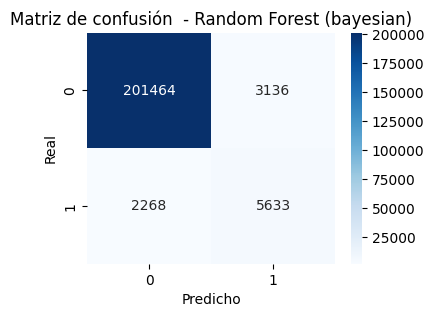

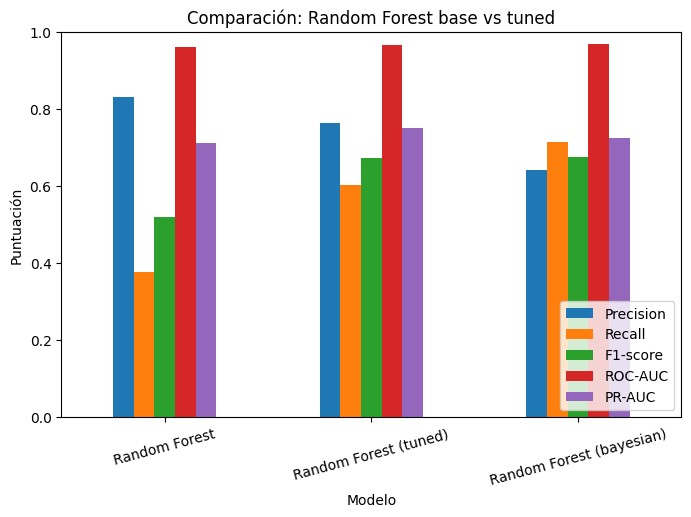

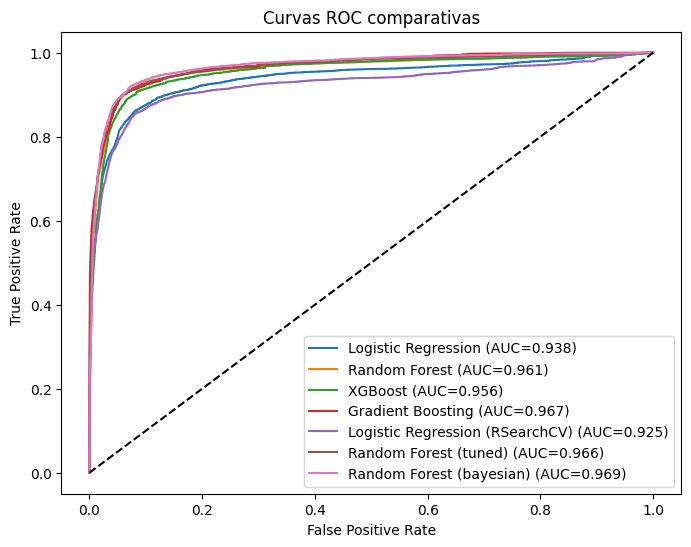

Modelo  Accuracy  Precision    Recall  F1-score  \
1             Random Forest  0.974033   0.832172  0.377800  0.519673   
5     Random Forest (tuned)  0.978250   0.762614  0.602582  0.673218   
6  Random Forest (bayesian)  0.974570   0.642377  0.712948  0.675825   

    ROC-AUC    PR-AUC  
1  0.961412  0.711040  
5  0.965781  0.750397  
6  0.968502  0.724411

In [ ]:
#COMPARAR RESULTADOS ANTERIORES CON NUEVOS RESULTADOS AJUSTADOS - RANDOM FOREST

# Filtrar solo las dos versiones del modelo
df_comp = df_results3[df_results3['Modelo'].str.contains("Random Forest")]

# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión  - {nombre}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Graficar métricas clave
df_comp.set_index('Modelo')[['Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC']].plot(kind='bar', figsize=(8,5))
plt.title("Comparación: Random Forest base vs tuned")
plt.ylabel("Puntuación")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()


#### Conclusiones de la comparación:

1. Precisión global (Accuracy): Todos los modelos tienen una precisión global muy alta (97–98%), lo que indica que el clasificador acierta la mayoría de los casos. Sin embargo, teniendo en cuenta que el dataset está fuertemente desbalanceado, el accuracy no es una métrica representativa.


2. Precision (qué tan confiables son las predicciones positivas):
    - Base: 0.83 —> el modelo inicial era muy conservador: cuando decía “hipoxemia”, solía acertar, pero lo decía pocas veces.
    - Tuned: baja a 0.76 —> se vuelve un poco menos preciso.
    - Bayesian: cae a 0.64 —> ahora tiene más falsos positivos

En modelos médicos, esto puede ser aceptable si el costo de un falso negativo (no detectar
hipoxemia) es mayor que el de un falso positivo (falsa alarma).

3. Recall (capacidad para detectar todos los casos de hipoxemia)
    - Base: 0.38 → detectaba menos de la mitad de los casos reales.
    - Tuned: sube a 0.60 → mucho mejor equilibrio.
    - Bayesian: 0.71 → aumento notable en sensibilidad: detecta el 71% de los eventos reales.

Este salto en recall indica que el modelo bayesiano aprendió a ser más sensible a los casos
positivos, lo que es crucial para alertas médicas tempranas.

4. F1-score (equilibrio entre precisión y recall)
    - Base: 0.52
    - Tuned: 0.67
    - Bayesian: 0.68

La optimización bayesiana logra el mejor balance global entre precisión y sensibilidad,
aunque con un costo pequeño en precisión pura.

5. ROC-AUC (capacidad discriminativa global)
Pasa de 0.9614 a 0.9658, y se mantiene estable entre los modelos ajustados. Esto indica que todos los modelos tienen buena capacidad para distinguir entre clases positivas y negativas.

En contextos clínicos, el modelo bayesiano es probablemente el más útil, pues detecta más casos
reales (mayor recall), con un costo razonable en precision.
Si el objetivo es alertar de riesgo más que diagnosticar con certeza, este es el comportamiento
deseable.

#### 3. XGBoost

**Optimización Bayesiana con Optuna**

Esta técnica busca los valores óptimos de los hiperparámetros, aprendiendo de cada intento previo.
A diferencia de la búsqueda manual o aleatoria, la optimización bayesiana no selecciona combinaciones al azar, sino que utiliza modelos probabilísticos para explorar regiones prometedoras del espacio de búsqueda.

Pasos realizados

1. Definición del espacio de búsqueda: Establecer los rangos para los hiperparámetros más relevantes de XGBoost:
    - n_estimators: 100–400
    - max_depth: 3–9
    - learning_rate: 0.01–0.2
    - subsample: 0.6–1.0
    - colsample_bytree: 0.6–1.0
    - gamma: 0–5
    - reg_lambda: 0.5–2
    - min_child_weight: 1–10

2. Validación cruzada por grupos (GroupKFold): Utilizo GroupKFold(n_splits=3) empleando el identificador caseid como grupo, para evitar fugas de información entre cirugías del mismo paciente.

3. Función objetivo: La métrica optimizada es el PR-AUC (Average Precision Score), adecuada para problemas de clasificación desbalanceada.

4. Ejecución del estudio: Se ejecutarán 30 iteraciones (n_trials=30) del estudio bayesiano con el método study.optimize(), buscando maximizar el PR-AUC promedio.

5. Identificación de los mejores parámetros: Al finalizar, Optuna devuelve los hiperparámetros con mayor PR-AUC promedio, junto con la métrica alcanzada.

6. Entrenamiento final del modelo: Se reentrena el modelo XGBoost utilizando los hiperparámetros óptimos obtenidos y se evalúa en el conjunto de prueba.



In [59]:
!pip install optuna xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [optuna]2m4/5 [optuna]]


In [ ]:

# Importar librerías necesarias
import optuna
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


# Definir la validación cruzada por grupos (caseid)
cv = GroupKFold(n_splits=3)

# Definir la función objetivo para la optimización bayesiana
def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'tree_method': 'hist'  # Cambia a 'gpu_hist' si tienes GPU activa
    }

    # Definir pipeline con preprocesamiento + modelo
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', XGBClassifier(**params))
    ])

    # Validación cruzada usando PR-AUC como métrica principal
    scores = cross_val_score(
        xgb_pipeline,
        X_train,
        y_train,
        groups=caseids_train,
        cv=cv,
        scoring='average_precision',
        n_jobs=-1
    )

    # Optuna maximiza esta métrica
    return np.mean(scores)


# Crear y ejecutar el estudio de optimización
study = optuna.create_study(direction='maximize', study_name='XGBoost_with_Pipeline')

study.optimize(objective, n_trials=30, show_progress_bar=True)

# Mostrar resultados
print("Mejores hiperparámetros encontrados:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

print(f"\ Mejor PR-AUC promedio: {study.best_value:.5f}")


[I 2025-10-08 09:38:06,386] A new study created in memory with name: XGBoost_with_Pipeline


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:38:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:38:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:38:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:38:49,711] Trial 0 finished with value: 0.7193295961543166 and parameters: {'n_estimators': 268, 'max_depth': 7, 'learning_rate': 0.04245977820188595, 'subsample': 0.6853431204539056, 'colsample_bytree': 0.7658658976799427, 'gamma': 0.9643070077205523, 'reg_lambda': 1.9061841332484948, 'min_child_weight': 6}. Best is trial 0 with value: 0.7193295961543166.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:39:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:39:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:39:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:39:31,099] Trial 1 finished with value: 0.7178148084990061 and parameters: {'n_estimators': 384, 'max_depth': 3, 'learning_rate': 0.0514706562243346, 'subsample': 0.7318626541143834, 'colsample_bytree': 0.9834806098380089, 'gamma': 0.13074448211933654, 'reg_lambda': 1.311909572953598, 'min_child_weight': 1}. Best is trial 0 with value: 0.7193295961543166.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:39:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:39:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:39:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:40:12,251] Trial 2 finished with value: 0.7236362097449088 and parameters: {'n_estimators': 367, 'max_depth': 4, 'learning_rate': 0.034278091289815904, 'subsample': 0.627230811576713, 'colsample_bytree': 0.7431444207667477, 'gamma': 0.5105252596134863, 'reg_lambda': 1.6811897851836703, 'min_child_weight': 10}. Best is trial 2 with value: 0.7236362097449088.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:40:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:40:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:40:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:40:36,722] Trial 3 finished with value: 0.7271285057155458 and parameters: {'n_estimators': 143, 'max_depth': 4, 'learning_rate': 0.029996270313787918, 'subsample': 0.9751260117254661, 'colsample_bytree': 0.9407467562803868, 'gamma': 2.3097409966988183, 'reg_lambda': 0.990014360030928, 'min_child_weight': 9}. Best is trial 3 with value: 0.7271285057155458.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:40:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:41:10,784] Trial 4 finished with value: 0.7195964179358123 and parameters: {'n_estimators': 194, 'max_depth': 8, 'learning_rate': 0.051116513453136454, 'subsample': 0.918690706818798, 'colsample_bytree': 0.7241970386655973, 'gamma': 4.869328444780478, 'reg_lambda': 0.5556254789510915, 'min_child_weight': 2}. Best is trial 3 with value: 0.7271285057155458.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:42:04,036] Trial 5 finished with value: 0.7266767492226377 and parameters: {'n_estimators': 362, 'max_depth': 7, 'learning_rate': 0.020576597165774375, 'subsample': 0.6073905089771579, 'colsample_bytree': 0.9481083115809323, 'gamma': 1.962974498532919, 'reg_lambda': 1.655835323415014, 'min_child_weight': 5}. Best is trial 3 with value: 0.7271285057155458.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:42:42,424] Trial 6 finished with value: 0.6764303887672553 and parameters: {'n_estimators': 328, 'max_depth': 6, 'learning_rate': 0.14326811952635268, 'subsample': 0.9710706797328528, 'colsample_bytree': 0.784498763605175, 'gamma': 0.13523750289963554, 'reg_lambda': 1.7593759017412065, 'min_child_weight': 7}. Best is trial 3 with value: 0.7271285057155458.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:42:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:43:05,207] Trial 7 finished with value: 0.7308035201311182 and parameters: {'n_estimators': 115, 'max_depth': 7, 'learning_rate': 0.046735326436436166, 'subsample': 0.9798851252179981, 'colsample_bytree': 0.851463727940901, 'gamma': 2.0884321232475385, 'reg_lambda': 1.5701256333103442, 'min_child_weight': 10}. Best is trial 7 with value: 0.7308035201311182.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:43:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:43:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:43:29,681] Trial 8 finished with value: 0.7122947345036836 and parameters: {'n_estimators': 164, 'max_depth': 9, 'learning_rate': 0.11974342153253052, 'subsample': 0.7049982946225293, 'colsample_bytree': 0.9200111881959072, 'gamma': 4.866633463274411, 'reg_lambda': 0.8026185820239632, 'min_child_weight': 2}. Best is trial 7 with value: 0.7308035201311182.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:43:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:43:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:43:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:44:04,099] Trial 9 finished with value: 0.7264323303010142 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.03215790049500999, 'subsample': 0.889900429018709, 'colsample_bytree': 0.8400681239085328, 'gamma': 3.1825546625109826, 'reg_lambda': 1.5386452426789536, 'min_child_weight': 5}. Best is trial 7 with value: 0.7308035201311182.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:44:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:44:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:44:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:44:23,724] Trial 10 finished with value: 0.7273507461364371 and parameters: {'n_estimators': 101, 'max_depth': 6, 'learning_rate': 0.011416152369345569, 'subsample': 0.8428348176176236, 'colsample_bytree': 0.607486360392146, 'gamma': 3.5927010213950497, 'reg_lambda': 1.332105125803275, 'min_child_weight': 8}. Best is trial 7 with value: 0.7308035201311182.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:44:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:44:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:44:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:44:42,549] Trial 11 finished with value: 0.7275503433810521 and parameters: {'n_estimators': 104, 'max_depth': 6, 'learning_rate': 0.010242195528346154, 'subsample': 0.8397854866971002, 'colsample_bytree': 0.6240648200454828, 'gamma': 3.3260514552591287, 'reg_lambda': 1.2790614212378606, 'min_child_weight': 8}. Best is trial 7 with value: 0.7308035201311182.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:45:03,788] Trial 12 finished with value: 0.7253658282041938 and parameters: {'n_estimators': 113, 'max_depth': 5, 'learning_rate': 0.08422444139841112, 'subsample': 0.7942995217436629, 'colsample_bytree': 0.6425550502688044, 'gamma': 3.41724555275576, 'reg_lambda': 1.0134681322418952, 'min_child_weight': 10}. Best is trial 7 with value: 0.7308035201311182.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:45:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:45:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:45:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:45:37,607] Trial 13 finished with value: 0.733545406787715 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.010933361059738118, 'subsample': 0.7964067924147564, 'colsample_bytree': 0.8644986508670243, 'gamma': 1.586597236922357, 'reg_lambda': 1.468293991117084, 'min_child_weight': 8}. Best is trial 13 with value: 0.733545406787715.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:46:14,587] Trial 14 finished with value: 0.7350197589614025 and parameters: {'n_estimators': 224, 'max_depth': 8, 'learning_rate': 0.01830527970724685, 'subsample': 0.7826566446694699, 'colsample_bytree': 0.8662956317944557, 'gamma': 1.5296470336474242, 'reg_lambda': 1.4906426805178987, 'min_child_weight': 9}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:46:51,943] Trial 15 finished with value: 0.7324704734289605 and parameters: {'n_estimators': 223, 'max_depth': 8, 'learning_rate': 0.017155463059521585, 'subsample': 0.7698820855274103, 'colsample_bytree': 0.8473440330037889, 'gamma': 1.3484474389262082, 'reg_lambda': 1.4581581750087458, 'min_child_weight': 7}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:47:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:47:34,779] Trial 16 finished with value: 0.7331006700692552 and parameters: {'n_estimators': 271, 'max_depth': 8, 'learning_rate': 0.016343403750167844, 'subsample': 0.7575882033025251, 'colsample_bytree': 0.888433957527822, 'gamma': 1.3718448031970618, 'reg_lambda': 1.9756748221365235, 'min_child_weight': 8}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:47:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:48:13,245] Trial 17 finished with value: 0.7319096879137268 and parameters: {'n_estimators': 229, 'max_depth': 8, 'learning_rate': 0.022505145470489506, 'subsample': 0.8451414804358665, 'colsample_bytree': 0.6865529847886216, 'gamma': 1.5647242553679217, 'reg_lambda': 1.1227871924434165, 'min_child_weight': 6}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:48:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:48:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:49:01,868] Trial 18 finished with value: 0.7323834607746385 and parameters: {'n_estimators': 296, 'max_depth': 9, 'learning_rate': 0.013203467818899075, 'subsample': 0.665697447417697, 'colsample_bytree': 0.8205228819999728, 'gamma': 2.882117857242851, 'reg_lambda': 1.415893171105778, 'min_child_weight': 4}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:49:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:49:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:49:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:49:38,127] Trial 19 finished with value: 0.7327177601402429 and parameters: {'n_estimators': 217, 'max_depth': 7, 'learning_rate': 0.014470304134377701, 'subsample': 0.8086070340788224, 'colsample_bytree': 0.8844422385223457, 'gamma': 0.8056347456981391, 'reg_lambda': 1.1587457062191315, 'min_child_weight': 9}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:49:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:49:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:50:18,519] Trial 20 finished with value: 0.7267393712806043 and parameters: {'n_estimators': 315, 'max_depth': 5, 'learning_rate': 0.02288009053256328, 'subsample': 0.892783760100577, 'colsample_bytree': 0.9926748733710687, 'gamma': 2.728691043809339, 'reg_lambda': 1.8162367155574577, 'min_child_weight': 9}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:51:02,699] Trial 21 finished with value: 0.7331653687349889 and parameters: {'n_estimators': 267, 'max_depth': 8, 'learning_rate': 0.01617975358400525, 'subsample': 0.7528798047135047, 'colsample_bytree': 0.8868773963079211, 'gamma': 1.552535855878015, 'reg_lambda': 1.9737055362426397, 'min_child_weight': 8}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:51:41,919] Trial 22 finished with value: 0.732802863397288 and parameters: {'n_estimators': 252, 'max_depth': 8, 'learning_rate': 0.010593457075010585, 'subsample': 0.7376821039885193, 'colsample_bytree': 0.8874790766852665, 'gamma': 1.7061856814957497, 'reg_lambda': 1.8537894040381633, 'min_child_weight': 7}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:52:14,819] Trial 23 finished with value: 0.731924992247122 and parameters: {'n_estimators': 201, 'max_depth': 7, 'learning_rate': 0.01774654383313809, 'subsample': 0.793154660845074, 'colsample_bytree': 0.8060523075135364, 'gamma': 0.9655539087345244, 'reg_lambda': 1.5957194818265692, 'min_child_weight': 8}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:53:01,132] Trial 24 finished with value: 0.7332856440177591 and parameters: {'n_estimators': 284, 'max_depth': 9, 'learning_rate': 0.013667056548366807, 'subsample': 0.7215562046682615, 'colsample_bytree': 0.912607476789976, 'gamma': 2.3899060223728874, 'reg_lambda': 1.4361590251021996, 'min_child_weight': 9}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:53:48,522] Trial 25 finished with value: 0.7256903816770027 and parameters: {'n_estimators': 295, 'max_depth': 9, 'learning_rate': 0.02556543868842217, 'subsample': 0.710611307784234, 'colsample_bytree': 0.9196615301467326, 'gamma': 4.031299750006838, 'reg_lambda': 1.4427761771049754, 'min_child_weight': 9}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:54:26,961] Trial 26 finished with value: 0.7317337401159206 and parameters: {'n_estimators': 240, 'max_depth': 9, 'learning_rate': 0.012823778371526469, 'subsample': 0.6597714100384642, 'colsample_bytree': 0.966466950307412, 'gamma': 2.5184060330488545, 'reg_lambda': 1.2175448990298592, 'min_child_weight': 10}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:54:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:55:17,873] Trial 27 finished with value: 0.7329599831163547 and parameters: {'n_estimators': 332, 'max_depth': 8, 'learning_rate': 0.01318044769670973, 'subsample': 0.8213399786340871, 'colsample_bytree': 0.9152395846994466, 'gamma': 2.1305558702283194, 'reg_lambda': 1.4067749661436286, 'min_child_weight': 9}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:56:00,807] Trial 28 finished with value: 0.7095823384325342 and parameters: {'n_estimators': 287, 'max_depth': 9, 'learning_rate': 0.06884336734869381, 'subsample': 0.7814225818204773, 'colsample_bytree': 0.8661073179502581, 'gamma': 1.8284141425198097, 'reg_lambda': 1.513857135869633, 'min_child_weight': 7}. Best is trial 14 with value: 0.7350197589614025.


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-10-08 09:56:41,219] Trial 29 finished with value: 0.7331067827729106 and parameters: {'n_estimators': 258, 'max_depth': 7, 'learning_rate': 0.01930542328353223, 'subsample': 0.7022890737044505, 'colsample_bytree': 0.7822624179724178, 'gamma': 1.0648923683472555, 'reg_lambda': 1.7215737185381366, 'min_child_weight': 6}. Best is trial 14 with value: 0.7350197589614025.
✅ Mejores hiperparámetros encontrados:
  n_estimators: 224
  max_depth: 8
  learning_rate: 0.01830527970724685
  subsample: 0.7826566446694699
  colsample_bytree: 0.8662956317944557
  gamma: 1.5296470336474242
  reg_lambda: 1.4906426805178987
  min_child_weight: 9

🏆 Mejor PR-AUC promedio: 0.73502


In [136]:
# ENTRENAR EL MODELO XGBOOST CON LOS MEJORES PARAMETROS

#Definir pipeline
best_xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
        **study.best_params,      
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1
    ))
])

best_xgb_pipeline.fit(X_train, y_train)

# Predicciones
y_pred = best_xgb_pipeline.predict(X_test)
y_pred_proba = best_xgb_pipeline.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

nombre = ("XGBoost (bayesian)")

metricsxg = {
    "Modelo": nombre,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc,
    "PR-AUC" : pr_auc
}
# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_curves[nombre] = (fpr, tpr, roc_auc)

# Añadir resultados al DataFrame existente
df_results4 = pd.concat([df_results3, pd.DataFrame([metricsxg])], ignore_index=True)

# Mostrar resultados
print (pd.DataFrame([metricsxg]))


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


               Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
0  XGBoost (bayesian)  0.979073   0.795719  0.588153   0.67637  0.968194   

     PR-AUC  
0  0.768056  


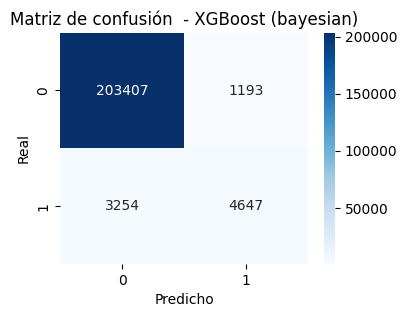

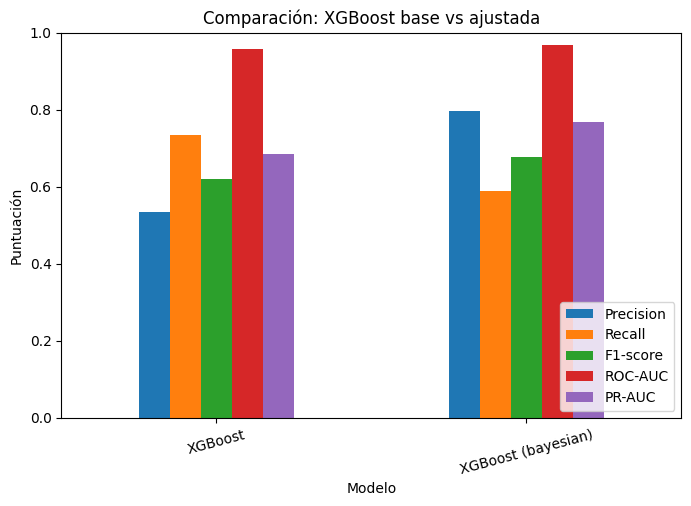

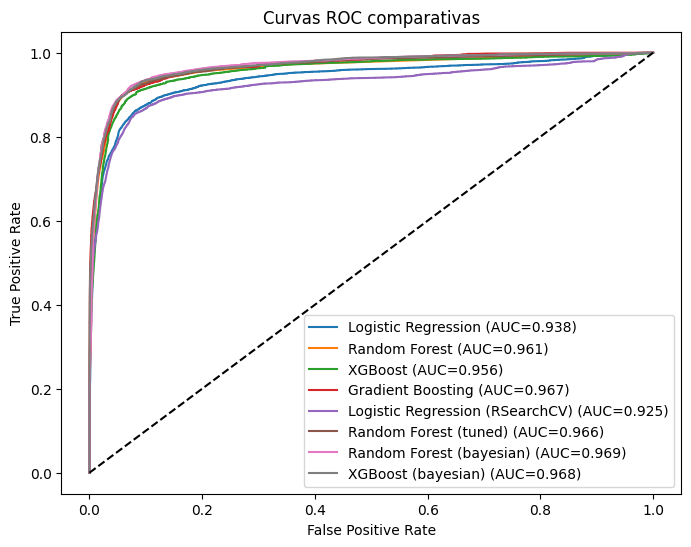

Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
2             XGBoost  0.966367   0.534766  0.733958  0.618725  0.956497   
7  XGBoost (bayesian)  0.979073   0.795719  0.588153  0.676370  0.968194   

     PR-AUC  
2  0.684827  
7  0.768056

In [137]:
#COMPARAR RESULTADOS INICIALES CON RESULTADOS AJUSTADOS - XGBOOST

# Filtrar solo las dos versiones del modelo
df_comp = df_results4[df_results4['Modelo'].str.contains("XGBoost")]

# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión  - {nombre}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Graficar métricas clave
df_comp.set_index('Modelo')[['Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC']].plot(kind='bar', figsize=(8,5))
plt.title("Comparación: XGBoost base vs ajustada")
plt.ylabel("Puntuación")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()

df_comp

#### Conclusiones de la comparación

La optimización bayesiana permitió encontrar un conjunto de hiperparámetros que mejoran, en algunos aspectos, la capacidad predictiva del modelo.

1. Precisión (Precision): Se incrementó significativamente de 0.53 a 0.79. El modelo optimizado reduce falsos positivos, generando predicciones más confiables.

2. Recall (Sensibilidad): Disminuyó de 0.73 a 0.59. El modelo se volvió más conservador, prefiriendo asegurar sus predicciones antes que detectar todos los casos positivos.

3. F1-score: Aumentó de 0.618 a 0.676. Mejora el equilibrio entre precisión y sensibilidad, reflejando un rendimiento más coherente y estable.

4. ROC-AUC: Pasó de 0.956 a 0.968. El modelo optimizado distingue mejor entre clases a lo largo de todos los umbrales de decisión.

5. Accuracy: Subió de 0.966 a 0.979. El modelo generaliza mejor y comete menos errores globales.

El nuevo modelo prioriza la precisión, siendo ideal en escenarios donde los falsos positivos tienen un costo alto (por ejemplo, alertas clínicas).


#### 4. Gradient Boosting

##### Ajuste usando RandomizedSearchCV

El ajuste de hiperparámetros se realizará mediante el método RandomizedSearchCV, que selecciona combinaciones de parámetros de forma aleatoria dentro de un rango definido, lo que permite explorar el espacio de búsqueda de manera eficiente sin probar todas las combinaciones posibles.

Encontrar la combinación óptima de hiperparámetros que maximice la métrica evaluada, mediante validación cruzada por grupos (GroupKFold), usando la variable caseid para evitar fugas de información entre cirugías de un mismo paciente.

**Pasos realizados:**

1. Definición del espacio de búsqueda de hiperparámetros usando los parámetros más influyentes:
    - n_estimators: [100, 200, 300]
    - learning_rate: [0.01, 0.05, 0.1]
    - max_depth: [3, 4, 5]
    - min_samples_split: [2, 5, 10]
    - min_samples_leaf: [1, 3, 5]
    - subsample': [0.8, 1.0]

2. Validación cruzada agrupada: Se utilizó GroupKFold(n_splits=5) para asegurar que los datos de una misma cirugía no se repitieran entre las particiones de entrenamiento y validación.

3. Criterio de evaluación: La métrica empleada fue ROC-AUC, ideal para problemas de clasificación desbalanceada como la predicción de hipoxemia.

4. Configuración del proceso de búsqueda: Se configuró RandomizedSearchCV con n_iter=20 para evaluar 20 combinaciones aleatorias de parámetros, balanceando cobertura y tiempo de cómputo.

5. Entrenamiento final del modelo: Se reentrena el modelo Gradient Boosting utilizando los hiperparámetros óptimos obtenidos y se evalúa en el conjunto de prueba.

In [ ]:

# Definir el modelo base
gb_clf = GradientBoostingClassifier(random_state=42)

# Definir el espacio de hiperparámetros
param_distributions = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_depth': [3, 4, 5],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 3, 5],
    'clf__subsample': [0.8, 1.0]
}

# Crear pipeline con preprocesador
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', gb_clf)
])

# Configurar validación cruzada agrupada
cv = GroupKFold(n_splits=5)

# Configurar búsqueda aleatoria de hiperparámetros
random_search_gb = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=param_distributions,
    n_iter=20,                     
    cv=cv,
    scoring='roc_auc',             
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Ejecutar búsqueda
random_search_gb.fit(X_train, y_train, groups=caseids_train)

print(" Mejores hiperparámetros encontrados:")
for k, v in random_search_gb.best_params_.items():
    print(f"  {k}: {v}")

print(f"\n Mejor ROC-AUC promedio (validación): {random_search_gb.best_score_:.5f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END clf__learning_rate=0.1, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=5, clf__n_estimators=100, clf__subsample=0.8; total time=21.9min
[CV] END clf__learning_rate=0.1, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=5, clf__n_estimators=100, clf__subsample=0.8; total time=22.0min
[CV] END clf__learning_rate=0.1, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=5, clf__n_estimators=100, clf__subsample=0.8; total time=22.1min
[CV] END clf__learning_rate=0.1, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=5, clf__n_estimators=100, clf__subsample=0.8; total time=22.2min
[CV] END clf__learning_rate=0.1, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=5, clf__n_estimators=100, clf__subsample=0.8; total time=22.3min
[CV] END clf__learning_rate=0.05, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=5, clf__n_estimato

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf__learning_rate=0.1, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=300, clf__subsample=1.0; total time=81.1min
[CV] END clf__learning_rate=0.1, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=300, clf__subsample=1.0; total time=77.8min
[CV] END clf__learning_rate=0.1, clf__max_depth=4, clf__min_samples_leaf=5, clf__min_samples_split=10, clf__n_estimators=300, clf__subsample=1.0; total time=78.0min
[CV] END clf__learning_rate=0.1, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=300, clf__subsample=0.8; total time=79.5min
[CV] END clf__learning_rate=0.1, clf__max_depth=3, clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=300, clf__subsample=0.8; total time=47.7min
[CV] END clf__learning_rate=0.1, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=300, clf__subsample=0.8; total time=76.5min
[CV] END cl

In [138]:

# ENTRENAR MODELO CON LOS MEJORES HIPERPARÁMETROS

#Definir Pipeline
best_gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
        **{k.replace('clf__', ''): v for k, v in random_search_gb.best_params_.items()},
        random_state=42
    ))
])

best_gb_pipeline.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = best_gb_pipeline.predict(X_test)
y_prob = best_gb_pipeline.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

nombre= "Gradient Boosting (tuned)"

metricsgb = {
    "Modelo": nombre,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc,
    "PR-AUC": pr_auc
}

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves[nombre] = (fpr, tpr, roc_auc)

# Añadir resultados al DataFrame existente
df_results5 = pd.concat([df_results4, pd.DataFrame([metricsgb])], ignore_index=True)

#Mostrar resultados
print(pd.DataFrame([metricsgb]))

                      Modelo  Accuracy  Precision    Recall  F1-score  \
0  Gradient Boosting (tuned)  0.978391    0.75711  0.616631  0.679688   

    ROC-AUC    PR-AUC  
0  0.969115  0.753927  


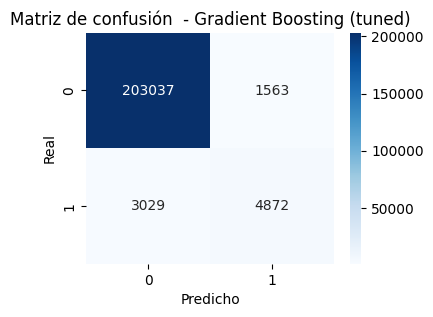

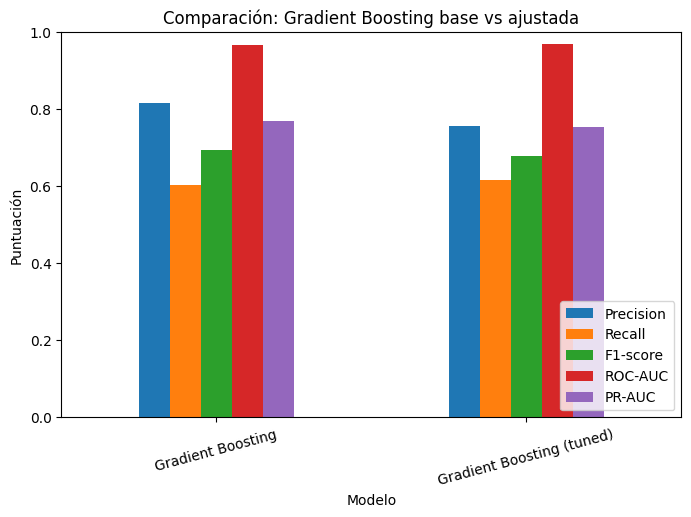

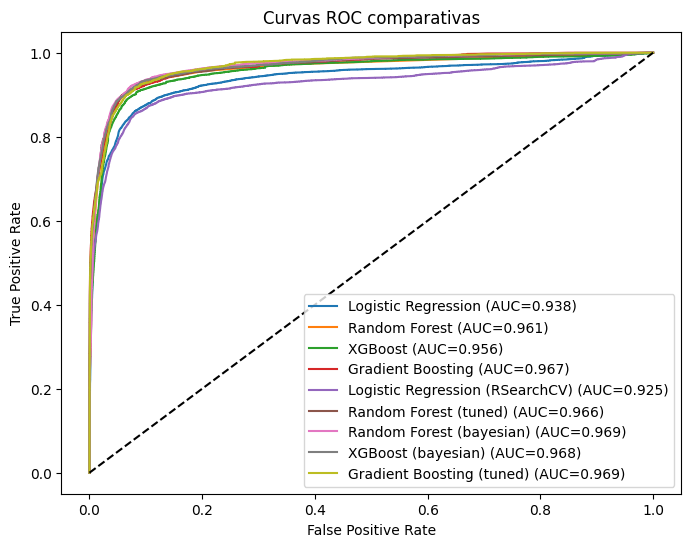

Modelo  Accuracy  Precision    Recall  F1-score  \
3          Gradient Boosting  0.980179    0.81611  0.602709  0.693361   
8  Gradient Boosting (tuned)  0.978391    0.75711  0.616631  0.679688   

    ROC-AUC    PR-AUC  
3  0.967324  0.770747  
8  0.969115  0.753927

In [139]:
#COMPARAR RESULTADOS INICIALES CON RESULTADOS AJUSTADOS

# Filtrar solo las dos versiones del modelo
df_comp = df_results5[df_results5['Modelo'].str.contains("Gradient Boosting")]

# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión  - {nombre}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Graficar métricas clave
df_comp.set_index('Modelo')[['Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC']].plot(kind='bar', figsize=(8,5))
plt.title("Comparación: Gradient Boosting base vs ajustada")
plt.ylabel("Puntuación")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()

df_comp

#### Conclusiones de la comparación

El modelo ajustado logra una ligera mejora en la sensibilidad y en el área bajo la curva ROC, sin sacrificar de manera significativa la precisión global.

En cambio, el modelo original se muestra más conservador, pues genera menos falsos positivos, pero también pierde algunos casos verdaderos de hipoxemia.

1. Accuracy (Exactitud global). Disminuye marginalmente de 0.9802 a 0.9784, una diferencia mínima que no implica una pérdida relevante en el desempeño global.

2. Precisión (Precision): Disminuye de 0.8161 a 0.7571, lo que significa que el modelo ajustado produce más falsos positivos que el inicial.

3. Sensibilidad o Recall. Aumenta ligeramente de 0.6027 a 0.6166, indicando que el modelo ajustado detecta más episodios reales de hipoxemia. Esta mejora puede ser importante porque no omitir eventos críticos tiene más valor que reducir falsas alarmas.

4. F1-score. Baja levemente de 0.6934 a 0.6797, lo que refleja una ligera pérdida de equilibrio entre precisión y sensibilidad. La diferencia es pequeña, lo que sugiere que el modelo ajustado mantiene un rendimiento similar, pero con una leve inclinación hacia mayor recall.

5. ROC-AUC. Mejora de 0.9673 a 0.9691, un cambio pequeño pero positivo. Esto indica que el modelo ajustado discrimina mejor entre clases a lo largo de todos los umbrales de decisión posibles.

En un contexto clínico, donde detectar un episodio real de hipoxemia es más importante que emitir algunas alertas falsas, el modelo ajustado podría considerarse más útil.

Sin embargo, si el objetivo fuera minimizar las falsas alarmas, el modelo inicial seguiría siendo una mejor opción.

En términos generales, ambos modelos muestran un muy buen rendimiento y muy estable, con un AUC cercano a 0.97.

#### Optimizacion Bayesiana

In [140]:
from sklearn.metrics import average_precision_score, make_scorer

# Definir función objetivo

def objective(trial):
    # Definir el rango de búsqueda para cada hiperparámetro
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }

    # Definir el pipeline
    gb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', GradientBoostingClassifier(**params, random_state=42))
    ])

    # Validación cruzada agrupada (por cirugía)
    cv = GroupKFold(n_splits=3)

    # Calcular PR-AUC promedio en CV
    scores = cross_val_score(
        gb_pipeline,
        X_train, y_train,
        cv=cv,
        groups=caseids_train,
        scoring=make_scorer(average_precision_score)
    )
    return scores.mean()


# Crear y ejecutar el estudio

studygb = optuna.create_study(direction='maximize', study_name='GradientBoosting_Bayesian')
studygb.optimize(objective, n_trials=30, show_progress_bar=True)

# ==============================
# Mostrar los mejores resultados
# ==============================
print("Mejores hiperparámetros encontrados:")
for k, v in studygb.best_params.items():
    print(f"  {k}: {v}")

print(f"\nMejor PR-AUC promedio: {studygb.best_value:.5f}")


[I 2025-10-16 21:48:04,809] A new study created in memory with name: GradientBoosting_Bayesian


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-16 23:14:02,138] Trial 0 finished with value: 0.3466805957099945 and parameters: {'n_estimators': 241, 'learning_rate': 0.003373917138983997, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 2, 'subsample': 0.5390672249668685}. Best is trial 0 with value: 0.3466805957099945.
[I 2025-10-17 00:00:59,017] Trial 1 finished with value: 0.030793867219370413 and parameters: {'n_estimators': 155, 'learning_rate': 0.002383996553803984, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3, 'subsample': 0.5096057208218094}. Best is trial 0 with value: 0.3466805957099945.
[I 2025-10-17 02:21:45,775] Trial 2 finished with value: 0.38364165290360824 and parameters: {'n_estimators': 286, 'learning_rate': 0.007140116940640723, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 7, 'subsample': 0.7611866734998323}. Best is trial 2 with value: 0.38364165290360824.
[I 2025-10-17 03:34:16,416] Trial 3 finished with value: 0.3960501853360105 and parameters: {'n_est

In [141]:
# ENTRENAR EL MODELO FINAL CON LOS MEJORES PARÁMETROS
best_gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
        **studygb.best_params,
        random_state=42
    ))
])

best_gb_pipeline.fit(X_train, y_train)

# Predicciones
y_pred = best_gb_pipeline.predict(X_test)
y_prob = best_gb_pipeline.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

nombre= "Gradient Boosting (bayesian)"

metricsgb2 = {
    "Modelo": nombre,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc,
    "PR-AUC":pr_auc
}

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves[nombre] = (fpr, tpr, roc_auc)

# Añadir resultados
df_results6 = pd.concat([df_results5, pd.DataFrame([metricsgb2])], ignore_index=True)

#Mostrar resultados
print(pd.DataFrame([metricsgb2]))


                         Modelo  Accuracy  Precision    Recall  F1-score  \
0  Gradient Boosting (bayesian)  0.980231   0.821404  0.598405  0.692392   

    ROC-AUC    PR-AUC  
0  0.967405  0.767368  


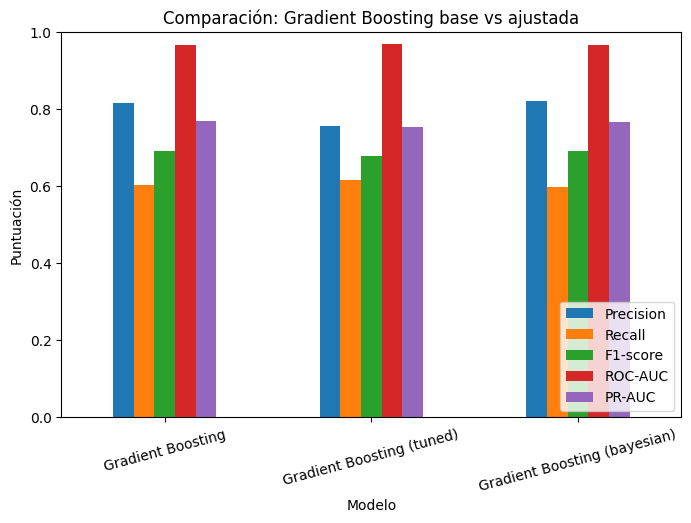

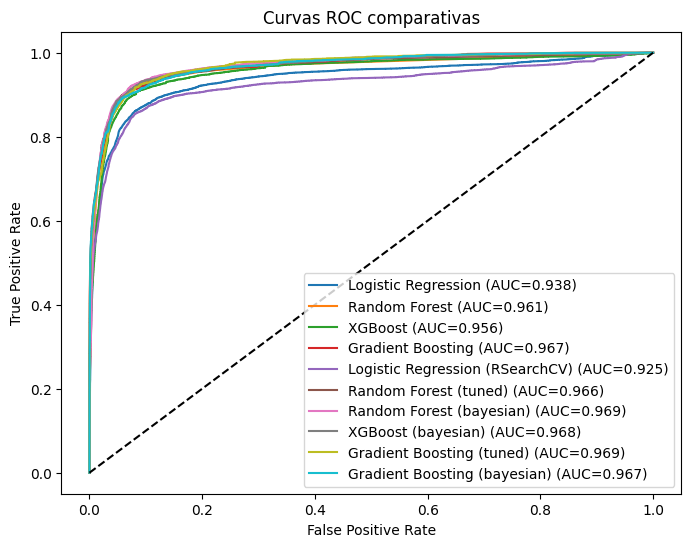

Modelo  Accuracy  Precision    Recall  F1-score  \
3             Gradient Boosting  0.980179   0.816110  0.602709  0.693361   
8     Gradient Boosting (tuned)  0.978391   0.757110  0.616631  0.679688   
9  Gradient Boosting (bayesian)  0.980231   0.821404  0.598405  0.692392   

    ROC-AUC    PR-AUC  
3  0.967324  0.770747  
8  0.969115  0.753927  
9  0.967405  0.767368

In [284]:
#COMPARAR RESULTADOS INICIALES CON RESULTADOS AJUSTADOS

# Filtrar solo las dos versiones del modelo
df_comp6 = df_results6[df_results6['Modelo'].str.contains("Gradient Boosting")]

# === MATRIZ DE CONFUSIÓN ===
#cm = confusion_matrix(y_test, y_pred)
#plt.figure(figsize=(4,3))
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
#plt.title(f"Matriz de confusión  - {nombre}")
#plt.xlabel("Predicho")
#plt.ylabel("Real")
#plt.show()

# Graficar métricas clave
df_comp6.set_index('Modelo')[['Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC']].plot(kind='bar', figsize=(8,5))
plt.title("Comparación: Gradient Boosting base vs ajustada")
plt.ylabel("Puntuación")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()

df_comp6

In [ ]:
# Resultados finales comparativos de los modelos con diferentes valores de hiperparámetros
df_results6

Modelo  Accuracy  Precision    Recall  F1-score  \
0              Logistic Regression  0.906772   0.267945  0.870270  0.409737   
1                    Random Forest  0.974033   0.832172  0.377800  0.519673   
2                          XGBoost  0.966367   0.534766  0.733958  0.618725   
3                Gradient Boosting  0.980179   0.816110  0.602709  0.693361   
4  Logistic Regression (RSearchCV)  0.975821   0.813336  0.453867  0.582616   
5            Random Forest (tuned)  0.978250   0.762614  0.602582  0.673218   
6         Random Forest (bayesian)  0.974570   0.642377  0.712948  0.675825   
7               XGBoost (bayesian)  0.979073   0.795719  0.588153  0.676370   
8        Gradient Boosting (tuned)  0.978391   0.757110  0.616631  0.679688   
9     Gradient Boosting (bayesian)  0.980231   0.821404  0.598405  0.692392   

    ROC-AUC    PR-AUC  
0  0.938322  0.632201  
1  0.961412  0.711040  
2  0.956497  0.684827  
3  0.967324  0.770747  
4  0.924990  0.648566  
5  0.965781  0.750397  
6  0.968502  0.724411  
7  0.968194  0.768056  
8  0.969115  0.753927  
9  0.967405  0.767368

## Entrenamientos con mejores hiperparámetros y cambios en los dataset

Tengo nuevos datasets con los que quiero hacer puebas. Hice el mismo proceso de preparación de los datos, pero al crear la ventana deslizante cambié el tamaño de esta a 5 minutos y a 10 minutos (originalmente el tamaño era 1 minuto). 

Para esto revisaré los modelos entrenados (Logistic Regression, Random Forest, XGBoost y Grandint Boosting), usaré la mejor combinación de hiperparámetros según las búsquedas realizadas y haré nuevos entrenamientos para observar qué efectos pueden tener en el desempeño los cambios realizados a los datos.

### Logistic Regression

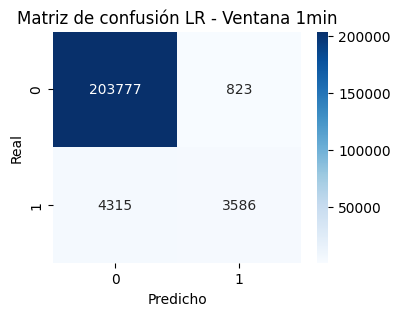


=== Resultados comparativos ===
                Modelo       Version  Accuracy  Precision    Recall  F1-score  \
0  Logistic Regression  Ventana 1min  0.975821   0.813336  0.453867  0.582616   

   ROC-AUC    PR-AUC  
0  0.92499  0.648567  


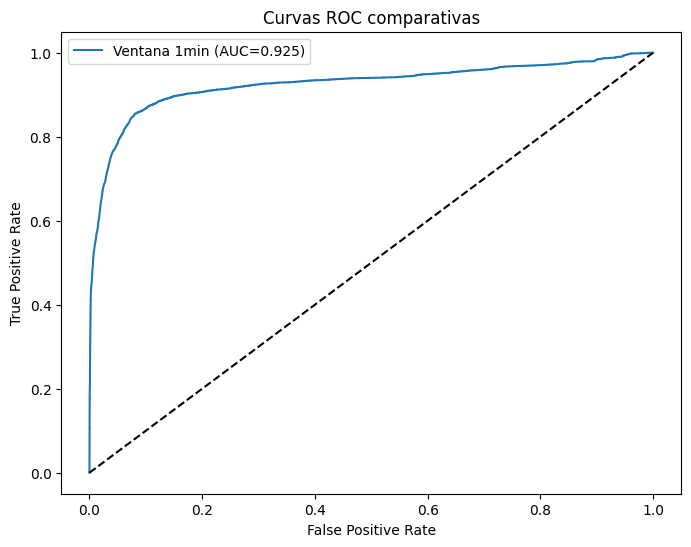

In [ ]:
#ENTRENAMIENTO CON DATOS INICIALES Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated2.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# == FUNCIÓN PARA ENTRENAR EL MODELO ==
results_logreg = []
roc_curves_logreg = {}

def entrenar_modelo(nombre,version,pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Métricas
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)

    results_logreg.append({
        "Modelo": nombre,
        "Version": version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

    # Guardar curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves_logreg[version] = (fpr, tpr, roc_auc)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión LR - {version}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    return pipeline

# == ENTRENAMIENTO DE REGRESIÓN LOGÍSTICA CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 1 MINUTO
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000,class_weight=None,solver='saga',penalty='l1',C=0.00187402236888363))
])

modelologreg= entrenar_modelo("Logistic Regression", "Ventana 1min", logreg_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_logreg = pd.DataFrame(results_logreg)
print("\n=== Resultados comparativos ===")
print(df_results_logreg.sort_values(by="ROC-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_logreg.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas LR")
plt.legend()
plt.show()

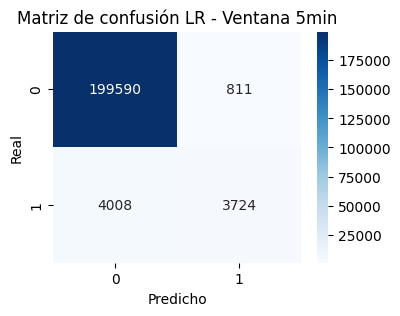


=== Resultados comparativos ===
                Modelo       Version  Accuracy  Precision    Recall  F1-score  \
0  Logistic Regression  Ventana 1min  0.975821   0.813336  0.453867  0.582616   
1  Logistic Regression  Ventana 5min  0.976847   0.821169  0.481635  0.607157   

    ROC-AUC    PR-AUC  
0  0.924990  0.648567  
1  0.938491  0.682213  


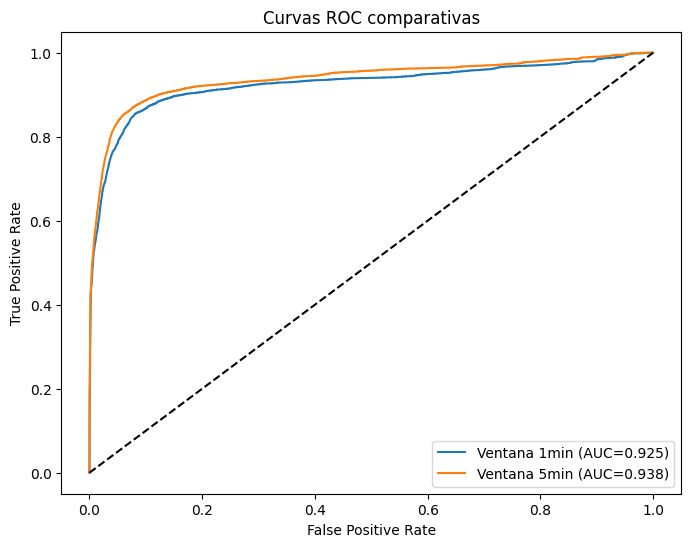

In [ ]:
#ENTRENAMIENTO CON DATOS "Ventana 5 minutos" Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated_5min.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# == ENTRENAMIENTO DE REGRESIÓN LOGÍSTICA CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 5 MINUTOS

modelologreg.fit(X_train, y_train)

y_pred = modelologreg.predict(X_test)
y_prob = modelologreg.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
report = classification_report(y_test, y_pred, digits=3, output_dict=True)

nombre = "Logistic Regression"
version = "Ventana 5min"

results_logreg.append({
        "Modelo": nombre,
        "Version":  version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
 })

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves_logreg[version] = (fpr, tpr, roc_auc)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión LR - {version}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# == Tabla Comparativa de métricas ==
df_results_logreg = pd.DataFrame(results_logreg)
print("\n=== Resultados comparativos ===")
print(df_results_logreg)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_logreg.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas LR")
plt.legend()
plt.show()

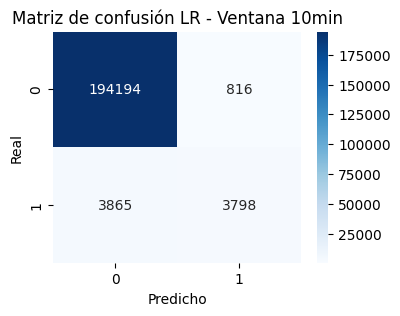


=== Resultados comparativos ===
                Modelo        Version  Accuracy  Precision    Recall  \
0  Logistic Regression   Ventana 1min  0.975821   0.813336  0.453867   
1  Logistic Regression   Ventana 5min  0.976847   0.821169  0.481635   
2  Logistic Regression  Ventana 10min  0.976904   0.823147  0.495628   

   F1-score   ROC-AUC    PR-AUC  
0  0.582616  0.924990  0.648567  
1  0.607157  0.938491  0.682213  
2  0.618718  0.946917  0.698863  


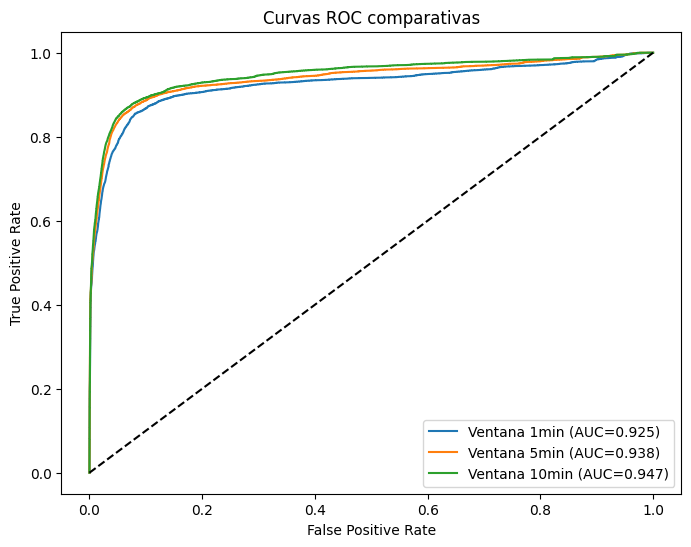

In [ ]:
#ENTRENAMIENTO CON DATOS "Ventana 10 minutos" Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated_10min.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# == ENTRENAMIENTO DE REGRESIÓN LOGÍSTICA CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 10 MINUTOS

modelologreg.fit(X_train, y_train)

y_pred = modelologreg.predict(X_test)
y_prob = modelologreg.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
report = classification_report(y_test, y_pred, digits=3, output_dict=True)

nombre = "Logistic Regression"
version = "Ventana 10min"

results_logreg.append({
        "Modelo": nombre,
        "Version":  version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
 })

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves_logreg[version] = (fpr, tpr, roc_auc)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión LR - {version}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# == Tabla Comparativa de métricas ==
df_results_logreg = pd.DataFrame(results_logreg)
print("\n=== Resultados comparativos ===")
print(df_results_logreg)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_logreg.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas LR")
plt.legend()
plt.show()

Para la Regresión logística, los resultados son levemente mejores con cada aumento del tamaño de la ventana de datos, pero nada drástico

### Random Forest

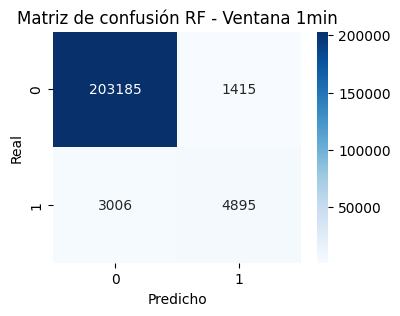


=== Resultados comparativos ===
          Modelo       Version  Accuracy  Precision    Recall  F1-score  \
0  Random Forest  Ventana 1min  0.979195   0.775753  0.619542  0.688903   

    ROC-AUC    PR-AUC  
0  0.970158  0.772986  


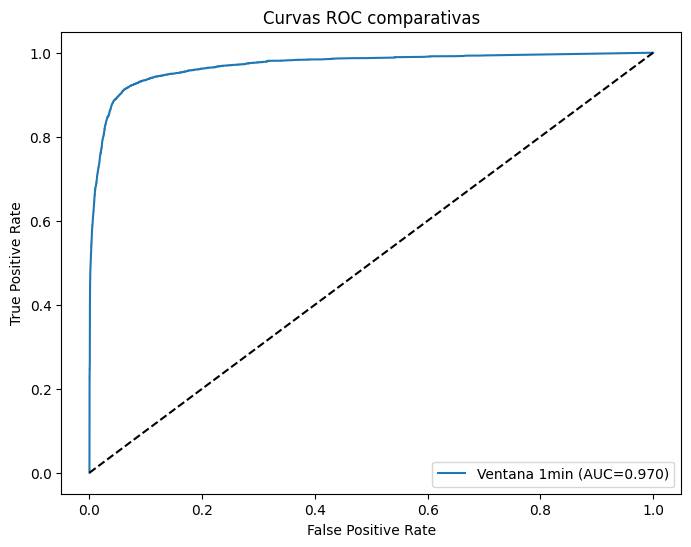

In [ ]:
#ENTRENAMIENTO CON DATOS INICIALES Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated2.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# == FUNCIÓN PARA ENTRENAR EL MODELO ==
results_rforest = []
roc_curves_rforest = {}

def entrenar_modelo(nombre,version,pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Métricas
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)

    results_rforest.append({
        "Modelo": nombre,
        "Version": version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

    # Guardar curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves_rforest[version] = (fpr, tpr, roc_auc)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión RF - {version}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    return pipeline

# == ENTRENAMIENTO DE RANDOM FOREST CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 1 MINUTO
rforest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced',max_depth=None,random_state=42,max_features='log2',
    min_samples_leaf=4,min_samples_split=2,n_estimators=365,criterion='entropy'
))
])

modelorforest = entrenar_modelo("Random Forest", "Ventana 1min", rforest_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_rforest = pd.DataFrame(results_rforest)
print("\n=== Resultados comparativos ===")
print(df_results_rforest)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_rforest.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas RF")
plt.legend()
plt.show()

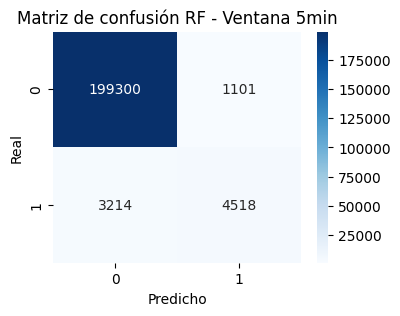


=== Resultados comparativos ===
          Modelo       Version  Accuracy  Precision    Recall  F1-score  \
0  Random Forest  Ventana 1min  0.979195   0.775753  0.619542  0.688903   
1  Random Forest  Ventana 5min  0.979268   0.804058  0.584325  0.676803   
2  Random Forest  Ventana 5min  0.979268   0.804058  0.584325  0.676803   

    ROC-AUC    PR-AUC  
0  0.970158  0.772986  
1  0.971864  0.756435  
2  0.971864  0.756435  


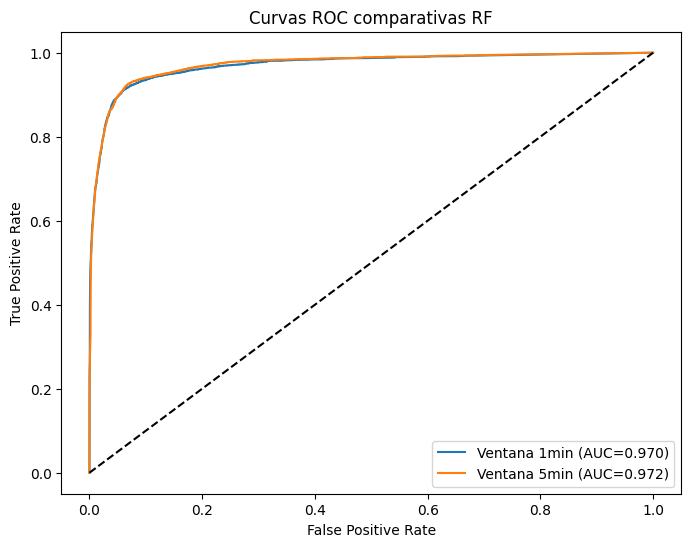

In [ ]:
#ENTRENAMIENTO CON DATOS "Ventana 5 minutos" Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated_5min.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# == ENTRENAMIENTO DE RANDOM FOREST CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 5 MINUTOS
modelorforest.fit(X_train, y_train)

y_pred = modelorforest.predict(X_test)
y_prob = modelorforest.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
report = classification_report(y_test, y_pred, digits=3, output_dict=True)

nombre = "Random Forest"
version = "Ventana 5min"

results_rforest.append({
        "Modelo": nombre,
        "Version": version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
 })

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves_rforest[version] = (fpr, tpr, roc_auc)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión RF - {version}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# == Tabla Comparativa de métricas ==
df_results_rforest = pd.DataFrame(results_rforest)
print("\n=== Resultados comparativos ===")
print(df_results_rforest)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_rforest.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas RF")
plt.legend()
plt.show()

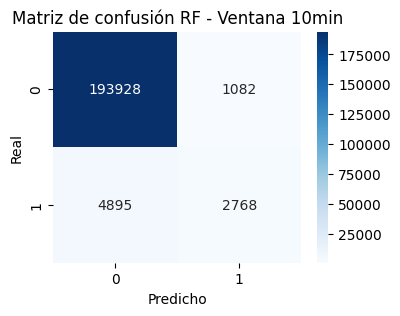


=== Resultados comparativos ===
          Modelo        Version  Accuracy  Precision    Recall  F1-score  \
0  Random Forest   Ventana 1min  0.979195   0.775753  0.619542  0.688903   
1  Random Forest   Ventana 5min  0.979268   0.804058  0.584325  0.676803   
2  Random Forest   Ventana 5min  0.979268   0.804058  0.584325  0.676803   
3  Random Forest  Ventana 10min  0.970509   0.718961  0.361216  0.480848   

    ROC-AUC    PR-AUC  
0  0.970158  0.772986  
1  0.971864  0.756435  
2  0.971864  0.756435  
3  0.967814  0.680892  


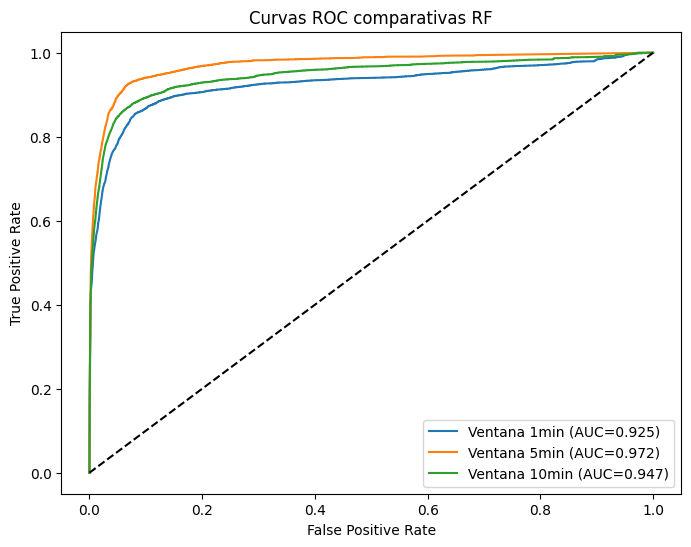

In [ ]:
#ENTRENAMIENTO CON DATOS "Ventana 10 minutos" Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated_10min.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# == ENTRENAMIENTO DE RANDOM FOREST CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 10 MINUTOS
modelorforest.fit(X_train, y_train)

y_pred = modelorforest.predict(X_test)
y_prob = modelorforest.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
report = classification_report(y_test, y_pred, digits=3, output_dict=True)

nombre = "Random Forest"
version = "Ventana 10min"

results_rforest.append({
        "Modelo": nombre,
        "Version":  version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
 })

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves_rforest["Ventana 10min"] = (fpr, tpr, roc_auc)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión RF - {version}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# == Tabla Comparativa de métricas ==
df_results_rforest = pd.DataFrame(results_rforest)
print("\n=== Resultados comparativos ===")
print(df_results_rforest)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_logreg.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas RF")
plt.legend()
plt.show()

### XGBoost

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:18:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


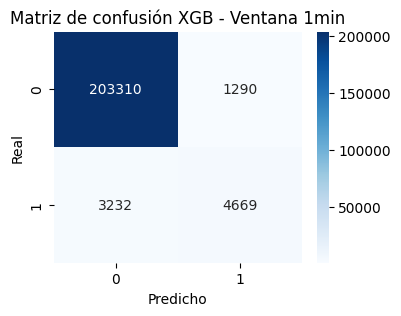


=== Resultados comparativos ===
    Modelo       Version  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
0  XGBoost  Ventana 1min   0.97872   0.783521  0.590938  0.673737  0.969236   

     PR-AUC  
0  0.768352  


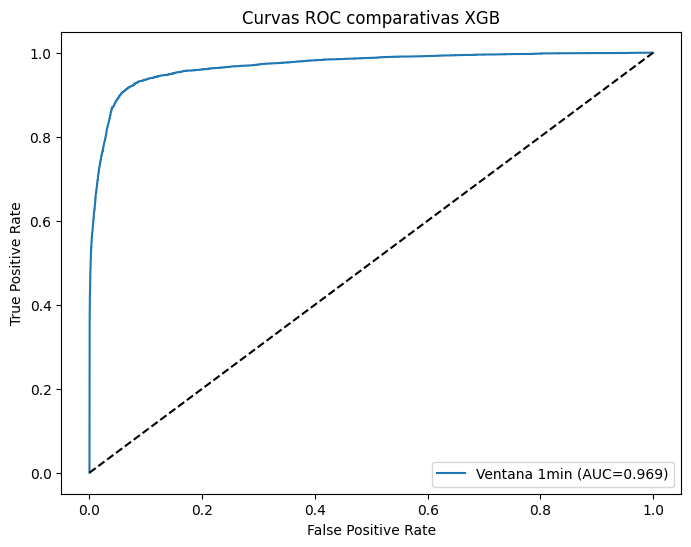

In [ ]:
#ENTRENAMIENTO CON DATOS INICIALES Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated2.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# == FUNCIÓN PARA ENTRENAR EL MODELO ==
results_xgboost = []
roc_curves_xgboost = {}

def entrenar_modelo(nombre,version,pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Métricas
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)

    results_xgboost.append({
        "Modelo": nombre,
        "Version": version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

    # Guardar curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves_xgboost[version] = (fpr, tpr, roc_auc)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión XGB - {version}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    return pipeline

# == ENTRENAMIENTO DE XGBOOST CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 1 MINUTO
xgboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
    n_estimators=320,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.85,
    gamma=2.5,
    reg_lambda=1.5,
    min_child_weight=12,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    ))
])

modeloxgboost = entrenar_modelo("XGBoost","Ventana 1min", xgboost_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_xgboost = pd.DataFrame(results_xgboost)
print("\n=== Resultados comparativos ===")
print(df_results_xgboost)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_xgboost.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas XGB")
plt.legend()
plt.show()

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:21:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


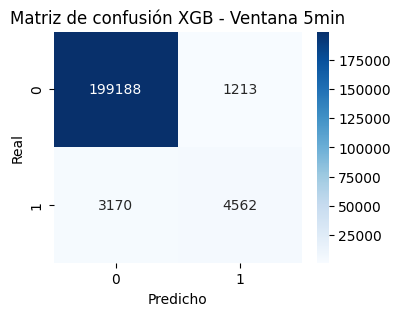


=== Resultados comparativos ===
    Modelo       Version  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
0  XGBoost  Ventana 1min  0.978720   0.783521  0.590938  0.673737  0.969236   
1  XGBoost  Ventana 5min  0.978941   0.789957  0.590016  0.675502  0.971308   

     PR-AUC  
0  0.768352  
1  0.770020  


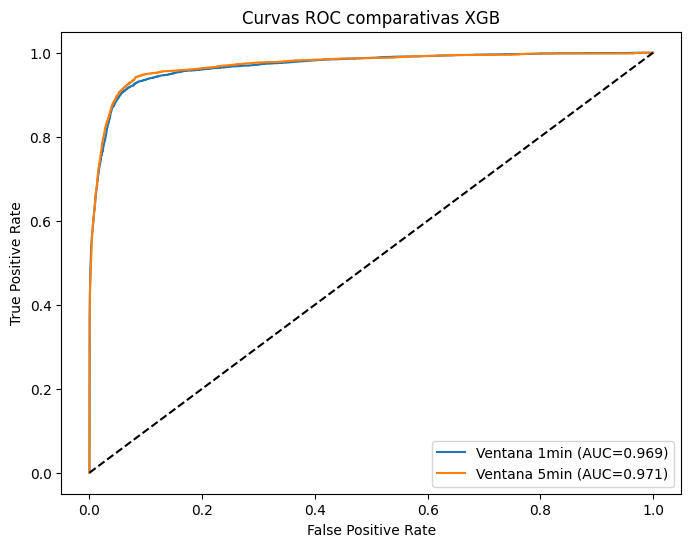

In [ ]:
#ENTRENAMIENTO CON DATOS "Ventana 5 minutos" Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated_5min.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]


# == ENTRENAMIENTO DE XGBOOST CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 5 MINUTOS
modeloxgboost.fit(X_train, y_train)

y_pred = modeloxgboost.predict(X_test)
y_prob = modeloxgboost.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
report = classification_report(y_test, y_pred, digits=3, output_dict=True)

nombre = "XGBoost"
version = "Ventana 5min"

results_xgboost.append({
        "Modelo": nombre,
        "Version":  version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
 })

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves_xgboost[version] = (fpr, tpr, roc_auc)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión XGB - {version}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# == Tabla Comparativa de métricas ==
df_results_xgboost = pd.DataFrame(results_xgboost)
print("\n=== Resultados comparativos ===")
print(df_results_xgboost)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_xgboost.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas XGB")
plt.legend()
plt.show()


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:26:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


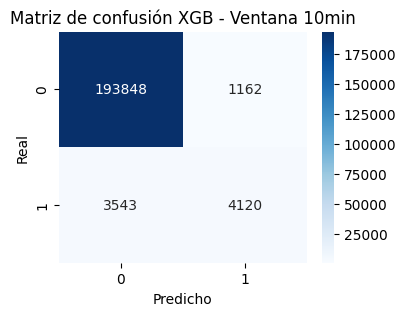


=== Resultados comparativos ===
    Modelo        Version  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
0  XGBoost   Ventana 1min  0.978720   0.783521  0.590938  0.673737  0.969236   
1  XGBoost   Ventana 5min  0.978941   0.789957  0.590016  0.675502  0.971308   
2  XGBoost  Ventana 10min  0.976785   0.780008  0.537648  0.636539  0.971588   

     PR-AUC  
0  0.768352  
1  0.770020  
2  0.743786  


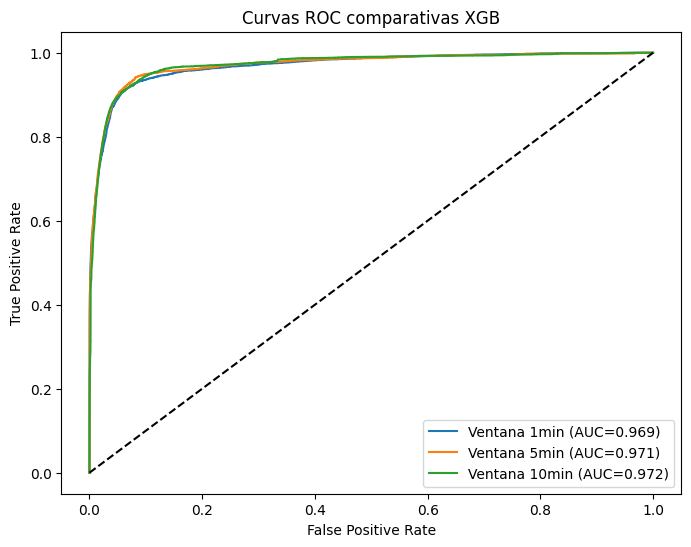

In [ ]:
#ENTRENAMIENTO CON DATOS "Ventana 10 minutos" Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated_10min.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]


# == ENTRENAMIENTO DE XGBOOST CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 10 MINUTOS
modeloxgboost.fit(X_train, y_train)

y_pred = modeloxgboost.predict(X_test)
y_prob = modeloxgboost.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
report = classification_report(y_test, y_pred, digits=3, output_dict=True)

nombre = "XGBoost"
version = "Ventana 10min"

results_xgboost.append({
        "Modelo": nombre,
        "Version":  version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
 })

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves_xgboost[version] = (fpr, tpr, roc_auc)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión XGB - {version}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# == Tabla Comparativa de métricas ==
df_results_xgboost = pd.DataFrame(results_xgboost)
print("\n=== Resultados comparativos ===")
print(df_results_xgboost)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_xgboost.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas XGB")
plt.legend()
plt.show()


### Gradient Boosting

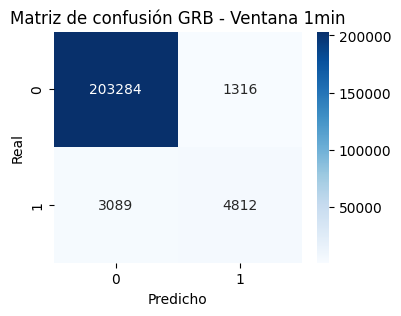


=== Resultados comparativos ===
              Modelo       Version  Accuracy  Precision    Recall  F1-score  \
0  Gradient Boosting  Ventana 1min  0.979271   0.785248  0.609037  0.686008   

    ROC-AUC    PR-AUC  
0  0.968113  0.768253  


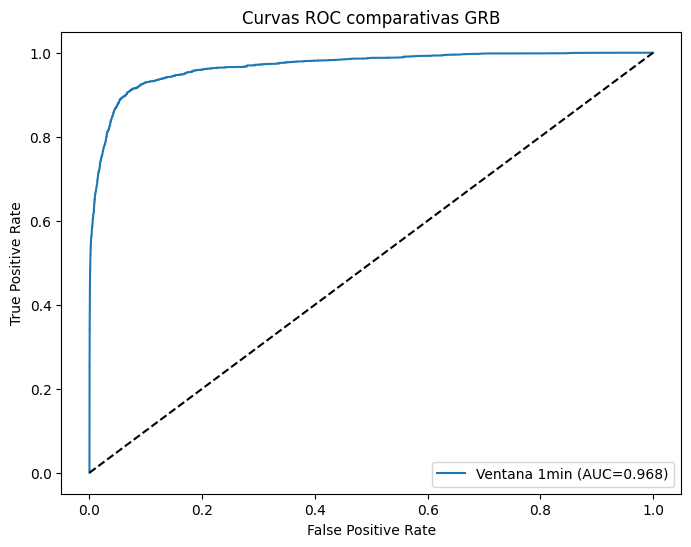

In [ ]:
#ENTRENAMIENTO CON DATOS INICIALES Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated2.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]

# == FUNCIÓN PARA ENTRENAR EL MODELO ==
results_gradb = []
roc_curves_gradb = {}

def entrenar_modelo(nombre,version,pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Métricas
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)

    results_gradb.append({
        "Modelo": nombre,
        "Version": version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

    # Guardar curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves_gradb[version] = (fpr, tpr, roc_auc)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión GRB - {version}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    return pipeline

# == ENTRENAMIENTO DE GRADIENT BOOSTING CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 1 MINUTO
gradb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
    subsample=1,
    n_estimators=149,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=3,
    max_features=None,
    criterion='friedman_mse',
    loss='log_loss',
    learning_rate=0.1,
    random_state=42))
])

modelogboosting = entrenar_modelo("Gradient Boosting","Ventana 1min", gradb_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_gradb = pd.DataFrame(results_gradb)
print("\n=== Resultados comparativos ===")
print(df_results_gradb)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_gradb.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas GRB")
plt.legend()
plt.show()

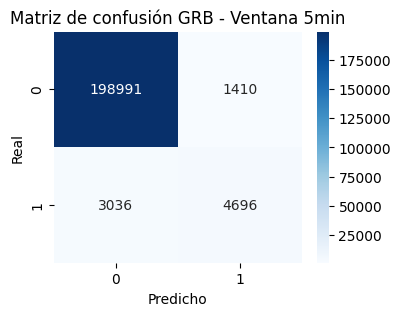


=== Resultados comparativos ===
              Modelo       Version  Accuracy  Precision    Recall  F1-score  \
0  Gradient Boosting  Ventana 1min  0.979271   0.785248  0.609037  0.686008   
1            XGBoost  Ventana 5min  0.978639   0.769080  0.607346  0.678711   

    ROC-AUC    PR-AUC  
0  0.968113  0.768253  
1  0.970629  0.737969  


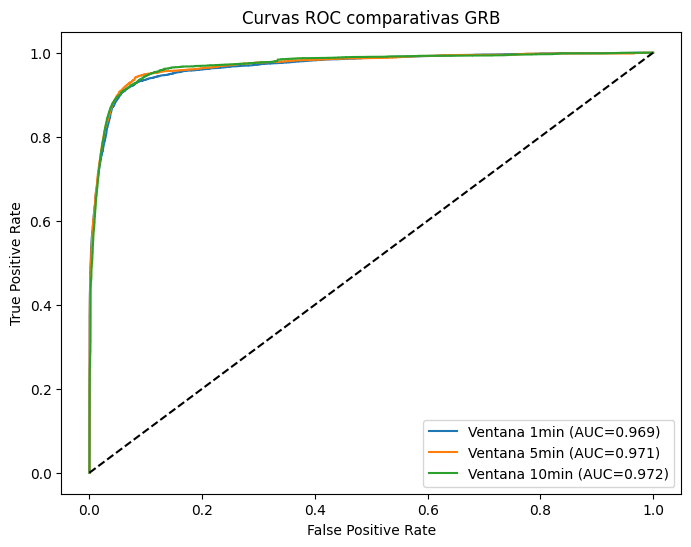

In [ ]:
#ENTRENAMIENTO CON DATOS "Ventana 5 minutos" Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated_5min.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]


# == ENTRENAMIENTO DE GRADIENT BOOSTING CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 5 MINUTOS
modelogboosting.fit(X_train, y_train)

y_pred = modelogboosting.predict(X_test)
y_prob = modelogboosting.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
report = classification_report(y_test, y_pred, digits=3, output_dict=True)

nombre = "XGBoost"
version = "Ventana 5min"

results_gradb.append({
        "Modelo": nombre,
        "Version":  version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
 })

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves_gradb[version] = (fpr, tpr, roc_auc)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión GRB - {version}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# == Tabla Comparativa de métricas ==
df_results_gradb = pd.DataFrame(results_gradb)
print("\n=== Resultados comparativos ===")
print(df_results_gradb)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_gradb.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas GRB")
plt.legend()
plt.show()


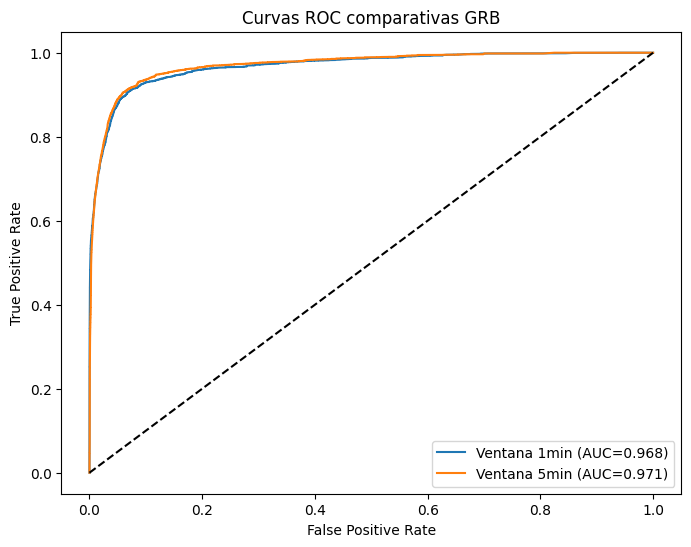

In [216]:
# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_gradb.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas GRB")
plt.legend()
plt.show()

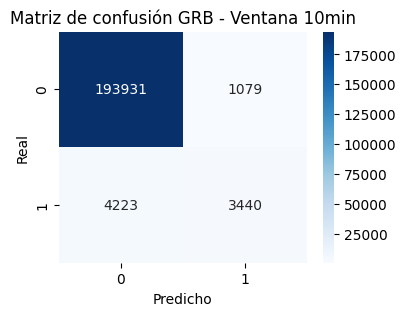


=== Resultados comparativos ===
              Modelo        Version  Accuracy  Precision    Recall  F1-score  \
0  Gradient Boosting   Ventana 1min  0.979271   0.785248  0.609037  0.686008   
1            XGBoost   Ventana 5min  0.978639   0.769080  0.607346  0.678711   
2            XGBoost  Ventana 10min  0.973840   0.761230  0.448910  0.564768   

    ROC-AUC    PR-AUC  
0  0.968113  0.768253  
1  0.970629  0.737969  
2  0.968319  0.701594  


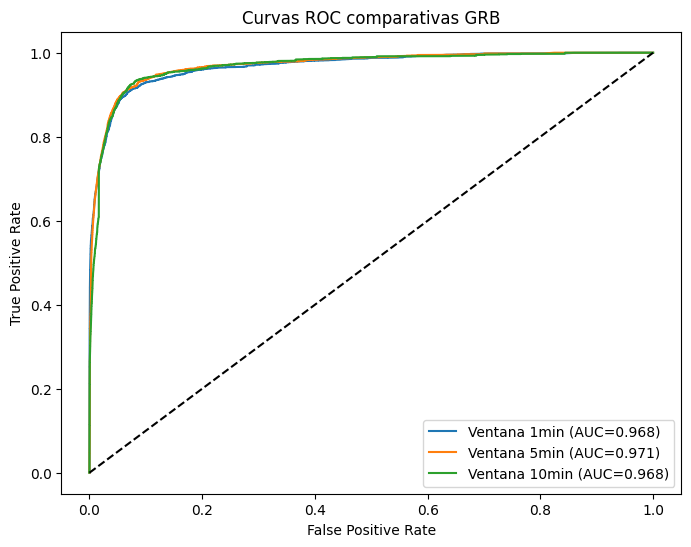

In [ ]:
#ENTRENAMIENTO CON DATOS "Ventana 10 minutos" Y MEJORES HIPERPARÁMETROS

# CARGAR DATOS DE LOS DATOS
df = pd.read_parquet("windows_output/windows_aggregated_10min.parquet")
X = df.drop(columns=["label_hypoxemia", "caseid"])   # caseid no debe usarse como feature
y = df["label_hypoxemia"]

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# == SPLIT train/test POR CIRUGÍA ==
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

X_train = df[df["caseid"].isin(train_cir)].drop(columns=["label_hypoxemia","caseid"])
y_train = df[df["caseid"].isin(train_cir)]["label_hypoxemia"]

X_test  = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test  = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

# Guardar los grupos
caseids_train = df[df["caseid"].isin(train_cir)]["caseid"]
caseids_test  = df[df["caseid"].isin(test_cir)]["caseid"]


# == ENTRENAMIENTO DE GRADIENT BOOSTING CON MEJOR COMBINACIÓN DE HIPERPARÁMETROS ==
# VENTANA DE DATOS DE 10 MINUTOS
modelogboosting.fit(X_train, y_train)

y_pred = modelogboosting.predict(X_test)
y_prob = modelogboosting.predict_proba(X_test)[:, 1]

# Métricas
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
report = classification_report(y_test, y_pred, digits=3, output_dict=True)

nombre = "XGBoost"
version = "Ventana 10min"

results_gradb.append({
        "Modelo": nombre,
        "Version":  version,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
 })

# Guardar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_curves_gradb[version] = (fpr, tpr, roc_auc)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión GRB - {version}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# == Tabla Comparativa de métricas ==
df_results_gradb = pd.DataFrame(results_gradb)
print("\n=== Resultados comparativos ===")
print(df_results_gradb)

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for version, (fpr, tpr, auc) in roc_curves_gradb.items():
    plt.plot(fpr, tpr, label=f"{version} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas GRB")
plt.legend()
plt.show()


La conclusión de estas pruebas es que el cambio en el tamaño de las ventanas no afecta de la misma manera a todos los modelos. En la Regresión Logística fue más evidente que a mayor tamaño de la ventana mejores resultados en las métricas. Sin embargo en los otros modelos esta relación no fue consistente. Algunos mejoraban con la ventana de 5 minutos y empeoraban con la de 10.

Esto me hace inclinarme hacia el tamaño de 5 minutos como tamaño elegido de ventana de datos, pues entrega al modelo más cantidad de información y promueve mejores resultados en las métricas.

## Estrategia para manejar desbalanceo de las clases

### Undersampling parcial clase mayoritaria

Aunque en el entrenamiento de cada modelo se utilizaron hiperparámetros destinados a manejar el desbalanceo de las clases, voy a implementar un Undersampling parcial como estrategia adicional. Buscaré pasar de una proporción 3%-97% a una 10%-90%, para generar un nuevo dataset de entrenamiento y prueba. Todavía hay métricas que siguen siendo muy mediocres y espero que esto las lleve a mejores resultados.

Como dije anteriormente, utilizaré como base los datos preparados con ventanas de 5 minutos y sobre ellos aplicaré las técnicas de Undersampling

In [ ]:
# === CARGAR DATOS ===
df = pd.read_parquet("windows_output/windows_aggregated_5min.parquet")

# Separar variables y etiquetas
X = df.drop(columns=["label_hypoxemia", "caseid"])
y = df["label_hypoxemia"]

# === DIVISIÓN train/test POR CIRUGÍA ===
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

train_df = df[df["caseid"].isin(train_cir)].copy()
test_df  = df[df["caseid"].isin(test_cir)].copy()

# === CONFIGURACIÓN ===
target_ratio = 0.10  # proporción deseada de positivos (10%)
random_state = 42

# === Calcular proporción actual ===
total_pos = train_df["label_hypoxemia"].sum()
total_neg = len(train_df) - total_pos
current_ratio = total_pos / (total_pos + total_neg)
print(f"📊 Proporción actual de positivos: {current_ratio:.2%}")

# === Identificar cirugías positivas y negativas ===
cirugias_pos = train_df.groupby("caseid")["label_hypoxemia"].max()
cirugias_pos = cirugias_pos[cirugias_pos == 1].index

cirugias_neg = train_df.groupby("caseid")["label_hypoxemia"].max()
cirugias_neg = cirugias_neg[cirugias_neg == 0].index

print(f"🔹 Cirugías positivas: {len(cirugias_pos)}")
print(f"🔹 Cirugías negativas: {len(cirugias_neg)}")

# === Submuestreo por cirugías completas (fase 1) ===
# Estimamos cuántas cirugías negativas mantener para acercarnos a la proporción objetivo
neg_target_global = int(total_pos * (1 - target_ratio) / target_ratio)
neg_per_cirugia = train_df[train_df["label_hypoxemia"] == 0].groupby("caseid").size()
cum_neg = neg_per_cirugia.cumsum() / neg_per_cirugia.sum()

# Eliminamos cirugías negativas completas si sobran demasiados negativos
n_cirugias_a_mantener = min(len(cirugias_neg), int(len(cirugias_neg) * (target_ratio / current_ratio)))
cirugias_neg_keep = pd.Series(cirugias_neg).sample(n=n_cirugias_a_mantener, random_state=random_state)

# Subconjunto inicial con todas las cirugías positivas y las negativas seleccionadas
subset_df = train_df[train_df["caseid"].isin(cirugias_pos.union(cirugias_neg_keep))].copy()

# === Verificar proporción después del primer filtro ===
pos_count = subset_df["label_hypoxemia"].sum()
neg_count = len(subset_df) - pos_count
print(f"\n📉 Tras eliminar cirugías negativas completas:")
print(f"Positivos: {pos_count} | Negativos: {neg_count} | Ratio positivo: {pos_count/(pos_count+neg_count):.2%}")

# === Submuestreo dentro de las cirugías negativas restantes (fase 2) ===
# Si aún hay demasiados negativos, reducimos dentro de las cirugías seleccionadas
desired_neg = int(pos_count * (1 - target_ratio) / target_ratio)
if neg_count > desired_neg:
    neg_to_drop = neg_count - desired_neg
    frac_drop = 1 - (desired_neg / neg_count)
    
    print(f"⚙️ Eliminando {frac_drop:.2%} de registros negativos dentro de las cirugías seleccionadas...")
    
    neg_samples = subset_df[subset_df["label_hypoxemia"] == 0]
    neg_keep = neg_samples.sample(frac=(1 - frac_drop), random_state=random_state)
    pos_samples = subset_df[subset_df["label_hypoxemia"] == 1]
    
    subset_df = pd.concat([pos_samples, neg_keep], ignore_index=True)
else:
    print("✅ No se requiere reducción adicional dentro de las cirugías.")

# === Mostrar resultados finales ===
final_pos = subset_df["label_hypoxemia"].sum()
final_neg = len(subset_df) - final_pos
final_ratio = final_pos / (final_pos + final_neg)

print("\n✅ Dataset final balanceado (mixto):")
print(f"Registros positivos: {final_pos}")
print(f"Registros negativos: {final_neg}")
print(f"Proporción final de positivos: {final_ratio:.2%}")
print(f"Tamaño final del dataset: {len(subset_df):,}")

# === Guardar el nuevo dataset ===
#subset_df.to_parquet("windows_output/train_balanced_mixto.parquet", index=False)
#print("\n💾 Dataset balanceado guardado como 'train_balanced_mixto.parquet'")

📊 Proporción actual de positivos: 3.06%
🔹 Cirugías positivas: 498
🔹 Cirugías negativas: 230

📉 Tras eliminar cirugías negativas completas:
Positivos: 24918 | Negativos: 788587 | Ratio positivo: 3.06%
⚙️ Eliminando 71.56% de registros negativos dentro de las cirugías seleccionadas...

✅ Dataset final balanceado (mixto):
Registros positivos: 24918
Registros negativos: 224262
Proporción final de positivos: 10.00%
Tamaño final del dataset: 249,180


In [225]:
X_train = subset_df.drop(columns=["label_hypoxemia", "caseid"])
y_train = subset_df["label_hypoxemia"]

# Mantener el mismo test original
X_test = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]


### Entrenamiento de los modelos con este nuevo dataset

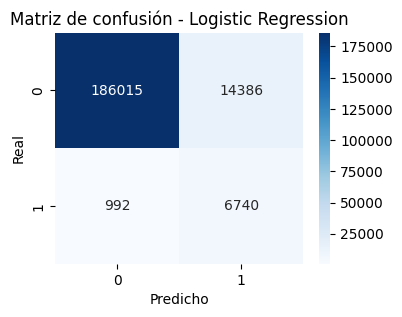


=== Resultados comparativos ===
                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
0  Logistic Regression  0.926115   0.319038  0.871702  0.467115  0.948286   

     PR-AUC  
0  0.641138  


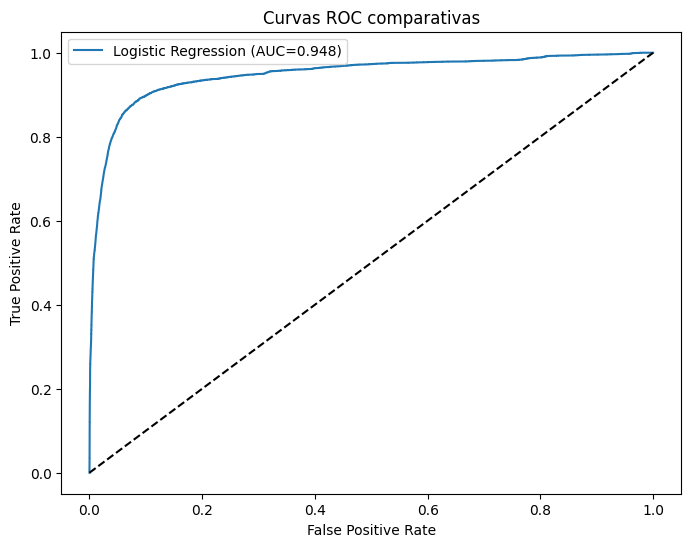

In [240]:
# == ENTRENAMIENTO DE REGRESIÓN LOGÍSTICA con datos Undersampled ==

# == FUNCIÓN PARA ENTRENAR EL MODELO ==
results_Under = []
roc_curves_Under = {}

def entrenar_modelo(nombre,pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Métricas
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)

    results_Under.append({
        "Modelo": nombre,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

    # Guardar curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves_Under[nombre] = (fpr, tpr, roc_auc)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión - {nombre}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    return pipeline

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=2000,class_weight='balanced',solver='saga',penalty='l1',C=0.001))
])

modelologregUnder= entrenar_modelo("Logistic Regression", logreg_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_Under = pd.DataFrame(results_Under)
print("\n=== Resultados comparativos ===")
print(df_results_Under.sort_values(by="PR-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves_Under.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()

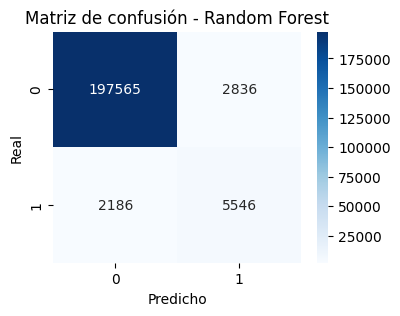


=== Resultados comparativos ===
                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
1        Random Forest  0.975871   0.661656  0.717279  0.688346  0.970961   
2        Random Forest  0.975871   0.661656  0.717279  0.688346  0.970961   
0  Logistic Regression  0.926115   0.319038  0.871702  0.467115  0.948286   

     PR-AUC  
1  0.744486  
2  0.744486  
0  0.641138  


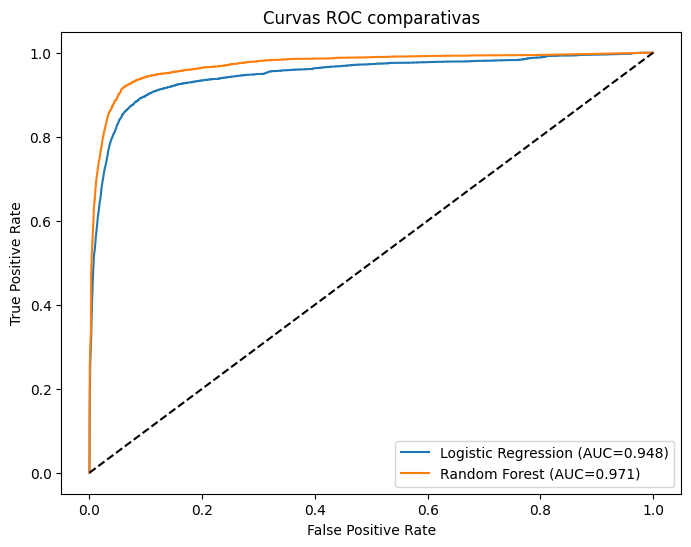

In [ ]:
# == ENTRENAMIENTO DE RANDOM FOREST ==
rforest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced',max_depth=None,random_state=42,max_features='log2',
    min_samples_leaf=4,min_samples_split=2,n_estimators=365,criterion='entropy'
))
])

modelorforest = entrenar_modelo("Random Forest", rforest_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_Under = pd.DataFrame(results_Under)
print("\n=== Resultados comparativos ===")
print(df_results_Under.sort_values(by="PR-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves_Under.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:37:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


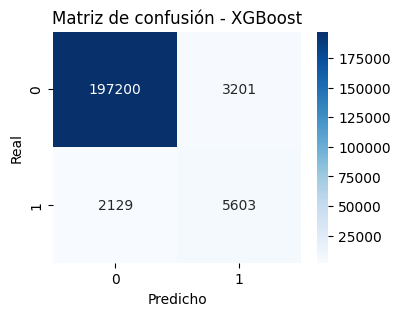


=== Resultados comparativos ===
                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
4              XGBoost  0.974391   0.636415  0.724651  0.677673  0.972767   
3              XGBoost  0.973330   0.620831  0.724651  0.668735  0.972004   
1        Random Forest  0.975871   0.661656  0.717279  0.688346  0.970961   
2        Random Forest  0.975871   0.661656  0.717279  0.688346  0.970961   
0  Logistic Regression  0.926115   0.319038  0.871702  0.467115  0.948286   

     PR-AUC  
4  0.778033  
3  0.769442  
1  0.744486  
2  0.744486  
0  0.641138  


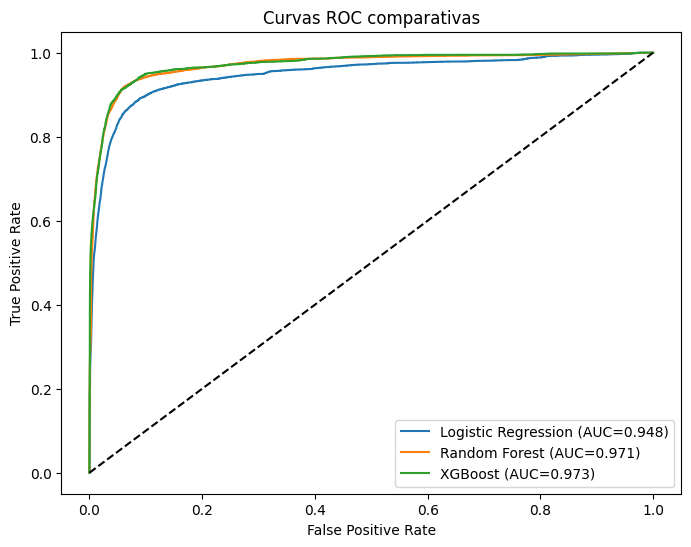

In [ ]:
# == ENTRENAMIENTO DE XGBOOST ==
xgboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
    n_estimators=224,
    max_depth=8,
    learning_rate=0.018305279707247,
    subsample=0.782656644669469,
    colsample_bytree=0.8662956317944550,
    gamma=1.529647033647,
    reg_lambda=1.49064268051789,
    min_child_weight=9,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    ))
])

modeloxgboost = entrenar_modelo("XGBoost", xgboost_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_Under = pd.DataFrame(results_Under)
print("\n=== Resultados comparativos ===")
print(df_results_Under.sort_values(by="PR-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves_Under.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()

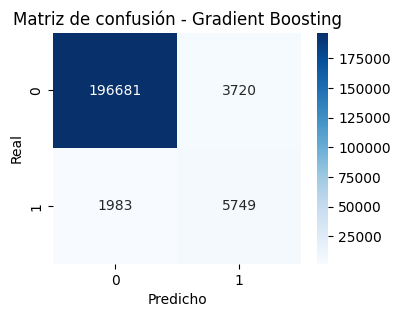


=== Resultados comparativos ===
                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
4              XGBoost  0.974391   0.636415  0.724651  0.677673  0.972767   
6    Gradient Boosting  0.972599   0.607139  0.743533  0.668450  0.972269   
7    Gradient Boosting  0.972599   0.607139  0.743533  0.668450  0.972269   
3              XGBoost  0.973330   0.620831  0.724651  0.668735  0.972004   
5    Gradient Boosting  0.972037   0.599625  0.744180  0.664127  0.971537   
1        Random Forest  0.975871   0.661656  0.717279  0.688346  0.970961   
2        Random Forest  0.975871   0.661656  0.717279  0.688346  0.970961   
0  Logistic Regression  0.926115   0.319038  0.871702  0.467115  0.948286   

     PR-AUC  
4  0.778033  
6  0.772967  
7  0.772967  
3  0.769442  
5  0.768852  
1  0.744486  
2  0.744486  
0  0.641138  


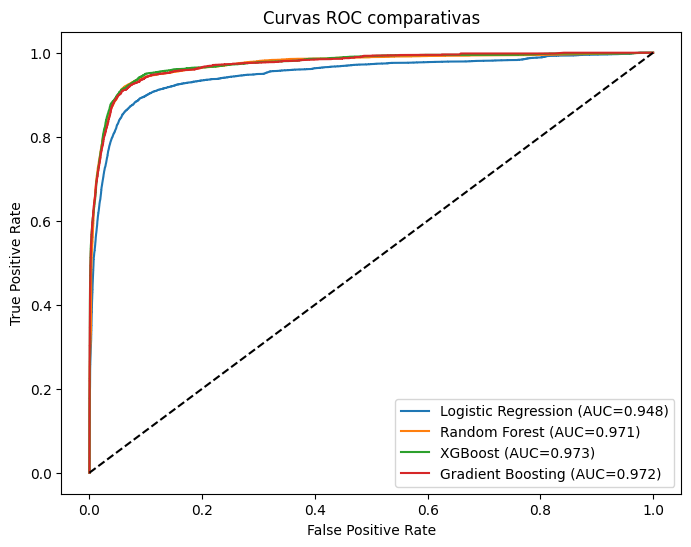

In [247]:
# == ENTRENAMIENTO DE GRADIENT BOOSTING ==
gradb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
    subsample=1,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=3,
    max_features=None,
    criterion='friedman_mse',
    loss='log_loss',
    learning_rate=0.1,
    random_state=42))
])

modelogboosting = entrenar_modelo("Gradient Boosting", gradb_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_Under = pd.DataFrame(results_Under)
print("\n=== Resultados comparativos ===")
print(df_results_Under.sort_values(by="PR-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves_Under.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas")
plt.legend()
plt.show()

Conclusión: NO parece que el proceso de Undersampling mejore el desempeño de los modelos. Voy a intentar un undersampling más aleatorio, sin hacer la división por cirugías, para ver qué pasa.
Sé que hacerlo así tiene el riesgo de romper la coherencia temporal al interior de las cirugías, por ahora quiero ver si mejoran los resultados.
En este submuestreo, lo que quiero es reducir la cantidad de registros de la clase mayoritaria (negativos) a la mitad, e lugar de buscar una proporción exacta entre positivos y negativos.

In [ ]:
# UNDERSAMPLING ALEATORIO

# === CARGAR DATOS ===
df = pd.read_parquet("windows_output/windows_aggregated_5min.parquet")

# Separar variables y etiquetas
X = df.drop(columns=["label_hypoxemia", "caseid"])
y = df["label_hypoxemia"]

# === DIVISIÓN train/test POR CIRUGÍA ===
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

# Conjuntos de entrenamiento y prueba (manteniendo cirugías completas)
train_df = df[df["caseid"].isin(train_cir)].copy()
test_df  = df[df["caseid"].isin(test_cir)].copy()

# === REDUCIR LA CLASE MAYORITARIA (solo en train) ===
train_pos = train_df[train_df["label_hypoxemia"] == 1]
train_neg = train_df[train_df["label_hypoxemia"] == 0]

# Calcular el nuevo tamaño de la clase negativa (50% del original)
n_neg_new = int(len(train_neg) * 0.5)

print(f"🔹 Positivos en train: {len(train_pos):,}")
print(f"🔹 Negativos antes del undersampling: {len(train_neg):,}")
print(f"🔹 Negativos después del undersampling: {n_neg_new:,}")

# Submuestreo aleatorio de la clase negativa
train_neg_down = train_neg.sample(n=n_neg_new, random_state=42)

# Combinar positivos + negativos reducidos
train_reduced = pd.concat([train_pos, train_neg_down]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ Proporción final de clases en TRAIN:")
print(train_reduced["label_hypoxemia"].value_counts(normalize=True).map("{:.2%}".format))

# === 4️⃣ Separar X e y nuevamente ===
X_train = train_reduced.drop(columns=["label_hypoxemia", "caseid"])
y_train = train_reduced["label_hypoxemia"]

X_test  = test_df.drop(columns=["label_hypoxemia", "caseid"])
y_test  = test_df["label_hypoxemia"]

# Guardar grupos
caseids_train = train_reduced["caseid"]
caseids_test  = test_df["caseid"]

# === 5️⃣ (Opcional) Guardar dataset reducido para referencia ===
#train_reduced.to_parquet("windows_output/train_reduced_50neg.parquet", index=False)
#print("\n💾 train_reduced_50neg guardado en 'windows_output/train_reduced_50neg.parquet'")


🔹 Positivos en train: 24,918
🔹 Negativos antes del undersampling: 788,587
🔹 Negativos después del undersampling: 394,293

✅ Proporción final de clases en TRAIN:
label_hypoxemia
0    94.06%
1     5.94%
Name: proportion, dtype: object


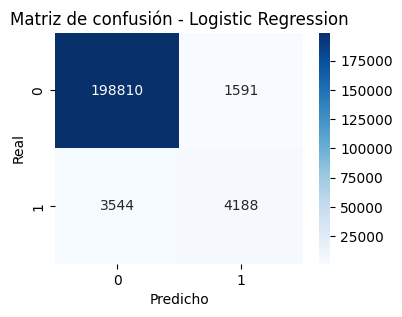


=== Resultados comparativos UnderA ===
                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
0  Logistic Regression  0.975328   0.724693  0.541645  0.619939  0.940866   

    PR-AUC  
0  0.67452  


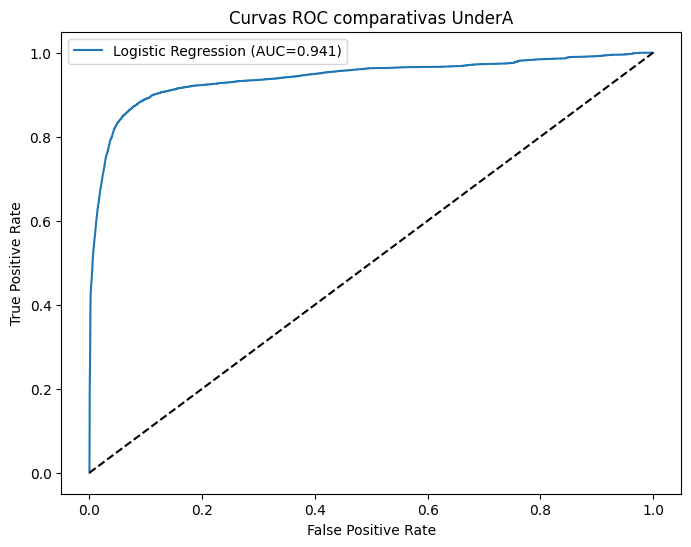

In [254]:
# == ENTRENAMIENTO DE REGRESIÓN LOGÍSTICA con datos Undersampled Aleatorio ==

# == FUNCIÓN PARA ENTRENAR EL MODELO ==
results_UnderA = []
roc_curves_UnderA = {}

def entrenar_modelo(nombre,pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Métricas
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)

    results_UnderA.append({
        "Modelo": nombre,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    })

    # Guardar curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves_UnderA[nombre] = (fpr, tpr, roc_auc)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión - {nombre}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    return pipeline

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=2000,class_weight=None,solver='saga',penalty='l1',C=0.001874))
])

modelologregUnderA= entrenar_modelo("Logistic Regression", logreg_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_UnderA = pd.DataFrame(results_UnderA)
print("\n=== Resultados comparativos UnderA ===")
print(df_results_UnderA.sort_values(by="PR-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves_UnderA.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas UnderA")
plt.legend()
plt.show()

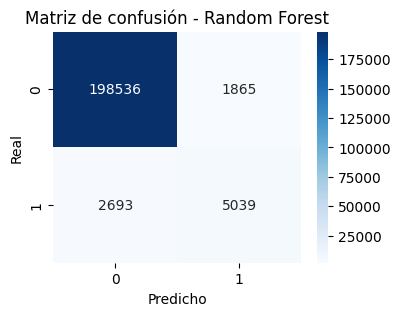


=== Resultados comparativos UnderA ===
                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
1        Random Forest  0.978101   0.729867  0.651707  0.688576  0.971985   
0  Logistic Regression  0.975328   0.724693  0.541645  0.619939  0.940866   

     PR-AUC  
1  0.747925  
0  0.674520  


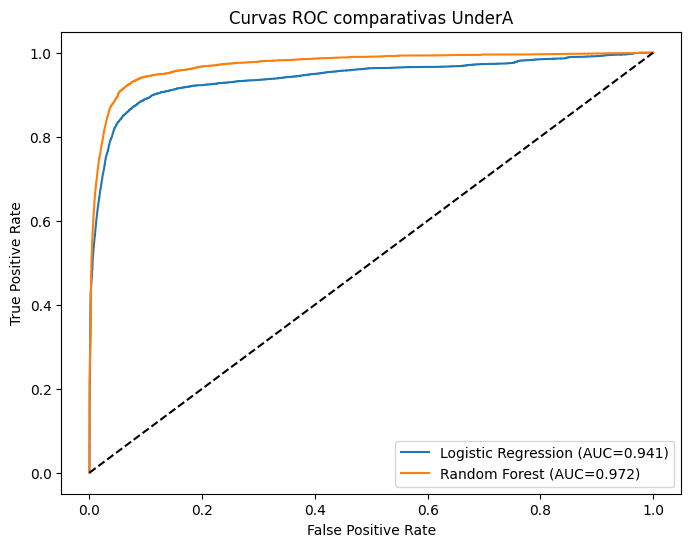

In [255]:
# == ENTRENAMIENTO DE RANDOM FOREST UNDERSAMPLING ALEATORIO ==
rforest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced',max_depth=None,random_state=42,max_features='log2',
    min_samples_leaf=4,min_samples_split=2,n_estimators=365,criterion='entropy'
))
])

modelorforestUnderA = entrenar_modelo("Random Forest", rforest_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_UnderA = pd.DataFrame(results_UnderA)
print("\n=== Resultados comparativos UnderA ===")
print(df_results_UnderA.sort_values(by="PR-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves_UnderA.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas UnderA")
plt.legend()
plt.show()

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:46:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


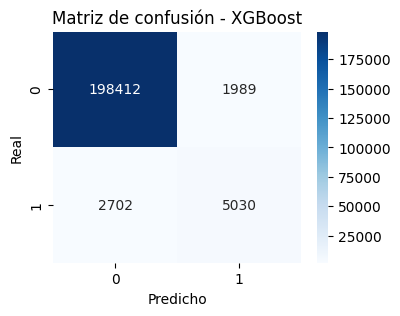


=== Resultados comparativos UnderA ===
                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
2              XGBoost  0.977462   0.716626  0.650543  0.681988  0.971898   
1        Random Forest  0.978101   0.729867  0.651707  0.688576  0.971985   
0  Logistic Regression  0.975328   0.724693  0.541645  0.619939  0.940866   

     PR-AUC  
2  0.772068  
1  0.747925  
0  0.674520  


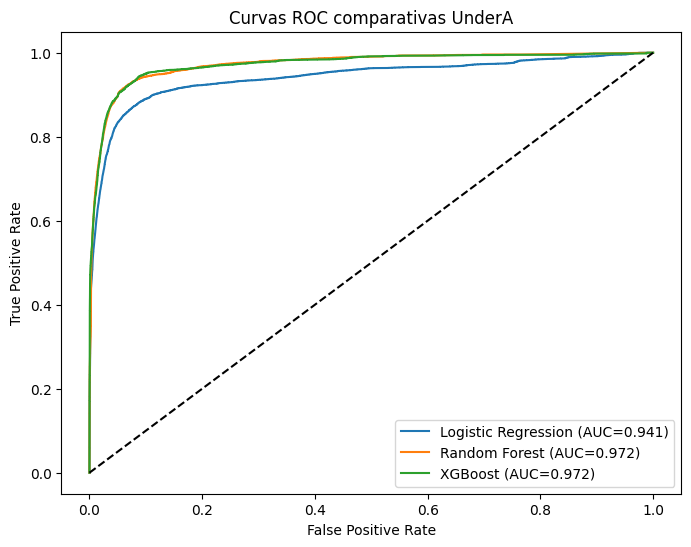

In [256]:
# == ENTRENAMIENTO DE XGBOOST con Undersamplig Aleatorio ==
xgboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
    n_estimators=224,
    max_depth=8,
    learning_rate=0.018305279707247,
    subsample=0.782656644669469,
    colsample_bytree=0.8662956317944550,
    gamma=1.529647033647,
    reg_lambda=1.49064268051789,
    min_child_weight=9,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    ))
])

modeloxgboostUnderA = entrenar_modelo("XGBoost", xgboost_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_UnderA = pd.DataFrame(results_UnderA)
print("\n=== Resultados comparativos UnderA ===")
print(df_results_UnderA.sort_values(by="PR-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves_UnderA.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas UnderA")
plt.legend()
plt.show()

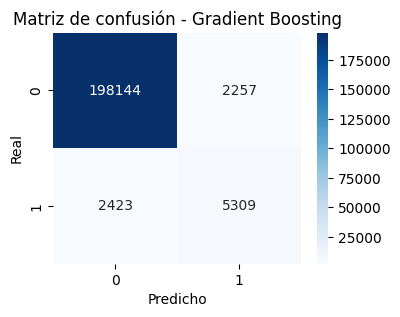


=== Resultados comparativos UnderA ===
                Modelo  Accuracy  Precision    Recall  F1-score   ROC-AUC  \
3    Gradient Boosting  0.977514   0.701692  0.686627  0.694078  0.972362   
2              XGBoost  0.977462   0.716626  0.650543  0.681988  0.971898   
1        Random Forest  0.978101   0.729867  0.651707  0.688576  0.971985   
0  Logistic Regression  0.975328   0.724693  0.541645  0.619939  0.940866   

     PR-AUC  
3  0.773743  
2  0.772068  
1  0.747925  
0  0.674520  


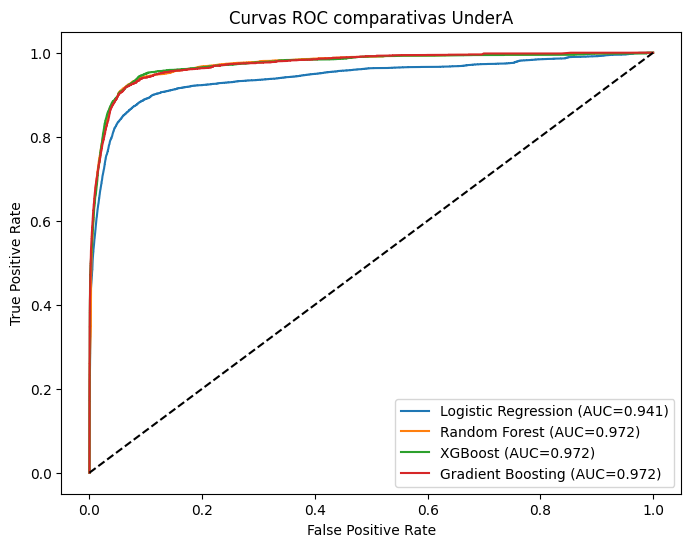

In [257]:
# == ENTRENAMIENTO DE GRADIENT BOOSTING con Undersamplig Aleatorio ==
gradb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
    subsample=1,
    n_estimators=149,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=3,
    max_features=None,
    criterion='friedman_mse',
    loss='log_loss',
    learning_rate=0.1,
    random_state=42))
])

modelogboostingUnderA = entrenar_modelo("Gradient Boosting", gradb_pipeline, X_train, y_train, X_test, y_test)

# == Tabla Comparativa de métricas ==
df_results_UnderA = pd.DataFrame(results_UnderA)
print("\n=== Resultados comparativos UnderA ===")
print(df_results_UnderA.sort_values(by="PR-AUC", ascending=False))

# == Curvas ROC comparativas ==
plt.figure(figsize=(8,6))
for nombre, (fpr, tpr, auc) in roc_curves_UnderA.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC comparativas UnderA")
plt.legend()
plt.show()

Mi conclusión del Undersampling es que ambos tipos de Undersampling causaron leves mejoras en los modelos, aunque nada muy notable.

Para los siguientes entrenamientos, en los que voy a implementar Ensemble de modelos, voy a utilizar los datasets de prueba y entrenamiento resultantes del primer proceso de undesampling en el que se preserva la separación por cirugías para evitar sesgos y fuga de información.

Entonces, a continuación repito el proceso para trabajar con los correctos X_train, X_test, y_train y y_test

In [ ]:
# === CARGAR DATOS ===
df = pd.read_parquet("windows_output/windows_aggregated_5min.parquet") #datos preparados con ventana de 5 minutos

# Separar variables y etiquetas
X = df.drop(columns=["label_hypoxemia", "caseid"])
y = df["label_hypoxemia"]

# === DIVISIÓN train/test POR CIRUGÍA ===
cirugias = df["caseid"].unique()
train_cir, test_cir = train_test_split(cirugias, test_size=0.2, random_state=42)

train_df = df[df["caseid"].isin(train_cir)].copy()
test_df  = df[df["caseid"].isin(test_cir)].copy()

# === CONFIGURACIÓN ===
target_ratio = 0.10  # proporción deseada de positivos (10%)
random_state = 42

# === Calcular proporción actual ===
total_pos = train_df["label_hypoxemia"].sum()
total_neg = len(train_df) - total_pos
current_ratio = total_pos / (total_pos + total_neg)
print(f"Proporción actual de positivos en datos de entrenamiento: {current_ratio:.2%}")

# === Identificar cirugías positivas y negativas ===
cirugias_pos = train_df.groupby("caseid")["label_hypoxemia"].max()
cirugias_pos = cirugias_pos[cirugias_pos == 1].index  

cirugias_neg = train_df.groupby("caseid")["label_hypoxemia"].max()
cirugias_neg = cirugias_neg[cirugias_neg == 0].index

print(f"Cirugías positivas: {len(cirugias_pos)}")
print(f"Cirugías negativas: {len(cirugias_neg)}")

# === Submuestreo por cirugías completas (fase 1) ===
# Estimamos cuántas cirugías negativas mantener para acercarnos a la proporción objetivo
neg_target_global = int(total_pos * (1 - target_ratio) / target_ratio)
neg_per_cirugia = train_df[train_df["label_hypoxemia"] == 0].groupby("caseid").size()
cum_neg = neg_per_cirugia.cumsum() / neg_per_cirugia.sum()

# Eliminamos cirugías negativas completas si sobran demasiados negativos
n_cirugias_a_mantener = min(len(cirugias_neg), int(len(cirugias_neg) * (target_ratio / current_ratio)))
cirugias_neg_keep = pd.Series(cirugias_neg).sample(n=n_cirugias_a_mantener, random_state=random_state)

# Subconjunto inicial con todas las cirugías positivas y las negativas seleccionadas
subset_df = train_df[train_df["caseid"].isin(cirugias_pos.union(cirugias_neg_keep))].copy()

# === Verificar proporción después del primer filtro ===
pos_count = subset_df["label_hypoxemia"].sum()
neg_count = len(subset_df) - pos_count
print(f"\nTras eliminar cirugías negativas completas:")
print(f"Positivos: {pos_count} | Negativos: {neg_count} | Ratio positivo: {pos_count/(pos_count+neg_count):.2%}")

# === Submuestreo dentro de las cirugías negativas restantes (fase 2) ===
# Si aún hay demasiados negativos, reducimos dentro de las cirugías seleccionadas
desired_neg = int(pos_count * (1 - target_ratio) / target_ratio)
if neg_count > desired_neg:
    neg_to_drop = neg_count - desired_neg
    frac_drop = 1 - (desired_neg / neg_count)
    
    print(f"Eliminando {frac_drop:.2%} de registros negativos dentro de las cirugías seleccionadas...")
    
    neg_samples = subset_df[subset_df["label_hypoxemia"] == 0]
    neg_keep = neg_samples.sample(frac=(1 - frac_drop), random_state=random_state)
    pos_samples = subset_df[subset_df["label_hypoxemia"] == 1]
    
    subset_df = pd.concat([pos_samples, neg_keep], ignore_index=True)
else:
    print("No se requiere reducción adicional dentro de las cirugías.")

# === Mostrar resultados finales ===
final_pos = subset_df["label_hypoxemia"].sum()
final_neg = len(subset_df) - final_pos
final_ratio = final_pos / (final_pos + final_neg)

print("\nDataset de entrenamiento final balanceado (mixto):")
print(f"Registros positivos: {final_pos}")
print(f"Registros negativos: {final_neg}")
print(f"Proporción final de positivos: {final_ratio:.2%}")
print(f"Tamaño final del dataset: {len(subset_df):,}")

X_train = subset_df.drop(columns=["label_hypoxemia", "caseid"])
y_train = subset_df["label_hypoxemia"]

# Mantener el mismo test original
X_test = df[df["caseid"].isin(test_cir)].drop(columns=["label_hypoxemia","caseid"])
y_test = df[df["caseid"].isin(test_cir)]["label_hypoxemia"]

Proporción actual de positivos en datos de entrenamiento: 3.06%
Cirugías positivas: 498
Cirugías negativas: 230

Tras eliminar cirugías negativas completas:
Positivos: 24918 | Negativos: 788587 | Ratio positivo: 3.06%
Eliminando 71.56% de registros negativos dentro de las cirugías seleccionadas...

Dataset de entrenamiento final balanceado (mixto):
Registros positivos: 24918
Registros negativos: 224262
Proporción final de positivos: 10.00%
Tamaño final del dataset: 249,180


## Ensemble de modelos

Ya he hecho diferentes entrenamientos con las cuatro arquitecturas de ML: variando hiperparámetros, ampliando el tamaño de la ventana y aplicando Unsampling al dataset de entrenamiento y no veo resultados que me parezcan lo suficientemente buenos, en todas las métricas, como para elegir uno de los cuatro modelos con que he trabajado. Por eso voy a probar con un ensemble.

Un ensemble (ensamble) combina varios modelos diferentes (a veces del mismo tipo, a veces de tipos distintos) para obtener una predicción más robusta y precisa que la que lograría cualquiera de ellos por separado. En vez de depender de un solo modelo (que puede tener sesgos o debilidades), el ensemble aprovecha las fortalezas de varios para mejorar el rendimiento global.

Existen tres tipos de ensembles que son los más comunes:
- Bagging (Bootstrap Aggregating)
- Boosting (Mejoramiento secuencial)
- Stacking (Ensamblado en capas o apilado)

En mi caso voy a implementar Stacking, que consiste en entrenar varios modelos base (por ejemplo: Logistic Regression, Random Forest, XGBoost, Gradient Boosting). Luego, se crea un modelo meta (meta-learner) que aprende a combinar las salidas de los anteriores; este meta-modelo puede ser, por ejemplo, una Regresión Logística, un árbol, o incluso una red neuronal ligera.
La ventaja de Stacking por sobre Bagging o Boosting es que permite mezclar modelos de distintas naturalezas.

**NOTA** 
Como las últimas pruebas que realicé fueron con los dataset a los que se les aplicó Undersampling, voy a aprovecharlos para entrenar el ensemble, esperando que esto ayude también con el desbalanceo y apoye la mejora en las métricas y el desempeño

### Ensemble - Stacking

In [15]:
# ENSEMBLE DE MODELOS USANDO STACKING
from sklearn.ensemble import StackingClassifier

# DEFINIR COLUMNAS NUMÉRICAS Y CATEGÓRICAS
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# PREPROCESADORES
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# Pipelines
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=2000,class_weight=None,solver='saga',penalty='l1',C=0.001874))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced',max_depth=None,random_state=42,max_features='log2',
    min_samples_leaf=4,min_samples_split=2,n_estimators=365,criterion='entropy'))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
    n_estimators=224,
    max_depth=8,
    learning_rate=0.018305279707247,
    subsample=0.782656644669469,
    colsample_bytree=0.8662956317944550,
    gamma=1.529647033647,
    reg_lambda=1.49064268051789,
    min_child_weight=9,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    ))
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
    subsample=1,
    n_estimators=149,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=3,
    max_features=None,
    criterion='friedman_mse',
    loss='log_loss',
    learning_rate=0.1,
    random_state=42))
])

# Definir los modelos base
estimators = [
    ('logreg', logreg_pipeline),
    ('rf', rf_pipeline),
    ('xgb', xgb_pipeline),
    ('gb', gb_pipeline)
]

# Modelo meta (meta-learner)
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Crear ensemble
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=False,       # Si True, agrega también las features originales al meta-modelo
    n_jobs=-1
)

# Entrenar ensemble
stacking_clf.fit(X_train, y_train)

# Predicciones
y_pred = stacking_clf.predict(X_test)
y_prob = stacking_clf.predict_proba(X_test)[:, 1]

# Evaluar desempeño
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

nombre_modelo = "Ensemble Stacking"
results_ensemble = {} 

# --- Calcular métricas ---
metrics1 = {
    "Modelo": nombre_modelo,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "PR-AUC": average_precision_score(y_test, y_prob)
    }

# --- Añadir resultados al DataFrame existente ---
df_metrics_ensemble = pd.DataFrame([metrics1])

# --- Guardar resultados en el diccionario global ---
results_ensemble[nombre_modelo] = (y_test, y_prob)


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[19:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[19:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[19:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[19:38:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[19:38:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Resultados para Ensemble Stacking:
Accuracy: 0.9214
Precision: 0.3121
Recall: 0.9274
F1-score: 0.4670
ROC-AUC: 0.9698
PR-AUC: 0.7229


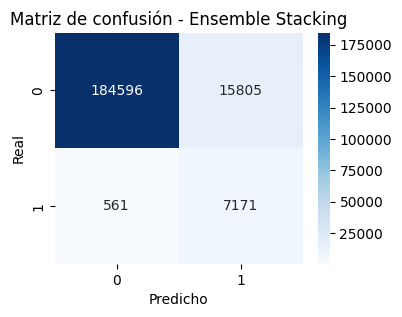

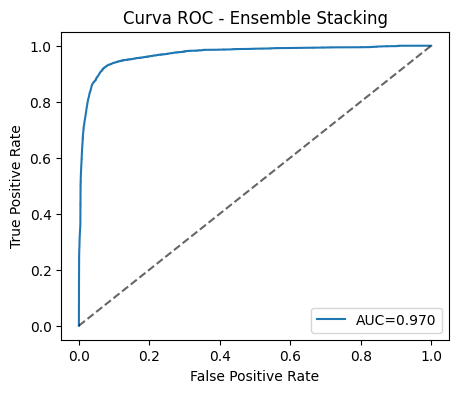

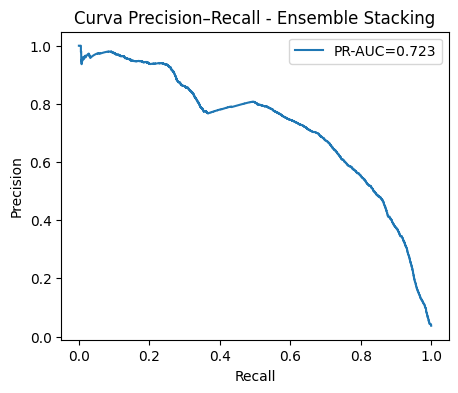

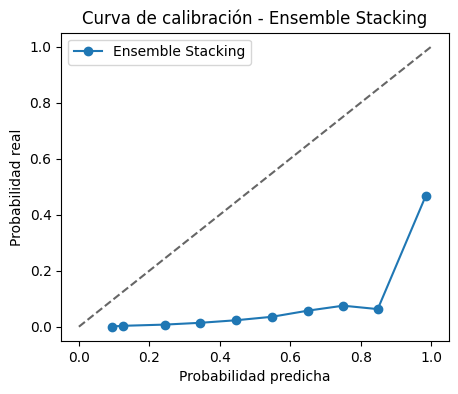

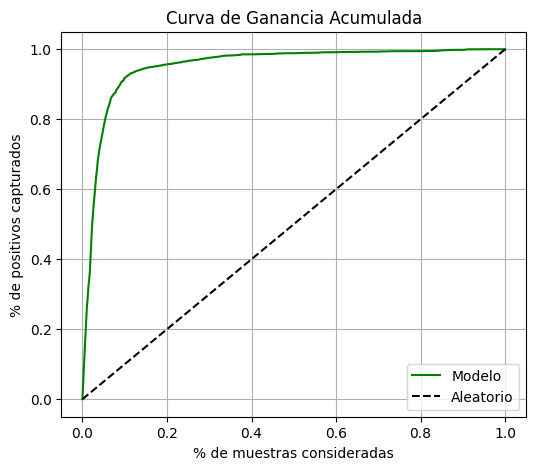

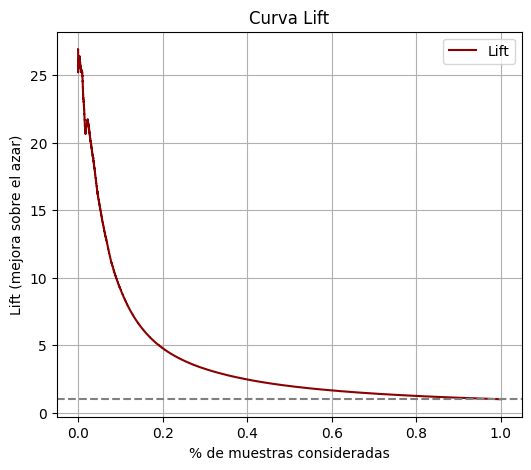

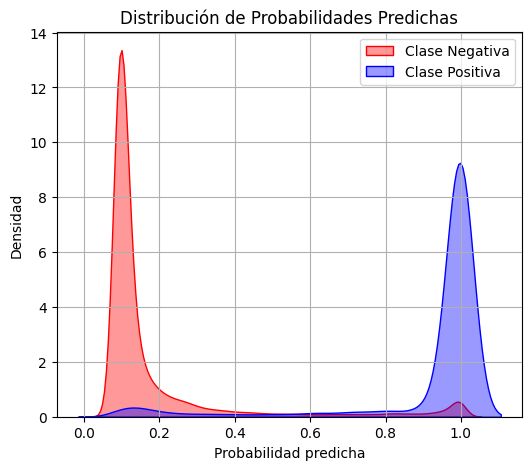

In [16]:
# --- Mostrar métricas ---
print(f"\nResultados para {nombre_modelo}:")
for k, v in metrics1.items():
    if k != "Modelo":
        print(f"{k}: {v:.4f}")

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión - {nombre_modelo}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Curva ROC - {nombre_modelo}")
plt.legend()
plt.show()

# --- Curva Precision–Recall ---
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label=f"PR-AUC={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision–Recall - {nombre_modelo}")
plt.legend()
plt.show()

# --- Curva de calibración ---
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(5, 4))
plt.plot(prob_pred, prob_true, marker='o', label=nombre_modelo)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("Probabilidad predicha")
plt.ylabel("Probabilidad real")
plt.title(f"Curva de calibración - {nombre_modelo}")
plt.legend()
plt.show()

#  CURVAS DE GANANCIA Y LIFT

# Ordenar las predicciones por probabilidad
data_gain = pd.DataFrame({"y_true": y_test, "y_prob": y_prob}).sort_values(by="y_prob", ascending=False)
data_gain["cum_positive"] = data_gain["y_true"].cumsum()
total_positives = data_gain["y_true"].sum()

data_gain["gain"] = data_gain["cum_positive"] / total_positives
data_gain["perc_samples"] = np.arange(1, len(data_gain) + 1) / len(data_gain)

# --- Curva de ganancia acumulada ---
plt.figure(figsize=(6, 5))
plt.plot(data_gain["perc_samples"], data_gain["gain"], label="Modelo", color="green")
plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
plt.xlabel("% de muestras consideradas")
plt.ylabel("% de positivos capturados")
plt.title("Curva de Ganancia Acumulada")
plt.legend()
plt.grid(True)
plt.show()

# --- Curva Lift ---
plt.figure(figsize=(6, 5))
plt.plot(data_gain["perc_samples"], data_gain["gain"] / data_gain["perc_samples"], color="darkred", label="Lift")
plt.axhline(1, color="gray", linestyle="--")
plt.xlabel("% de muestras consideradas")
plt.ylabel("Lift (mejora sobre el azar)")
plt.title("Curva Lift")
plt.legend()
plt.grid(True)
plt.show()


# --- Distribucion de probabilidades predichas ---
plt.figure(figsize=(6, 5))
sns.kdeplot(y_prob[y_test == 0], label="Clase Negativa", fill=True, color="red", alpha=0.4)
sns.kdeplot(y_prob[y_test == 1], label="Clase Positiva", fill=True, color="blue", alpha=0.4)
plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.title("Distribución de Probabilidades Predichas")
plt.legend()
plt.grid(True)
plt.show()


Observando los resultados de este entrenamiento, no veo una mejora dramática en las métricas, me parece que son muy siilares a las de algunos de los modelos entrenados de manera individual. Voy probar con las posibles extensiones que se pueden añadir al emsemble, comenzando por añadir **soft voting**.

### Ensemble + Soft Voting

Un voting classifier es una forma simple de ensamblar modelos: combina sus predicciones finales por mayoría (para clasificación binaria, tipo “votación”) o por promedio (para probabilidades).

- Hard voting: cada modelo “vota” 0 o 1, y gana la mayoría.
- Soft voting: promedia las probabilidades de cada modelo y elige según el promedio (más estable)

In [17]:
#ENSEMBLE DEE MODELOS CON IMPLEMENTACIÓN DE VotingClassifier

from sklearn.ensemble import VotingClassifier

# Pipelines
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=2000,class_weight=None,solver='saga',penalty='l1',C=0.001874))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced',max_depth=None,random_state=42,max_features='log2',
    min_samples_leaf=4,min_samples_split=2,n_estimators=365,criterion='entropy'))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
    n_estimators=224,
    max_depth=8,
    learning_rate=0.018305279707247,
    subsample=0.782656644669469,
    colsample_bytree=0.8662956317944550,
    gamma=1.529647033647,
    reg_lambda=1.49064268051789,
    min_child_weight=9,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    ))
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
    subsample=1,
    n_estimators=149,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=3,
    max_features=None,
    criterion='friedman_mse',
    loss='log_loss',
    learning_rate=0.1,
    random_state=42))
])

# Definir los modelos base
estimators = [
    ('logreg', logreg_pipeline),
    ('rf', rf_pipeline),
    ('xgb', xgb_pipeline),
    ('gb', gb_pipeline)
]

# Crear el ensemble con votación suave (soft)
voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1
)

# Entrenar
voting_clf.fit(X_train, y_train)

# Predicciones
y_pred = voting_clf.predict(X_test)
y_prob = voting_clf.predict_proba(X_test)[:, 1]

nombre_modelo = "Voting Classifier"

# --- Calcular métricas ---
metrics2 = {
    "Modelo": nombre_modelo,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "PR-AUC": average_precision_score(y_test, y_prob)
    }

# --- Añadir resultados al DataFrame existente ---

df_metrics_ensemble = pd.concat([df_metrics_ensemble, pd.DataFrame([metrics2])], ignore_index=True)

# --- Guardar resultados en el diccionario global ---
results_ensemble[nombre_modelo] = (y_test, y_prob)

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Resultados para Voting Classifier:
Accuracy: 0.9759
Precision: 0.6648
Recall: 0.7106
F1-score: 0.6869
ROC-AUC: 0.9714
PR-AUC: 0.7661


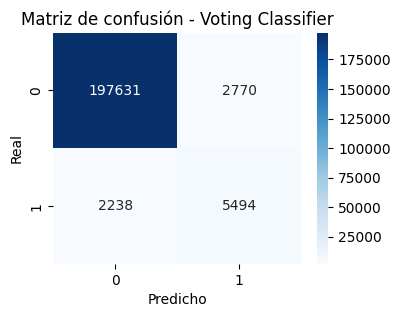

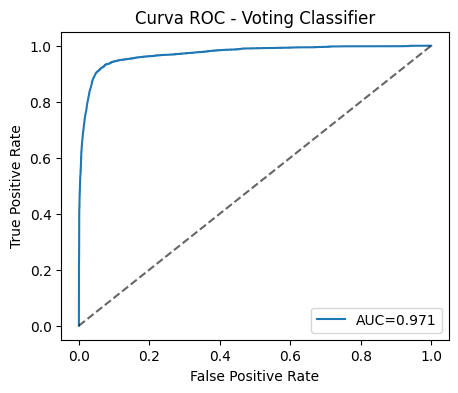

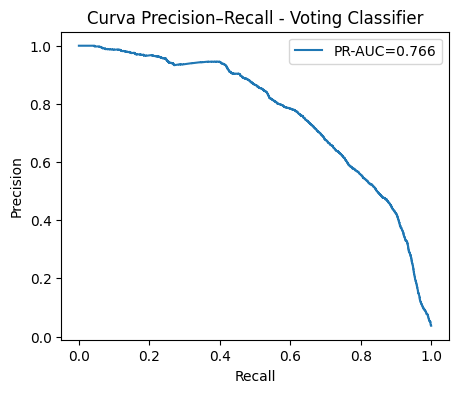

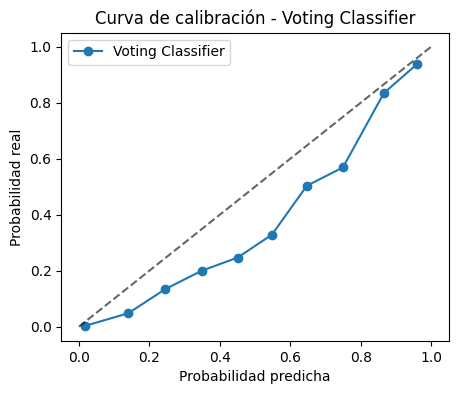

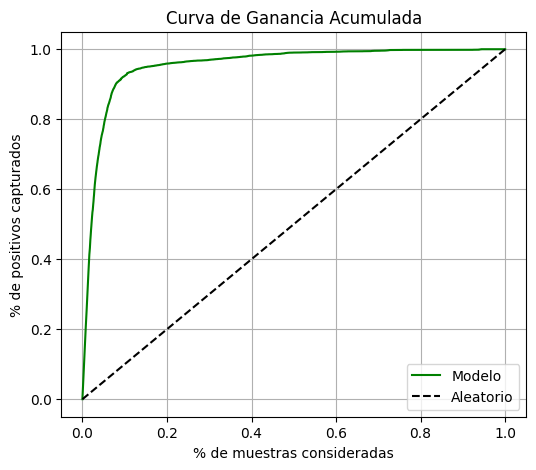

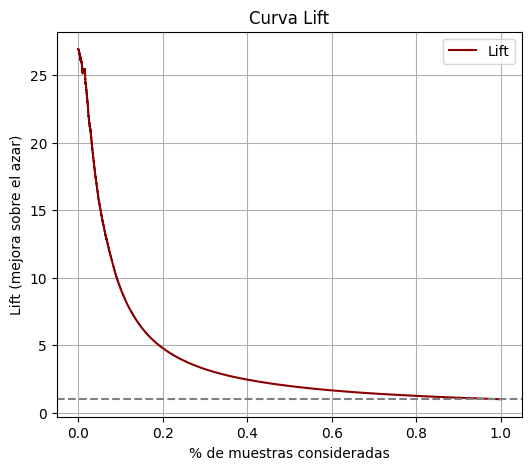

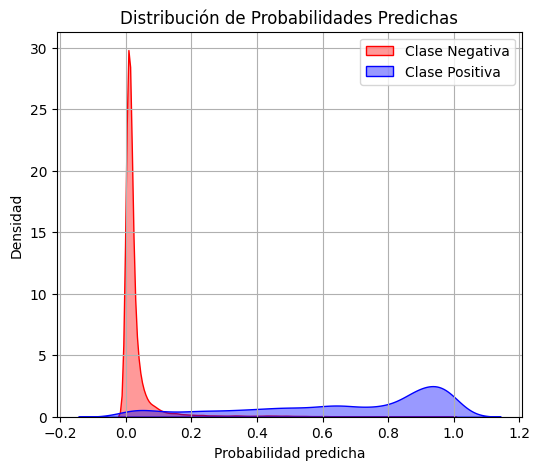

In [18]:
# --- Mostrar métricas ---
print(f"\n✅ Resultados para {nombre_modelo}:")
for k, v in metrics2.items():
    if k != "Modelo":
        print(f"{k}: {v:.4f}")

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión - {nombre_modelo}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Curva ROC - {nombre_modelo}")
plt.legend()
plt.show()

# --- Curva Precision–Recall ---
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label=f"PR-AUC={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision–Recall - {nombre_modelo}")
plt.legend()
plt.show()

# --- Curva de calibración ---
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(5, 4))
plt.plot(prob_pred, prob_true, marker='o', label=nombre_modelo)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("Probabilidad predicha")
plt.ylabel("Probabilidad real")
plt.title(f"Curva de calibración - {nombre_modelo}")
plt.legend()
plt.show()

#  CURVAS DE GANANCIA Y LIFT

# Ordenar las predicciones por probabilidad
data_gain = pd.DataFrame({"y_true": y_test, "y_prob": y_prob}).sort_values(by="y_prob", ascending=False)
data_gain["cum_positive"] = data_gain["y_true"].cumsum()
total_positives = data_gain["y_true"].sum()

data_gain["gain"] = data_gain["cum_positive"] / total_positives
data_gain["perc_samples"] = np.arange(1, len(data_gain) + 1) / len(data_gain)

# --- Curva de ganancia acumulada ---
plt.figure(figsize=(6, 5))
plt.plot(data_gain["perc_samples"], data_gain["gain"], label="Modelo", color="green")
plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
plt.xlabel("% de muestras consideradas")
plt.ylabel("% de positivos capturados")
plt.title("Curva de Ganancia Acumulada")
plt.legend()
plt.grid(True)
plt.show()

# --- Curva Lift ---
plt.figure(figsize=(6, 5))
plt.plot(data_gain["perc_samples"], data_gain["gain"] / data_gain["perc_samples"], color="darkred", label="Lift")
plt.axhline(1, color="gray", linestyle="--")
plt.xlabel("% de muestras consideradas")
plt.ylabel("Lift (mejora sobre el azar)")
plt.title("Curva Lift")
plt.legend()
plt.grid(True)
plt.show()


# --- Distribucion de probabilidades predichas ---
plt.figure(figsize=(6, 5))
sns.kdeplot(y_prob[y_test == 0], label="Clase Negativa", fill=True, color="red", alpha=0.4)
sns.kdeplot(y_prob[y_test == 1], label="Clase Positiva", fill=True, color="blue", alpha=0.4)
plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.title("Distribución de Probabilidades Predichas")
plt.legend()
plt.grid(True)
plt.show()


Las métricas entre el ensemble simple y el ensemble con sotf voting mejoraron!
Voy a intentar ahora un Weighted Voting, para ver si logro mejorarlas un poco más.

### Ensemble con Weighted Voting

el Weighted Voting Ensemble, que es la versión “inteligente” del VotingClassifier: en lugar de dar a cada modelo el mismo peso, pondremos más confianza en los que demostraron mejor desempeño individual (por ejemplo, XGBoost y Gradient Boosting).

Cada modelo base aporta una probabilidad para cada muestra. El ensemble combina esas probabilidades mediante un promedio ponderado, donde el peso de cada modelo se calcula según su ROC-AUC individual. Como sé que el PR-AUC es un mejor estimador del desempeño del modelo debido al desbalanceo del dataset, voy a realizar la misma prueba en dos versiones, una tomando como criterio el ROC-AUC y otra con el PR-AUC.

In [19]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler

# Pipelines
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=2000,class_weight=None,solver='saga',penalty='l1',C=0.001874))
])
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced',max_depth=None,random_state=42,max_features='log2',
    min_samples_leaf=4,min_samples_split=2,n_estimators=365,criterion='entropy'))
])
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
    n_estimators=224,
    max_depth=8,
    learning_rate=0.018305279707247,
    subsample=0.782656644669469,
    colsample_bytree=0.8662956317944550,
    gamma=1.529647033647,
    reg_lambda=1.49064268051789,
    min_child_weight=9,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    ))
])
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
    subsample=1,
    n_estimators=149,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=3,
    max_features=None,
    criterion='friedman_mse',
    loss='log_loss',
    learning_rate=0.1,
    random_state=42))
])

# === MODELOS BASE ===
estimators = [
    ('logreg', logreg_pipeline),
    ('rf', rf_pipeline),
    ('xgb', xgb_pipeline),
    ('gb', gb_pipeline)
]

# === PR-AUC individuales ===
prauc_scores = {
    'logreg': 0.699,
    'rf': 0.773,
    'xgb': 0.768,
    'gb': 0.771
}

# Normalizar los pesos (0-1) y asegurar que sumen 1
scaler = MinMaxScaler()
weights = scaler.fit_transform([[v] for v in prauc_scores.values()]).flatten()
weights = weights / weights.sum()

weights_list = [weights[i] for i in range(len(estimators))]

print("Pesos basados en PR-AUC:")
for (name, _), w in zip(estimators, weights_list):
    print(f"  {name}: {w:.3f}")

# === Crear ensemble con votación ponderada (soft voting) ===
voting_pr_auc = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=weights_list,
    n_jobs=-1
)    

# === Entrenar y evaluar ===
voting_pr_auc.fit(X_train, y_train)

y_pred = voting_pr_auc.predict(X_test)
y_prob = voting_pr_auc.predict_proba(X_test)[:, 1]

nombre_modelo = "Weighted Voting"

# --- Calcular métricas ---
metrics3 = {
    "Modelo": nombre_modelo,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "PR-AUC": average_precision_score(y_test, y_prob)
    }

# --- Añadir resultados al DataFrame existente ---

df_metrics_ensemble = pd.concat([df_metrics_ensemble, pd.DataFrame([metrics3])], ignore_index=True)

# --- Guardar resultados en el diccionario global ---
results_ensemble[nombre_modelo] = (y_test, y_prob)

Pesos basados en PR-AUC:
  logreg: 0.000
  rf: 0.344
  xgb: 0.321
  gb: 0.335


/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:57:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Resultados para Weighted Voting:
Accuracy: 0.9748
Precision: 0.6413
Recall: 0.7316
F1-score: 0.6835
ROC-AUC: 0.9727
PR-AUC: 0.7752


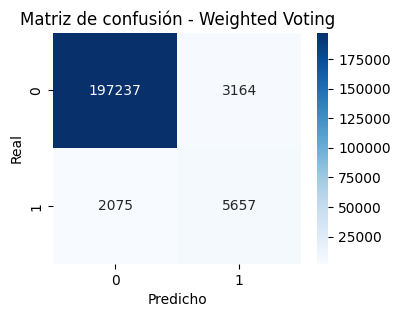

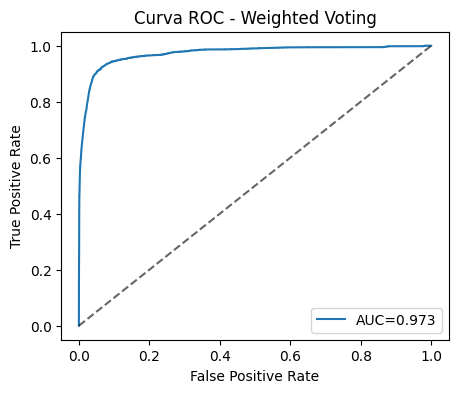

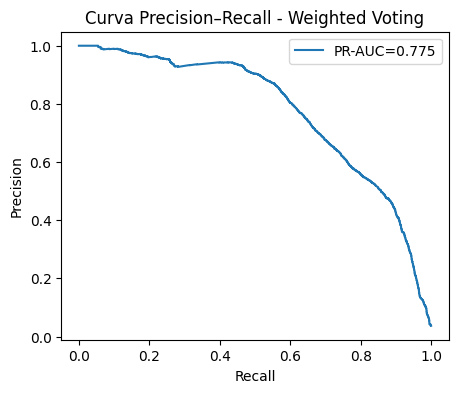

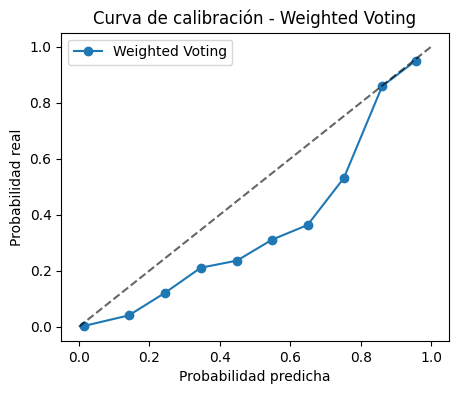

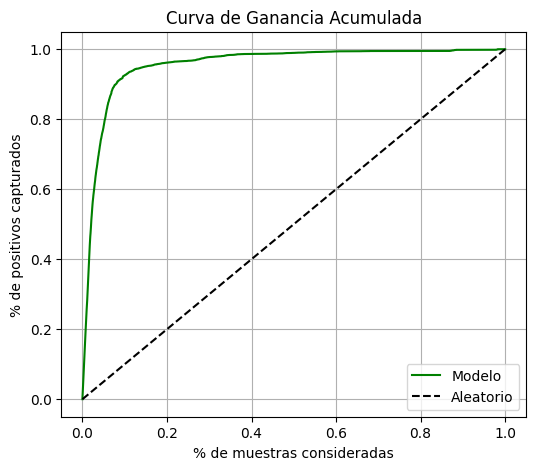

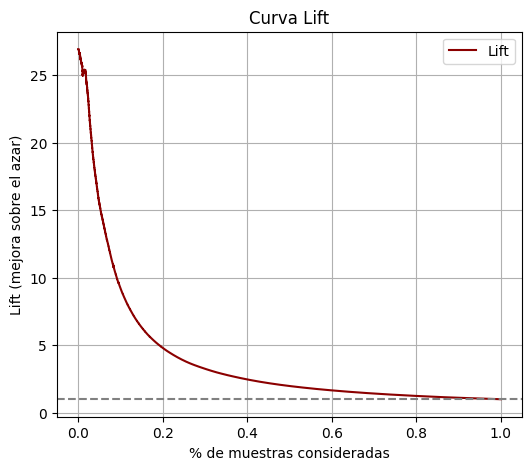

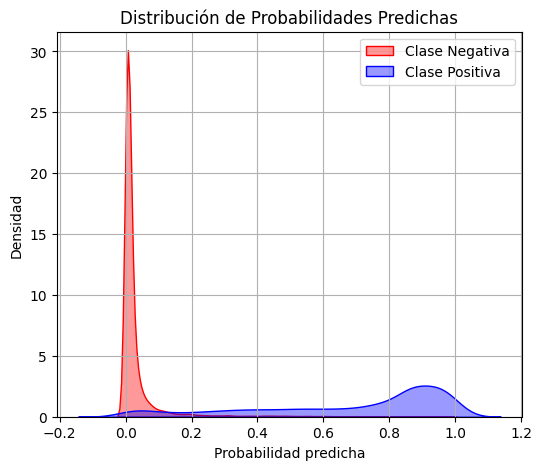

In [20]:
# --- Mostrar métricas ---
print(f"\nResultados para {nombre_modelo}:")
for k, v in metrics3.items():
    if k != "Modelo":
        print(f"{k}: {v:.4f}")

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matriz de confusión - {nombre_modelo}")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Curva ROC - {nombre_modelo}")
plt.legend()
plt.show()

# --- Curva Precision–Recall ---
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label=f"PR-AUC={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Curva Precision–Recall - {nombre_modelo}")
plt.legend()
plt.show()

# --- Curva de calibración ---
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(5, 4))
plt.plot(prob_pred, prob_true, marker='o', label=nombre_modelo)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("Probabilidad predicha")
plt.ylabel("Probabilidad real")
plt.title(f"Curva de calibración - {nombre_modelo}")
plt.legend()
plt.show()

#  CURVAS DE GANANCIA Y LIFT

# Ordenar las predicciones por probabilidad
data_gain = pd.DataFrame({"y_true": y_test, "y_prob": y_prob}).sort_values(by="y_prob", ascending=False)
data_gain["cum_positive"] = data_gain["y_true"].cumsum()
total_positives = data_gain["y_true"].sum()

data_gain["gain"] = data_gain["cum_positive"] / total_positives
data_gain["perc_samples"] = np.arange(1, len(data_gain) + 1) / len(data_gain)

# --- Curva de ganancia acumulada ---
plt.figure(figsize=(6, 5))
plt.plot(data_gain["perc_samples"], data_gain["gain"], label="Modelo", color="green")
plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
plt.xlabel("% de muestras consideradas")
plt.ylabel("% de positivos capturados")
plt.title("Curva de Ganancia Acumulada")
plt.legend()
plt.grid(True)
plt.show()

# --- Curva Lift ---
plt.figure(figsize=(6, 5))
plt.plot(data_gain["perc_samples"], data_gain["gain"] / data_gain["perc_samples"], color="darkred", label="Lift")
plt.axhline(1, color="gray", linestyle="--")
plt.xlabel("% de muestras consideradas")
plt.ylabel("Lift (mejora sobre el azar)")
plt.title("Curva Lift")
plt.legend()
plt.grid(True)
plt.show()


# --- Distribucion de probabilidades predichas ---
plt.figure(figsize=(6, 5))
sns.kdeplot(y_prob[y_test == 0], label="Clase Negativa", fill=True, color="red", alpha=0.4)
sns.kdeplot(y_prob[y_test == 1], label="Clase Positiva", fill=True, color="blue", alpha=0.4)
plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.title("Distribución de Probabilidades Predichas")
plt.legend()
plt.grid(True)
plt.show()


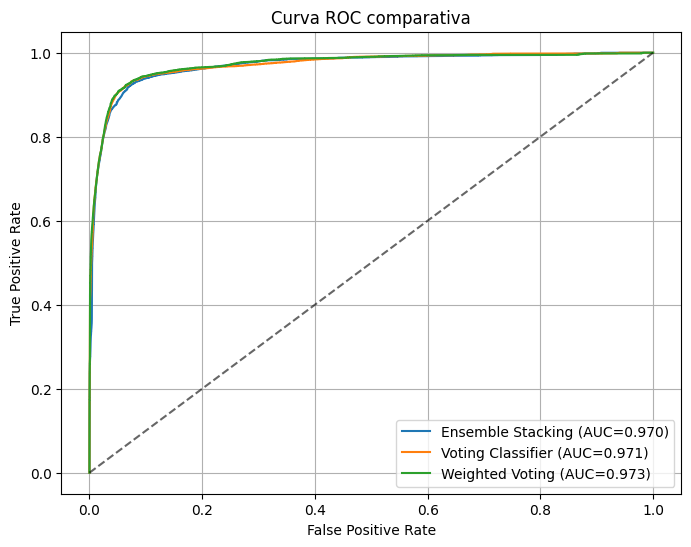

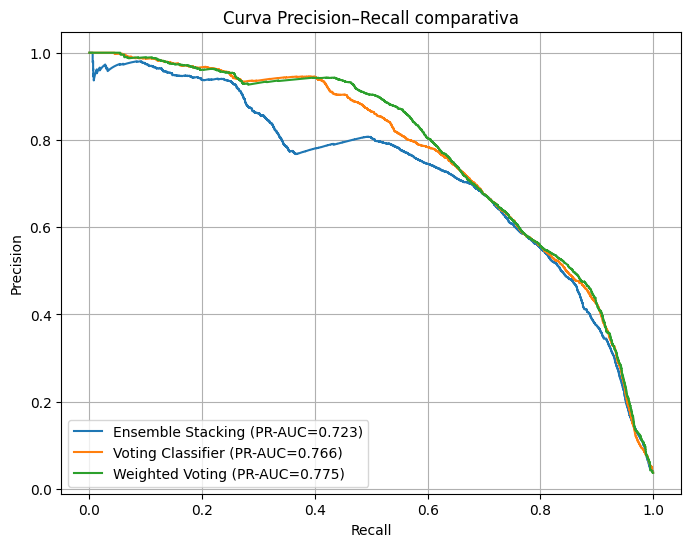

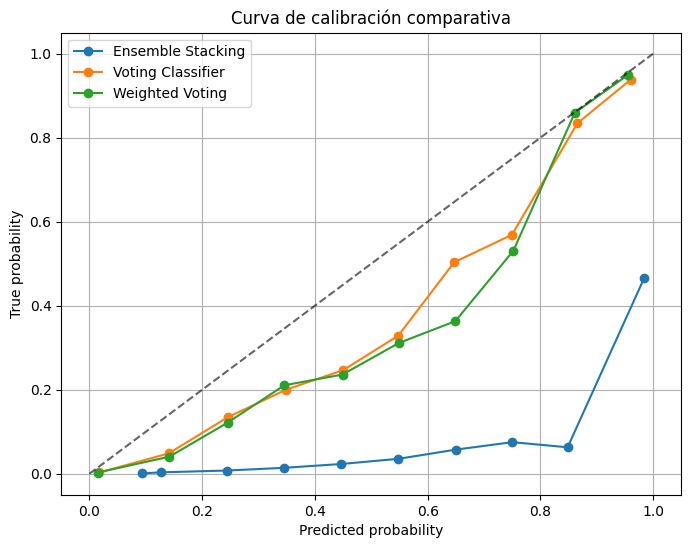

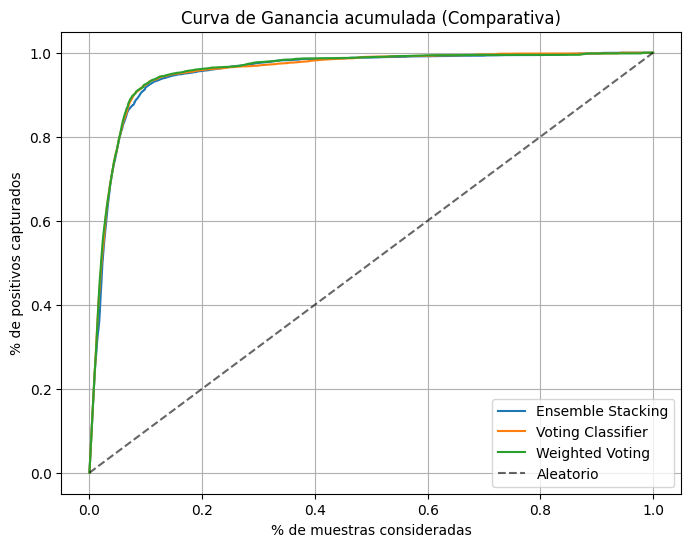

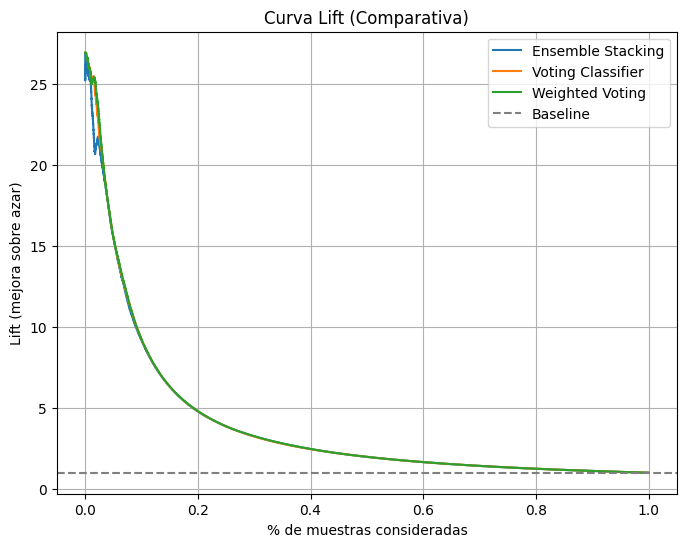

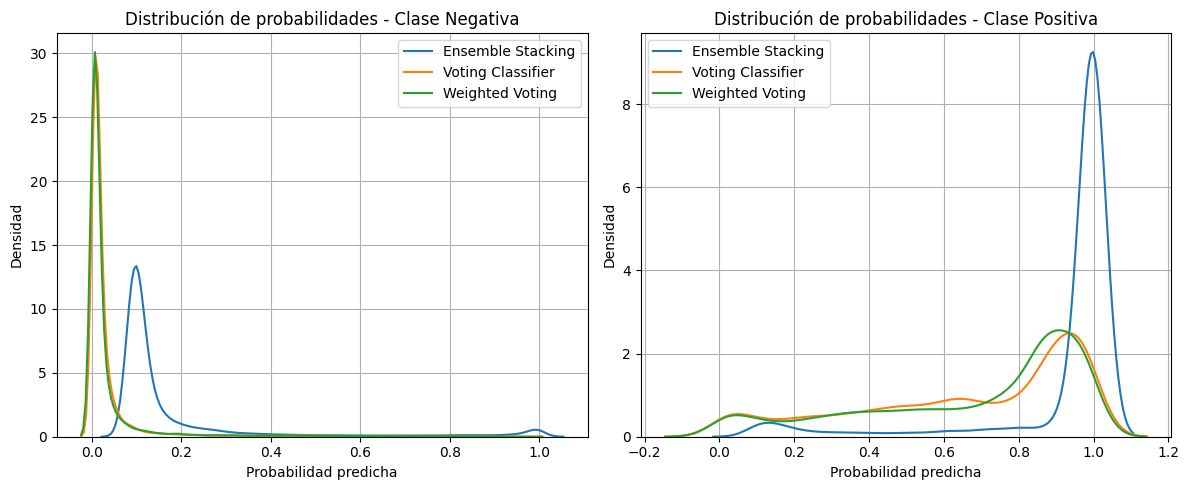

In [23]:
# ==== GRAFICAS COMPARATIVAS DE LOS TRES ENSEMBLES ====

# Orden de modelos (opcional): priorizar el orden deseado en las leyendas
model_names = list(results_ensemble.keys())

# Paleta de colores consistente
palette = sns.color_palette("tab10", n_colors=len(model_names))

# ROC comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, (name) in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", color=palette[i])
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC comparativa")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.3f})", color=palette[i])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall comparativa")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Calibración comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f"{name}", color=palette[i])
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Curva de calibración comparativa")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# Curva de Ganancia (Cumulative Gain) comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    df_gain = pd.DataFrame({"y_true": np.array(y_true), "y_prob": np.array(y_prob)})
    df_gain = df_gain.sort_values(by="y_prob", ascending=False).reset_index(drop=True)
    df_gain["cum_positive"] = df_gain["y_true"].cumsum()
    total_pos = df_gain["y_true"].sum()
    # evitar división por cero
    if total_pos == 0:
        continue
    df_gain["gain"] = df_gain["cum_positive"] / total_pos
    df_gain["perc_samples"] = (np.arange(1, len(df_gain) + 1) / len(df_gain))
    plt.plot(df_gain["perc_samples"], df_gain["gain"], label=f"{name}", color=palette[i])
plt.plot([0,1],[0,1],'k--', alpha=0.6, label="Aleatorio")
plt.xlabel("% de muestras consideradas")
plt.ylabel("% de positivos capturados")
plt.title("Curva de Ganancia acumulada (Comparativa)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Curva Lift comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    df_gain = pd.DataFrame({"y_true": np.array(y_true), "y_prob": np.array(y_prob)})
    df_gain = df_gain.sort_values(by="y_prob", ascending=False).reset_index(drop=True)
    df_gain["cum_positive"] = df_gain["y_true"].cumsum()
    total_pos = df_gain["y_true"].sum()
    if total_pos == 0:
        continue
    df_gain["gain"] = df_gain["cum_positive"] / total_pos
    df_gain["perc_samples"] = (np.arange(1, len(df_gain) + 1) / len(df_gain))
    lift = df_gain["gain"] / df_gain["perc_samples"]
    plt.plot(df_gain["perc_samples"], lift, label=f"{name}", color=palette[i])
plt.axhline(1, color='gray', linestyle='--', label='Baseline')
plt.xlabel("% de muestras consideradas")
plt.ylabel("Lift (mejora sobre azar)")
plt.title("Curva Lift (Comparativa)")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Distribución de probabilidades comparativa. (dos subplots: negativas y positivas)   
# -------------------------
plt.figure(figsize=(12,5))

# Subplot 1: clases negativas
plt.subplot(1,2,1)
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    y_true = np.array(y_true); y_prob = np.array(y_prob)
    if (y_true == 0).sum() == 0:
        continue
    sns.kdeplot(y_prob[y_true == 0], label=f"{name}", linewidth=1.5, fill=False, color=palette[i])
plt.title("Distribución de probabilidades - Clase Negativa")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)

# Subplot 2: clases positivas
plt.subplot(1,2,2)
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    y_true = np.array(y_true); y_prob = np.array(y_prob)
    if (y_true == 1).sum() == 0:
        continue
    sns.kdeplot(y_prob[y_true == 1], label=f"{name}", linewidth=1.5, fill=False, color=palette[i])
plt.title("Distribución de probabilidades - Clase Positiva")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Gráficas adicionales para los dos mejores modelos individuales

Según la tabla de pruebas, los mejore, modelos individuales son M65-XGB17 y M73-GradB10.

Voy a repetir estos entrenamientos para obtener las curvas adicionales y poder compararlas con las de los ensembles

In [24]:
#Entrenamiento Mejor versión de XGBoost

# Pipelines
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
    n_estimators=224,
    max_depth=8,
    learning_rate=0.018305279707247,
    subsample=0.782656644669469,
    colsample_bytree=0.8662956317944550,
    gamma=1.529647033647,
    reg_lambda=1.49064268051789,
    min_child_weight=9,
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    ))
])

#Entrenamiento
xgb_pipeline.fit(X_train, y_train)

# Predicciones
y_pred = xgb_pipeline.predict(X_test)
y_prob = xgb_pipeline.predict_proba(X_test)[:, 1]

# Evaluar desempeño
nombre_modelo = "Mejor XGBoost"

# --- Calcular métricas ---
metricsxgb = {
    "Modelo": nombre_modelo,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "PR-AUC": average_precision_score(y_test, y_prob)
    }

# --- Añadir resultados al DataFrame existente ---
df_metrics_ensemble = pd.DataFrame([metricsxgb])

# --- Guardar resultados en el diccionario global ---
results_ensemble[nombre_modelo] = (y_test, y_prob)

/Users/anap/Desktop/JAVERIANA/TGrado/Entornos/proyecto_hipoxemia_vitaldb/vitaldb_env_nuevo/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:33:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [25]:
#Entrenamiento Mejor versión de Gradient Boosting

# Pipelines
gradb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
    subsample=1,
    n_estimators=149,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=3,
    max_features=None,
    criterion='friedman_mse',
    loss='log_loss',
    learning_rate=0.1,
    random_state=42))
])

#Entrenamiento
gradb_pipeline.fit(X_train, y_train)

# Predicciones
y_pred = gradb_pipeline.predict(X_test)
y_prob = gradb_pipeline.predict_proba(X_test)[:, 1]

# Evaluar desempeño
nombre_modelo = "Mejor Gradient Boosting"

# --- Calcular métricas ---
metricsgb = {
    "Modelo": nombre_modelo,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "PR-AUC": average_precision_score(y_test, y_prob)
    }

# --- Añadir resultados al DataFrame existente ---
df_metrics_ensemble = pd.DataFrame([metricsgb])

# --- Guardar resultados en el diccionario global ---
results_ensemble[nombre_modelo] = (y_test, y_prob)

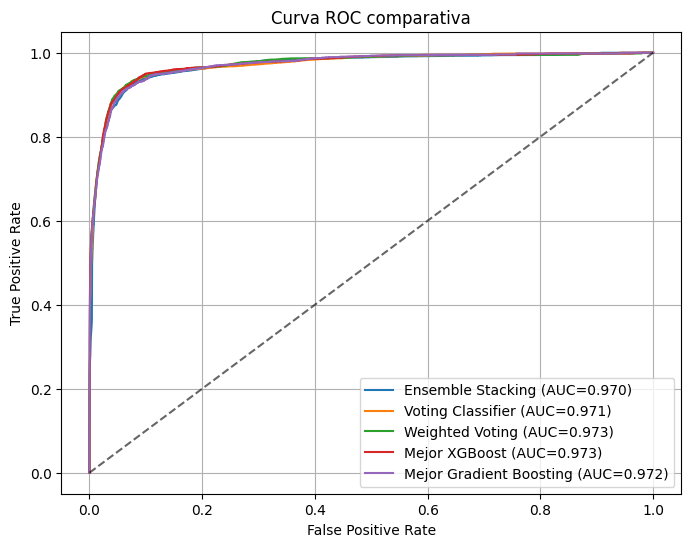

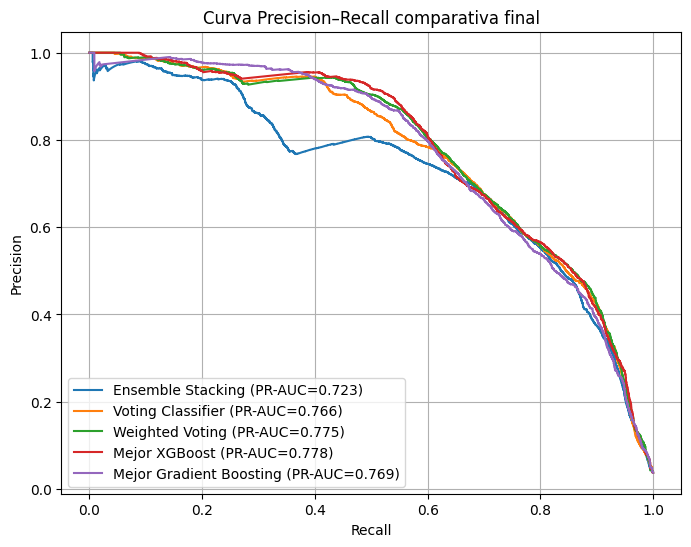

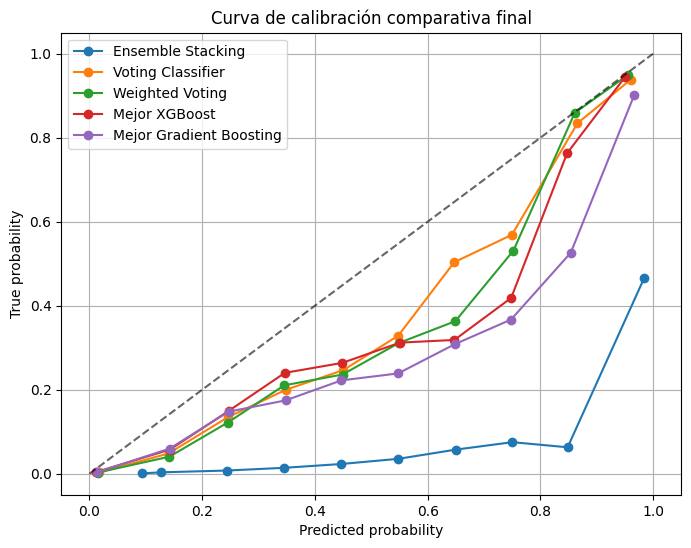

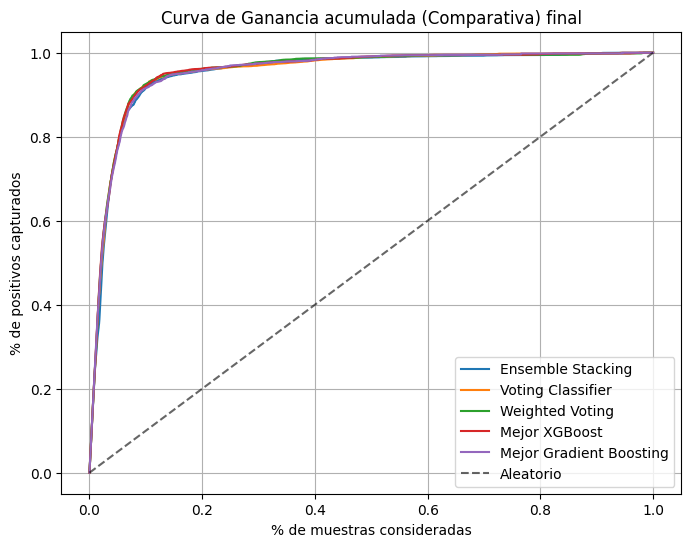

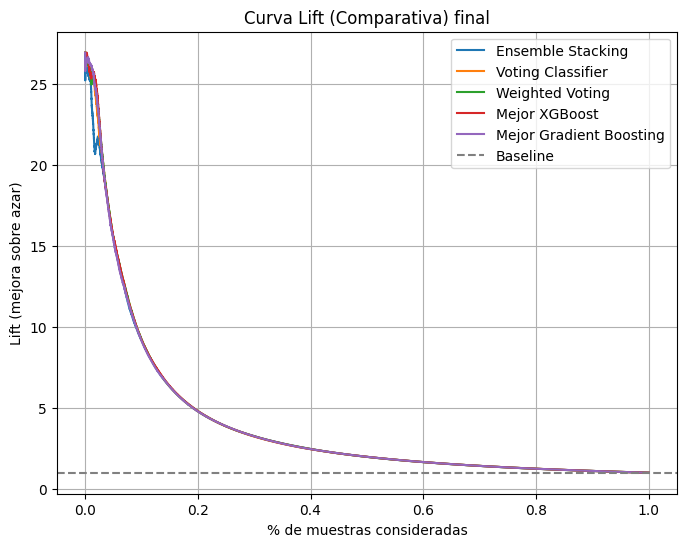

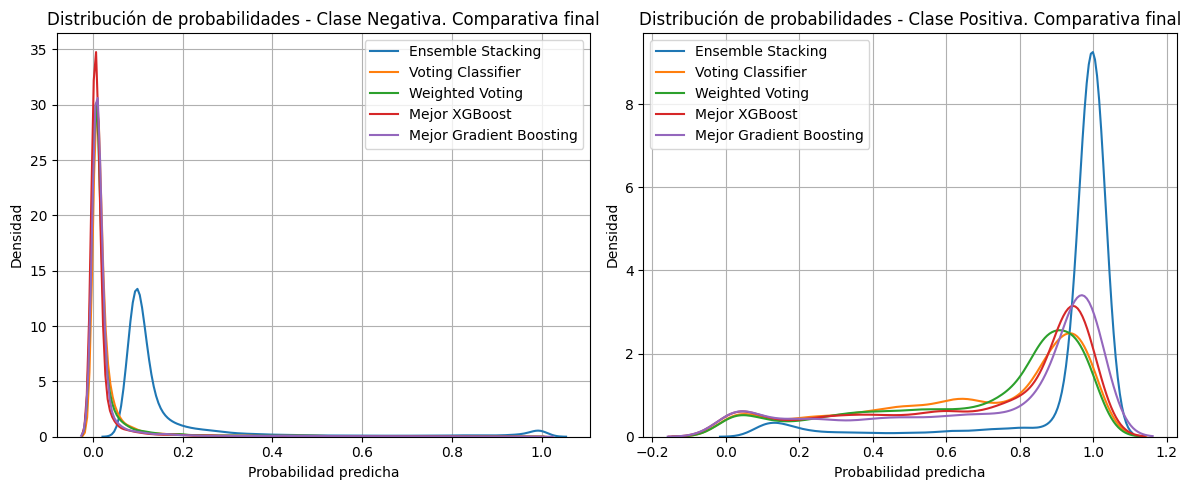

In [26]:
# ==== GRAFICAS COMPARATIVAS DE LOS TRES ENSEMBLES Y LOS DOS MEJORES MODELOS INDIVIDUALES ====

# Orden de modelos (opcional): priorizar el orden deseado en las leyendas
model_names = list(results_ensemble.keys())

# Paleta de colores consistente
palette = sns.color_palette("tab10", n_colors=len(model_names))

# ROC comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, (name) in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", color=palette[i])
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC comparativa")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.3f})", color=palette[i])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall comparativa final")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Calibración comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f"{name}", color=palette[i])
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Curva de calibración comparativa final")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# Curva de Ganancia (Cumulative Gain) comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    df_gain = pd.DataFrame({"y_true": np.array(y_true), "y_prob": np.array(y_prob)})
    df_gain = df_gain.sort_values(by="y_prob", ascending=False).reset_index(drop=True)
    df_gain["cum_positive"] = df_gain["y_true"].cumsum()
    total_pos = df_gain["y_true"].sum()
    # evitar división por cero
    if total_pos == 0:
        continue
    df_gain["gain"] = df_gain["cum_positive"] / total_pos
    df_gain["perc_samples"] = (np.arange(1, len(df_gain) + 1) / len(df_gain))
    plt.plot(df_gain["perc_samples"], df_gain["gain"], label=f"{name}", color=palette[i])
plt.plot([0,1],[0,1],'k--', alpha=0.6, label="Aleatorio")
plt.xlabel("% de muestras consideradas")
plt.ylabel("% de positivos capturados")
plt.title("Curva de Ganancia acumulada (Comparativa) final")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Curva Lift comparativa
# -------------------------
plt.figure(figsize=(8,6))
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    df_gain = pd.DataFrame({"y_true": np.array(y_true), "y_prob": np.array(y_prob)})
    df_gain = df_gain.sort_values(by="y_prob", ascending=False).reset_index(drop=True)
    df_gain["cum_positive"] = df_gain["y_true"].cumsum()
    total_pos = df_gain["y_true"].sum()
    if total_pos == 0:
        continue
    df_gain["gain"] = df_gain["cum_positive"] / total_pos
    df_gain["perc_samples"] = (np.arange(1, len(df_gain) + 1) / len(df_gain))
    lift = df_gain["gain"] / df_gain["perc_samples"]
    plt.plot(df_gain["perc_samples"], lift, label=f"{name}", color=palette[i])
plt.axhline(1, color='gray', linestyle='--', label='Baseline')
plt.xlabel("% de muestras consideradas")
plt.ylabel("Lift (mejora sobre azar)")
plt.title("Curva Lift (Comparativa) final")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Distribución de probabilidades comparativa. (dos subplots: negativas y positivas)   
# -------------------------
plt.figure(figsize=(12,5))

# Subplot 1: clases negativas
plt.subplot(1,2,1)
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    y_true = np.array(y_true); y_prob = np.array(y_prob)
    if (y_true == 0).sum() == 0:
        continue
    sns.kdeplot(y_prob[y_true == 0], label=f"{name}", linewidth=1.5, fill=False, color=palette[i])
plt.title("Distribución de probabilidades - Clase Negativa. Comparativa final")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)

# Subplot 2: clases positivas
plt.subplot(1,2,2)
for i, name in enumerate(model_names):
    y_true, y_prob = results_ensemble[name]
    y_true = np.array(y_true); y_prob = np.array(y_prob)
    if (y_true == 1).sum() == 0:
        continue
    sns.kdeplot(y_prob[y_true == 1], label=f"{name}", linewidth=1.5, fill=False, color=palette[i])
plt.title("Distribución de probabilidades - Clase Positiva. Comparativa final")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
